In [87]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

In [105]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import pandas as pd

# Use 'skip' to skip bad lines, 'warn' to display a warning, or provide a custom callable to handle bad lines
try:
    df = pd.read_csv("data.csv", on_bad_lines='skip')
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

y = np.array(df['strength'])
X = df['password']
x = np.array(X)

indices = [i for i, a in enumerate(x) if isinstance(a, float)]

df = df.drop(indices)

y = np.array(df['strength'])
X = df['password']
x = np.array(X)

length = []
lower = []
upper = []
number = []
other = []
for i in range(len(df)):
    length.append(len(x[i]))
    lower_count = sum(1 for char in x[i] if char.islower())
    lower.append(lower_count)
    upper_count = sum(1 for char in x[i] if char.isupper())
    upper.append(upper_count)
    number_count = sum(1 for char in x[i] if char.isdigit())
    number.append(number_count)
    other.append(len(x[i]) - lower_count - upper_count - number_count)


df['length'] = length
df['upper'] = upper
df['number'] = number
df['lower'] = lower
df['other'] = other

Xf = df[['upper','number','lower','other','length']]
yf = df['strength']

X_train, X_test, y_train, y_test = train_test_split(Xf, yf, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [214]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.c1 = nn.Linear(state_size, 100)
        self.c2 = nn.Linear(100, 100)
        self.c3 = nn.Linear(100, action_size)
    def forward(self, x):
        x = torch.relu(self.c1(x))
        x = torch.relu(self.c2(x))
        return self.c3(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, memory_size = 2000, gamma = 0.95, epsilon = 1.0, epsilon_min =0.01, epsilon_decay=0.995, learning_rate=0.001,batch_size=32):
        self.state_dim= state_dim
        self.action_dim= action_dim
        self.memory= []
        self.memory_size= memory_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.model= QNetwork(state_dim, action_dim)
        self.target_model = QNetwork(state_dim, action_dim)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_function = nn.MSELoss()

    def remember(self, state, action, reward):
        self.memory.append((state, action, reward))
        if len(self.memory) > self.memory_size:
            del self.memory[0]
            
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            dex =np.random.choice(self.action_dim) 
            return action_space[dex] # Choose a random action
        else:
            q_values = self.model(torch.FloatTensor(state)).detach().numpy()
            idex = np.argmax(q_values) 
            return action_space[idex]
            
    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        indices = random.sample(range(len(self.memory)), 32)
        array = range(len(self.memory))
        minibatch = [self.memory[idx] for idx in indices]
        states = np.array([item[0] for item in minibatch])
        actions = np.array([item[1] for item in minibatch])
        rewards = np.array([item[2] for item in minibatch])
        q_values_next = self.target_model(torch.FloatTensor(actions)).detach().numpy()
        targets = rewards +  self.gamma * np.max(q_values_next, axis=1)
        q_values = self.model(torch.FloatTensor(states)).detach().numpy()
        
        
        search_array = [tuple(sub) for sub in actions]
        array = [tuple(sub) for sub in action_space]
        indices = []
        for element in search_array:
            idx = array.index(element)
            indices.append(idx)
        print(targets)
        q_values[:, indices] = targets
        self.optimizer.zero_grad()
        loss = self.loss_function(self.model(torch.FloatTensor(states)), torch.FloatTensor(q_values))
        loss.backward()
        self.optimizer.step()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())


In [215]:
def spread(total, part):
    arr = [0]*part
    i = 0
    iter = 0
    while sum(arr) < total:
        arr[i]+=1
        i+=1
        if i == part:
            iter+=1
            i = i%part
    return arr, iter

def find_partitions(total, parts, prefix=[]):
    if parts == 1:
        return [prefix + [total]]
    
    partitions = []
    for i in range(total + 1):
        for partition in find_partitions(total - i, parts - 1, prefix + [i]):
            partitions.append(partition)
    return partitions

def find(total, parts):
    return find_partitions(total, parts)

action_space = []
for i in range(5,16):
    arr = find(i, 4)
    for param in arr:
        param = param + [sum(param)]
        action_space.append(param)
state_size = len(action_space[1])
act_size = len(action_space)

In [216]:
agent = DQNAgent(state_size, act_size)


In [217]:
passwords = []
rewards = []
action = [5,0,0,0,5]
for episode in range(1000):
    state = action
    done = False
    while not done:

        action = agent.act(state)
        #print(action) 
        reward = clf.predict(np.array([action]))
        passwords.append(action)
        rewards.append(reward**3)
        
        if len(agent.memory) >= agent.batch_size:
            done = True

        agent.remember(state, action, reward)

    agent.replay()
    agent.update_target_model()
   # print(f"Episode: {episode + 1}, Total Reward: {total_reward}")


C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[1.24719095 2.33230758 1.95432615 ... 1.79143476 2.65457773 2.0011797 ]
 [2.24719095 3.33230758 2.95432615 ... 2.79143476 3.65457773 3.0011797 ]
 [2.24719095 3.33230758 2.95432615 ... 2.79143476 3.65457773 3.0011797 ]
 ...
 [2.24719095 3.33230758 2.95432615 ... 2.79143476 3.65457773 3.0011797 ]
 [3.24719095 4.33230758 3.95432615 ... 3.79143476 4.65457773 4.0011797 ]
 [2.24719095 3.33230758 2.95432615 ... 2.79143476 3.65457773 3.0011797 ]]
[[3.35179639 3.65169549 3.75828886 ... 2.25260234 3.44456959 2.90775275]
 [4.35179639 4.65169549 4.75828886 ... 3.25260234 4.44456959 3.90775275]
 [4.35179639 4.65169549 4.75828886 ... 3.25260234 4.44456959 3.90775275]
 ...
 [2.35179639 2.65169549 2.75828886 ... 1.25260234 2.44456959 1.90775275]
 [3.35179639 3.65169549 3.75828886 ... 2.25260234 3.44456959 2.90775275]
 [3.35179639 3.65169549 3.75828886 ... 2.25260234 3.44456959 2.90775275]]
[[2.95329106 3.58526087 2.29999137 ... 3.3944869  3.36544275 2.25404263]
 [2.95329106 3.58526087 2.29999137 ... 

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[4.37555146 4.43912053 3.01948786 ... 3.94660902 3.72737312 4.65534806]
 [5.37555146 5.43912053 4.01948786 ... 4.94660902 4.72737312 5.65534806]
 [4.37555146 4.43912053 3.01948786 ... 3.94660902 3.72737312 4.65534806]
 ...
 [5.37555146 5.43912053 4.01948786 ... 4.94660902 4.72737312 5.65534806]
 [4.37555146 4.43912053 3.01948786 ... 3.94660902 3.72737312 4.65534806]
 [5.37555146 5.43912053 4.01948786 ... 4.94660902 4.72737312 5.65534806]]
[[1.75320971 3.75411177 2.36999702 ... 3.67444539 3.97616577 1.80860114]
 [3.75320971 5.75411177 4.36999702 ... 5.67444539 5.97616577 3.80860114]
 [2.75320971 4.75411177 3.36999702 ... 4.67444539 4.97616577 2.80860114]
 ...
 [2.75320971 4.75411177 3.36999702 ... 4.67444539 4.97616577 2.80860114]
 [3.75320971 5.75411177 4.36999702 ... 5.67444539 5.97616577 3.80860114]
 [1.75320971 3.75411177 2.36999702 ... 3.67444539 3.97616577 1.80860114]]
[[4.55635047 3.8049674  4.19880867 ... 3.38652682 4.40146708 3.34580135]
 [4.55635047 3.8049674  4.19880867 ... 

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[6.2842679  5.89863443 7.05285883 ... 4.77323461 5.77042866 3.73252892]
 [7.2842679  6.89863443 8.05285883 ... 5.77323461 6.77042866 4.73252892]
 [7.2842679  6.89863443 8.05285883 ... 5.77323461 6.77042866 4.73252892]
 ...
 [6.2842679  5.89863443 7.05285883 ... 4.77323461 5.77042866 3.73252892]
 [7.2842679  6.89863443 8.05285883 ... 5.77323461 6.77042866 4.73252892]
 [5.2842679  4.89863443 6.05285883 ... 3.77323461 4.77042866 2.73252892]]
[[6.53305626 5.69908476 8.47998095 ... 6.52411318 6.32178736 3.49904132]
 [6.53305626 5.69908476 8.47998095 ... 6.52411318 6.32178736 3.49904132]
 [7.53305626 6.69908476 9.47998095 ... 7.52411318 7.32178736 4.49904132]
 ...
 [6.53305626 5.69908476 8.47998095 ... 6.52411318 6.32178736 3.49904132]
 [6.53305626 5.69908476 8.47998095 ... 6.52411318 6.32178736 3.49904132]
 [5.53305626 4.69908476 7.47998095 ... 5.52411318 5.32178736 2.49904132]]
[[ 4.7887578   6.20392227  5.29347467 ...  4.17490268  9.43101692
   4.71580005]
 [ 4.7887578   6.20392227  5.29

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[10.95762444  9.48746681  7.91422272 ...  5.7887001   9.97474098
   9.17260933]
 [ 9.95762444  8.48746681  6.91422272 ...  4.7887001   8.97474098
   8.17260933]
 [ 9.95762444  8.48746681  6.91422272 ...  4.7887001   8.97474098
   8.17260933]
 ...
 [ 8.95762444  7.48746681  5.91422272 ...  3.7887001   7.97474098
   7.17260933]
 [ 9.95762444  8.48746681  6.91422272 ...  4.7887001   8.97474098
   8.17260933]
 [ 9.95762444  8.48746681  6.91422272 ...  4.7887001   8.97474098
   8.17260933]]
[[ 8.72556019  9.54227352 10.17201614 ...  8.70674801  9.04199314
   6.87898207]
 [ 9.72556019 10.54227352 11.17201614 ...  9.70674801 10.04199314
   7.87898207]
 [ 9.72556019 10.54227352 11.17201614 ...  9.70674801 10.04199314
   7.87898207]
 ...
 [ 8.72556019  9.54227352 10.17201614 ...  8.70674801  9.04199314
   6.87898207]
 [ 8.72556019  9.54227352 10.17201614 ...  8.70674801  9.04199314
   6.87898207]
 [ 8.72556019  9.54227352 10.17201614 ...  8.70674801  9.04199314
   6.87898207]]
[[ 9.48330688  7

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[16.83088875 17.25641441 12.56551647 ... 17.52082157 18.77731133
   9.37471867]
 [15.83088875 16.25641441 11.56551647 ... 16.52082157 17.77731133
   8.37471867]
 [15.83088875 16.25641441 11.56551647 ... 16.52082157 17.77731133
   8.37471867]
 ...
 [15.83088875 16.25641441 11.56551647 ... 16.52082157 17.77731133
   8.37471867]
 [16.83088875 17.25641441 12.56551647 ... 17.52082157 18.77731133
   9.37471867]
 [14.83088875 15.25641441 10.56551647 ... 15.52082157 16.77731133
   7.37471867]]
[[25.23628807 18.23296356 20.77809715 ... 18.23296356 17.16065788
  18.49123955]
 [24.23628807 17.23296356 19.77809715 ... 17.23296356 16.16065788
  17.49123955]
 [25.23628807 18.23296356 20.77809715 ... 18.23296356 17.16065788
  18.49123955]
 ...
 [24.23628807 17.23296356 19.77809715 ... 17.23296356 16.16065788
  17.49123955]
 [24.23628807 17.23296356 19.77809715 ... 17.23296356 16.16065788
  17.49123955]
 [24.23628807 17.23296356 19.77809715 ... 17.23296356 16.16065788
  17.49123955]]
[[21.24399567 17

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[11.76195335 17.26817131 33.14408493 ... 16.53826714 22.80872917
  24.10077667]
 [12.76195335 18.26817131 34.14408493 ... 17.53826714 23.80872917
  25.10077667]
 [13.76195335 19.26817131 35.14408493 ... 18.53826714 24.80872917
  26.10077667]
 ...
 [12.76195335 18.26817131 34.14408493 ... 17.53826714 23.80872917
  25.10077667]
 [12.76195335 18.26817131 34.14408493 ... 17.53826714 23.80872917
  25.10077667]
 [12.76195335 18.26817131 34.14408493 ... 17.53826714 23.80872917
  25.10077667]]
[[26.02752495 29.17796135 28.78764343 ... 18.92074394 29.21756363
  26.5271225 ]
 [26.02752495 29.17796135 28.78764343 ... 18.92074394 29.21756363
  26.5271225 ]
 [27.02752495 30.17796135 29.78764343 ... 19.92074394 30.21756363
  27.5271225 ]
 ...
 [26.02752495 29.17796135 28.78764343 ... 18.92074394 29.21756363
  26.5271225 ]
 [27.02752495 30.17796135 29.78764343 ... 19.92074394 30.21756363
  27.5271225 ]
 [26.02752495 29.17796135 28.78764343 ... 18.92074394 29.21756363
  26.5271225 ]]
[[27.30946159 28

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[16.49947548 31.01543236 17.89112473 ... 37.84535217 33.73009491
  33.53388977]
 [17.49947548 32.01543236 18.89112473 ... 38.84535217 34.73009491
  34.53388977]
 [16.49947548 31.01543236 17.89112473 ... 37.84535217 33.73009491
  33.53388977]
 ...
 [18.49947548 33.01543236 19.89112473 ... 39.84535217 35.73009491
  35.53388977]
 [17.49947548 32.01543236 18.89112473 ... 38.84535217 34.73009491
  34.53388977]
 [17.49947548 32.01543236 18.89112473 ... 38.84535217 34.73009491
  34.53388977]]
[[37.39491653 27.37325096 39.82582092 ... 36.69340134 28.21490479
  34.29795074]
 [37.39491653 27.37325096 39.82582092 ... 36.69340134 28.21490479
  34.29795074]
 [37.39491653 27.37325096 39.82582092 ... 36.69340134 28.21490479
  34.29795074]
 ...
 [37.39491653 27.37325096 39.82582092 ... 36.69340134 28.21490479
  34.29795074]
 [37.39491653 27.37325096 39.82582092 ... 36.69340134 28.21490479
  34.29795074]
 [37.39491653 27.37325096 39.82582092 ... 36.69340134 28.21490479
  34.29795074]]
[[38.74335861 40

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[61.87727737 52.51532745 68.98683929 ... 64.35943222 56.27523804
  54.74304962]
 [60.87727737 51.51532745 67.98683929 ... 63.35943222 55.27523804
  53.74304962]
 [61.87727737 52.51532745 68.98683929 ... 64.35943222 56.27523804
  54.74304962]
 ...
 [61.87727737 52.51532745 68.98683929 ... 64.35943222 56.27523804
  54.74304962]
 [60.87727737 51.51532745 67.98683929 ... 63.35943222 55.27523804
  53.74304962]
 [60.87727737 51.51532745 67.98683929 ... 63.35943222 55.27523804
  53.74304962]]
[[57.96787643 49.09305954 65.12737274 ... 45.08081818 42.53955841
  47.23379135]
 [57.96787643 49.09305954 65.12737274 ... 45.08081818 42.53955841
  47.23379135]
 [58.96787643 50.09305954 66.12737274 ... 46.08081818 43.53955841
  48.23379135]
 ...
 [57.96787643 49.09305954 65.12737274 ... 45.08081818 42.53955841
  47.23379135]
 [57.96787643 49.09305954 65.12737274 ... 45.08081818 42.53955841
  47.23379135]
 [57.96787643 49.09305954 65.12737274 ... 45.08081818 42.53955841
  47.23379135]]
[[69.54761505 63

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[103.34001923  85.07505798  56.37496567 ... 117.96497345 131.8572998
  140.17178345]
 [103.34001923  85.07505798  56.37496567 ... 117.96497345 131.8572998
  140.17178345]
 [102.34001923  84.07505798  55.37496567 ... 116.96497345 130.8572998
  139.17178345]
 ...
 [103.34001923  85.07505798  56.37496567 ... 117.96497345 131.8572998
  140.17178345]
 [104.34001923  86.07505798  57.37496567 ... 118.96497345 132.8572998
  141.17178345]
 [104.34001923  86.07505798  57.37496567 ... 118.96497345 132.8572998
  141.17178345]]
[[124.43328857 124.43328857 121.48967743 ... 145.06884766  88.01829529
   67.492836  ]
 [124.43328857 124.43328857 121.48967743 ... 145.06884766  88.01829529
   67.492836  ]
 [124.43328857 124.43328857 121.48967743 ... 145.06884766  88.01829529
   67.492836  ]
 ...
 [125.43328857 125.43328857 122.48967743 ... 146.06884766  89.01829529
   68.492836  ]
 [124.43328857 124.43328857 121.48967743 ... 145.06884766  88.01829529
   67.492836  ]
 [123.43328857 123.43328857 120.489677

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[216.39295959 213.11380005 260.54922485 ... 240.80285645 172.80410767
  172.90768433]
 [216.39295959 213.11380005 260.54922485 ... 240.80285645 172.80410767
  172.90768433]
 [217.39295959 214.11380005 261.54922485 ... 241.80285645 173.80410767
  173.90768433]
 ...
 [217.39295959 214.11380005 261.54922485 ... 241.80285645 173.80410767
  173.90768433]
 [216.39295959 213.11380005 260.54922485 ... 240.80285645 172.80410767
  172.90768433]
 [216.39295959 213.11380005 260.54922485 ... 240.80285645 172.80410767
  172.90768433]]
[[225.27670288 234.74217224 235.72343445 ... 227.72599792 145.73298645
  217.38253784]
 [225.27670288 234.74217224 235.72343445 ... 227.72599792 145.73298645
  217.38253784]
 [225.27670288 234.74217224 235.72343445 ... 227.72599792 145.73298645
  217.38253784]
 ...
 [225.27670288 234.74217224 235.72343445 ... 227.72599792 145.73298645
  217.38253784]
 [225.27670288 234.74217224 235.72343445 ... 227.72599792 145.73298645
  217.38253784]
 [225.27670288 234.74217224 235.

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[292.06726074 196.44178772 290.69488525 ... 217.20767212 321.98983765
  232.56059265]
 [292.06726074 196.44178772 290.69488525 ... 217.20767212 321.98983765
  232.56059265]
 [292.06726074 196.44178772 290.69488525 ... 217.20767212 321.98983765
  232.56059265]
 ...
 [292.06726074 196.44178772 290.69488525 ... 217.20767212 321.98983765
  232.56059265]
 [293.06726074 197.44178772 291.69488525 ... 218.20767212 322.98983765
  233.56059265]
 [292.06726074 196.44178772 290.69488525 ... 217.20767212 321.98983765
  232.56059265]]
[[302.04022217 332.29266357 302.04022217 ... 302.04022217 315.578125
  302.04022217]
 [303.04022217 333.29266357 303.04022217 ... 303.04022217 316.578125
  303.04022217]
 [302.04022217 332.29266357 302.04022217 ... 302.04022217 315.578125
  302.04022217]
 ...
 [302.04022217 332.29266357 302.04022217 ... 302.04022217 315.578125
  302.04022217]
 [302.04022217 332.29266357 302.04022217 ... 302.04022217 315.578125
  302.04022217]
 [302.04022217 332.29266357 302.04022217 .

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[448.43963623 448.43963623 330.27194214 ... 465.9776001  451.40039062
  290.36849976]
 [448.43963623 448.43963623 330.27194214 ... 465.9776001  451.40039062
  290.36849976]
 [448.43963623 448.43963623 330.27194214 ... 465.9776001  451.40039062
  290.36849976]
 ...
 [448.43963623 448.43963623 330.27194214 ... 465.9776001  451.40039062
  290.36849976]
 [448.43963623 448.43963623 330.27194214 ... 465.9776001  451.40039062
  290.36849976]
 [448.43963623 448.43963623 330.27194214 ... 465.9776001  451.40039062
  290.36849976]]
[[461.52090454 450.12716675 461.52090454 ... 496.41339111 461.52090454
  461.52090454]
 [461.52090454 450.12716675 461.52090454 ... 496.41339111 461.52090454
  461.52090454]
 [461.52090454 450.12716675 461.52090454 ... 496.41339111 461.52090454
  461.52090454]
 ...
 [461.52090454 450.12716675 461.52090454 ... 496.41339111 461.52090454
  461.52090454]
 [461.52090454 450.12716675 461.52090454 ... 496.41339111 461.52090454
  461.52090454]
 [461.52090454 450.12716675 461.

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[455.20129395 564.95550537 678.35101318 ... 564.95550537 380.76535034
  604.234375  ]
 [455.20129395 564.95550537 678.35101318 ... 564.95550537 380.76535034
  604.234375  ]
 [456.20129395 565.95550537 679.35101318 ... 565.95550537 381.76535034
  605.234375  ]
 ...
 [455.20129395 564.95550537 678.35101318 ... 564.95550537 380.76535034
  604.234375  ]
 [455.20129395 564.95550537 678.35101318 ... 564.95550537 380.76535034
  604.234375  ]
 [455.20129395 564.95550537 678.35101318 ... 564.95550537 380.76535034
  604.234375  ]]
[[525.97735596 658.93084717 703.42736816 ... 581.83172607 581.83172607
  605.61907959]
 [526.97735596 659.93084717 704.42736816 ... 582.83172607 582.83172607
  606.61907959]
 [526.97735596 659.93084717 704.42736816 ... 582.83172607 582.83172607
  606.61907959]
 ...
 [525.97735596 658.93084717 703.42736816 ... 581.83172607 581.83172607
  605.61907959]
 [525.97735596 658.93084717 703.42736816 ... 581.83172607 581.83172607
  605.61907959]
 [525.97735596 658.93084717 703.

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[762.58532715 703.23730469 513.27227783 ... 797.68798828 703.23730469
  462.02822876]
 [762.58532715 703.23730469 513.27227783 ... 797.68798828 703.23730469
  462.02822876]
 [762.58532715 703.23730469 513.27227783 ... 797.68798828 703.23730469
  462.02822876]
 ...
 [763.58532715 704.23730469 514.27227783 ... 798.68798828 704.23730469
  463.02822876]
 [762.58532715 703.23730469 513.27227783 ... 797.68798828 703.23730469
  462.02822876]
 [762.58532715 703.23730469 513.27227783 ... 797.68798828 703.23730469
  462.02822876]]
[[809.22070312 811.77593994 848.05108643 ... 431.35269165 685.27740479
  720.71343994]
 [809.22070312 811.77593994 848.05108643 ... 431.35269165 685.27740479
  720.71343994]
 [809.22070312 811.77593994 848.05108643 ... 431.35269165 685.27740479
  720.71343994]
 ...
 [807.22070312 809.77593994 846.05108643 ... 429.35269165 683.27740479
  718.71343994]
 [808.22070312 810.77593994 847.05108643 ... 430.35269165 684.27740479
  719.71343994]
 [808.22070312 810.77593994 847.

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[849.67333984 898.46856689 895.37011719 ... 883.63018799 913.39624023
  447.74783325]
 [849.67333984 898.46856689 895.37011719 ... 883.63018799 913.39624023
  447.74783325]
 [849.67333984 898.46856689 895.37011719 ... 883.63018799 913.39624023
  447.74783325]
 ...
 [849.67333984 898.46856689 895.37011719 ... 883.63018799 913.39624023
  447.74783325]
 [849.67333984 898.46856689 895.37011719 ... 883.63018799 913.39624023
  447.74783325]
 [848.67333984 897.46856689 894.37011719 ... 882.63018799 912.39624023
  446.74783325]]
[[ 976.21813965  916.89044189 1033.37133789 ...  914.4675293
   429.12216187  867.27191162]
 [ 975.21813965  915.89044189 1032.37133789 ...  913.4675293
   428.12216187  866.27191162]
 [ 976.21813965  916.89044189 1033.37133789 ...  914.4675293
   429.12216187  867.27191162]
 ...
 [ 975.21813965  915.89044189 1032.37133789 ...  913.4675293
   428.12216187  866.27191162]
 [ 974.21813965  914.89044189 1031.37133789 ...  912.4675293
   427.12216187  865.27191162]
 [ 975.

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[1130.05834961 1260.54541016 1099.59375    ... 1206.88427734
  1161.06750488 1099.59375   ]
 [1131.05834961 1261.54541016 1100.59375    ... 1207.88427734
  1162.06750488 1100.59375   ]
 [1130.05834961 1260.54541016 1099.59375    ... 1206.88427734
  1161.06750488 1099.59375   ]
 ...
 [1131.05834961 1261.54541016 1100.59375    ... 1207.88427734
  1162.06750488 1100.59375   ]
 [1130.05834961 1260.54541016 1099.59375    ... 1206.88427734
  1161.06750488 1099.59375   ]
 [1130.05834961 1260.54541016 1099.59375    ... 1206.88427734
  1161.06750488 1099.59375   ]]
[[ 912.47796631 1117.09423828 1264.65258789 ... 1180.30371094
   915.63781738 1415.65075684]
 [ 912.47796631 1117.09423828 1264.65258789 ... 1180.30371094
   915.63781738 1415.65075684]
 [ 913.47796631 1118.09423828 1265.65258789 ... 1181.30371094
   916.63781738 1416.65075684]
 ...
 [ 912.47796631 1117.09423828 1264.65258789 ... 1180.30371094
   915.63781738 1415.65075684]
 [ 912.47796631 1117.09423828 1264.65258789 ... 1180.303710

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[1253.76757812 1282.55224609 1419.4095459  ... 1038.87988281
  1404.64685059 1253.76757812]
 [1253.76757812 1282.55224609 1419.4095459  ... 1038.87988281
  1404.64685059 1253.76757812]
 [1254.76757812 1283.55224609 1420.4095459  ... 1039.87988281
  1405.64685059 1254.76757812]
 ...
 [1253.76757812 1282.55224609 1419.4095459  ... 1038.87988281
  1404.64685059 1253.76757812]
 [1254.76757812 1283.55224609 1420.4095459  ... 1039.87988281
  1405.64685059 1254.76757812]
 [1253.76757812 1282.55224609 1419.4095459  ... 1038.87988281
  1404.64685059 1253.76757812]]
[[1031.43859863 1218.67749023 1593.50756836 ...  568.32867432
  1272.76135254 1348.36352539]
 [1031.43859863 1218.67749023 1593.50756836 ...  568.32867432
  1272.76135254 1348.36352539]
 [1032.43859863 1219.67749023 1594.50756836 ...  569.32867432
  1273.76135254 1349.36352539]
 ...
 [1030.43859863 1217.67749023 1592.50756836 ...  567.32867432
  1271.76135254 1347.36352539]
 [1031.43859863 1218.67749023 1593.50756836 ...  568.328674

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[1548.09326172 1410.85473633 1492.31616211 ... 1470.4239502
  1410.85473633 1645.60339355]
 [1547.09326172 1409.85473633 1491.31616211 ... 1469.4239502
  1409.85473633 1644.60339355]
 [1547.09326172 1409.85473633 1491.31616211 ... 1469.4239502
  1409.85473633 1644.60339355]
 ...
 [1547.09326172 1409.85473633 1491.31616211 ... 1469.4239502
  1409.85473633 1644.60339355]
 [1547.09326172 1409.85473633 1491.31616211 ... 1469.4239502
  1409.85473633 1644.60339355]
 [1548.09326172 1410.85473633 1492.31616211 ... 1470.4239502
  1410.85473633 1645.60339355]]
[[1634.80297852 1426.83093262 1426.83093262 ...  844.43786621
  1401.62658691 1426.83093262]
 [1633.80297852 1425.83093262 1425.83093262 ...  843.43786621
  1400.62658691 1425.83093262]
 [1633.80297852 1425.83093262 1425.83093262 ...  843.43786621
  1400.62658691 1425.83093262]
 ...
 [1632.80297852 1424.83093262 1424.83093262 ...  842.43786621
  1399.62658691 1424.83093262]
 [1633.80297852 1425.83093262 1425.83093262 ...  843.43786621
  1

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[1707.49230957 2004.67724609 1743.9822998  ... 1829.96826172
  1743.9822998  2047.82946777]
 [1708.49230957 2005.67724609 1744.9822998  ... 1830.96826172
  1744.9822998  2048.82946777]
 [1707.49230957 2004.67724609 1743.9822998  ... 1829.96826172
  1743.9822998  2047.82946777]
 ...
 [1707.49230957 2004.67724609 1743.9822998  ... 1829.96826172
  1743.9822998  2047.82946777]
 [1707.49230957 2004.67724609 1743.9822998  ... 1829.96826172
  1743.9822998  2047.82946777]
 [1708.49230957 2005.67724609 1744.9822998  ... 1830.96826172
  1744.9822998  2048.82946777]]
[[1776.25939941 1776.25939941 1692.01672363 ... 1418.2142334
  1173.98535156 2194.89282227]
 [1776.25939941 1776.25939941 1692.01672363 ... 1418.2142334
  1173.98535156 2194.89282227]
 [1776.25939941 1776.25939941 1692.01672363 ... 1418.2142334
  1173.98535156 2194.89282227]
 ...
 [1776.25939941 1776.25939941 1692.01672363 ... 1418.2142334
  1173.98535156 2194.89282227]
 [1776.25939941 1776.25939941 1692.01672363 ... 1418.2142334
  

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[1592.88830566 1202.10119629 2285.25488281 ... 2731.69042969
  3003.92456055 2233.80029297]
 [1591.88830566 1201.10119629 2284.25488281 ... 2730.69042969
  3002.92456055 2232.80029297]
 [1592.88830566 1202.10119629 2285.25488281 ... 2731.69042969
  3003.92456055 2233.80029297]
 ...
 [1593.88830566 1203.10119629 2286.25488281 ... 2732.69042969
  3004.92456055 2234.80029297]
 [1593.88830566 1203.10119629 2286.25488281 ... 2732.69042969
  3004.92456055 2234.80029297]
 [1592.88830566 1202.10119629 2285.25488281 ... 2731.69042969
  3003.92456055 2233.80029297]]
[[2427.98388672 2536.59033203 2575.64550781 ... 2779.59326172
  2959.10620117 2802.99926758]
 [2427.98388672 2536.59033203 2575.64550781 ... 2779.59326172
  2959.10620117 2802.99926758]
 [2427.98388672 2536.59033203 2575.64550781 ... 2779.59326172
  2959.10620117 2802.99926758]
 ...
 [2428.98388672 2537.59033203 2576.64550781 ... 2780.59326172
  2960.10620117 2803.99926758]
 [2428.98388672 2537.59033203 2576.64550781 ... 2780.593261

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[3488.81323242 1286.33081055 3462.80541992 ... 3193.54467773
  2891.46655273 2891.46655273]
 [3486.81323242 1284.33081055 3460.80541992 ... 3191.54467773
  2889.46655273 2889.46655273]
 [3488.81323242 1286.33081055 3462.80541992 ... 3193.54467773
  2891.46655273 2891.46655273]
 ...
 [3488.81323242 1286.33081055 3462.80541992 ... 3193.54467773
  2891.46655273 2891.46655273]
 [3487.81323242 1285.33081055 3461.80541992 ... 3192.54467773
  2890.46655273 2890.46655273]
 [3487.81323242 1285.33081055 3461.80541992 ... 3192.54467773
  2890.46655273 2890.46655273]]
[[2440.06958008 2961.35351562 1757.17736816 ... 2961.35351562
  3573.95776367 3369.39599609]
 [2440.06958008 2961.35351562 1757.17736816 ... 2961.35351562
  3573.95776367 3369.39599609]
 [2439.06958008 2960.35351562 1756.17736816 ... 2960.35351562
  3572.95776367 3368.39599609]
 ...
 [2440.06958008 2961.35351562 1757.17736816 ... 2961.35351562
  3573.95776367 3369.39599609]
 [2441.06958008 2962.35351562 1758.17736816 ... 2962.353515

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[4286.12158203 4352.89111328 3665.72998047 ... 4125.3828125
  4657.73974609 2102.99804688]
 [4286.12158203 4352.89111328 3665.72998047 ... 4125.3828125
  4657.73974609 2102.99804688]
 [4286.12158203 4352.89111328 3665.72998047 ... 4125.3828125
  4657.73974609 2102.99804688]
 ...
 [4286.12158203 4352.89111328 3665.72998047 ... 4125.3828125
  4657.73974609 2102.99804688]
 [4287.12158203 4353.89111328 3666.72998047 ... 4126.3828125
  4658.73974609 2103.99804688]
 [4285.12158203 4351.89111328 3664.72998047 ... 4124.3828125
  4656.73974609 2101.99804688]]
[[3424.22216797 3147.17260742 5325.88720703 ... 5103.56445312
  4825.08886719 4219.63720703]
 [3424.22216797 3147.17260742 5325.88720703 ... 5103.56445312
  4825.08886719 4219.63720703]
 [3425.22216797 3148.17260742 5326.88720703 ... 5104.56445312
  4826.08886719 4220.63720703]
 ...
 [3425.22216797 3148.17260742 5326.88720703 ... 5104.56445312
  4826.08886719 4220.63720703]
 [3425.22216797 3148.17260742 5326.88720703 ... 5104.56445312
  4

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[5469.140625   5949.54248047 4831.41992188 ... 5118.30419922
  4831.41992188 5583.80322266]
 [5469.140625   5949.54248047 4831.41992188 ... 5118.30419922
  4831.41992188 5583.80322266]
 [5468.140625   5948.54248047 4830.41992188 ... 5117.30419922
  4830.41992188 5582.80322266]
 ...
 [5468.140625   5948.54248047 4830.41992188 ... 5117.30419922
  4830.41992188 5582.80322266]
 [5468.140625   5948.54248047 4830.41992188 ... 5117.30419922
  4830.41992188 5582.80322266]
 [5469.140625   5949.54248047 4831.41992188 ... 5118.30419922
  4831.41992188 5583.80322266]]
[[4936.21777344 6226.5703125  4484.55371094 ... 5198.96533203
  5583.51611328 4892.96972656]
 [4937.21777344 6227.5703125  4485.55371094 ... 5199.96533203
  5584.51611328 4893.96972656]
 [4936.21777344 6226.5703125  4484.55371094 ... 5198.96533203
  5583.51611328 4892.96972656]
 ...
 [4936.21777344 6226.5703125  4484.55371094 ... 5198.96533203
  5583.51611328 4892.96972656]
 [4937.21777344 6227.5703125  4485.55371094 ... 5199.965332

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[6946.02050781 6946.02050781 5729.77587891 ... 5729.77587891
  5729.77587891 5729.77587891]
 [6946.02050781 6946.02050781 5729.77587891 ... 5729.77587891
  5729.77587891 5729.77587891]
 [6945.02050781 6945.02050781 5728.77587891 ... 5728.77587891
  5728.77587891 5728.77587891]
 ...
 [6945.02050781 6945.02050781 5728.77587891 ... 5728.77587891
  5728.77587891 5728.77587891]
 [6945.02050781 6945.02050781 5728.77587891 ... 5728.77587891
  5728.77587891 5728.77587891]
 [6945.02050781 6945.02050781 5728.77587891 ... 5728.77587891
  5728.77587891 5728.77587891]]
[[6509.47021484 7093.61523438 5279.25927734 ... 5808.75146484
  6595.43310547 6332.03222656]
 [6509.47021484 7093.61523438 5279.25927734 ... 5808.75146484
  6595.43310547 6332.03222656]
 [6508.47021484 7092.61523438 5278.25927734 ... 5807.75146484
  6594.43310547 6331.03222656]
 ...
 [6508.47021484 7092.61523438 5278.25927734 ... 5807.75146484
  6594.43310547 6331.03222656]
 [6509.47021484 7093.61523438 5279.25927734 ... 5808.751464

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[8026.46728516 8026.46728516 6050.89013672 ... 7365.5546875
  5628.40136719 6616.00830078]
 [8026.46728516 8026.46728516 6050.89013672 ... 7365.5546875
  5628.40136719 6616.00830078]
 [8025.46728516 8025.46728516 6049.89013672 ... 7364.5546875
  5627.40136719 6615.00830078]
 ...
 [8026.46728516 8026.46728516 6050.89013672 ... 7365.5546875
  5628.40136719 6616.00830078]
 [8025.46728516 8025.46728516 6049.89013672 ... 7364.5546875
  5627.40136719 6615.00830078]
 [8025.46728516 8025.46728516 6049.89013672 ... 7364.5546875
  5627.40136719 6615.00830078]]
[[7805.89257812 7612.69677734 8190.11132812 ... 5558.09326172
  7075.31152344 6107.10839844]
 [7805.89257812 7612.69677734 8190.11132812 ... 5558.09326172
  7075.31152344 6107.10839844]
 [7805.89257812 7612.69677734 8190.11132812 ... 5558.09326172
  7075.31152344 6107.10839844]
 ...
 [7804.89257812 7611.69677734 8189.11132812 ... 5557.09326172
  7074.31152344 6106.10839844]
 [7804.89257812 7611.69677734 8189.11132812 ... 5557.09326172
  7

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[7600.42138672 8508.41503906 8160.11181641 ... 7859.95263672
  5132.47705078 6335.82666016]
 [7601.42138672 8509.41503906 8161.11181641 ... 7860.95263672
  5133.47705078 6336.82666016]
 [7600.42138672 8508.41503906 8160.11181641 ... 7859.95263672
  5132.47705078 6335.82666016]
 ...
 [7600.42138672 8508.41503906 8160.11181641 ... 7859.95263672
  5132.47705078 6335.82666016]
 [7600.42138672 8508.41503906 8160.11181641 ... 7859.95263672
  5132.47705078 6335.82666016]
 [7600.42138672 8508.41503906 8160.11181641 ... 7859.95263672
  5132.47705078 6335.82666016]]
[[6310.46044922 8706.62304688 8228.37988281 ... 7229.38525391
  8283.64746094 9412.0078125 ]
 [6311.46044922 8707.62304688 8229.37988281 ... 7230.38525391
  8284.64746094 9413.0078125 ]
 [6310.46044922 8706.62304688 8228.37988281 ... 7229.38525391
  8283.64746094 9412.0078125 ]
 ...
 [6310.46044922 8706.62304688 8228.37988281 ... 7229.38525391
  8283.64746094 9412.0078125 ]
 [6310.46044922 8706.62304688 8228.37988281 ... 7229.385253

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[10757.09765625  7229.25683594  9939.30273438 ... 10888.859375
  10757.09765625  9322.13574219]
 [10756.09765625  7228.25683594  9938.30273438 ... 10887.859375
  10756.09765625  9321.13574219]
 [10757.09765625  7229.25683594  9939.30273438 ... 10888.859375
  10757.09765625  9322.13574219]
 ...
 [10757.09765625  7229.25683594  9939.30273438 ... 10888.859375
  10757.09765625  9322.13574219]
 [10757.09765625  7229.25683594  9939.30273438 ... 10888.859375
  10757.09765625  9322.13574219]
 [10756.09765625  7228.25683594  9938.30273438 ... 10887.859375
  10756.09765625  9321.13574219]]
[[ 5365.38818359  9614.20507812  8818.5390625  ...  9555.33007812
   8250.125      10957.63183594]
 [ 5366.38818359  9615.20507812  8819.5390625  ...  9556.33007812
   8251.125      10958.63183594]
 [ 5366.38818359  9615.20507812  8819.5390625  ...  9556.33007812
   8251.125      10958.63183594]
 ...
 [ 5366.38818359  9615.20507812  8819.5390625  ...  9556.33007812
   8251.125      10958.63183594]
 [ 5366.388

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[11332.4609375  11332.4609375  11332.4609375  ... 12117.77734375
  13786.13085938 13786.13085938]
 [11332.4609375  11332.4609375  11332.4609375  ... 12117.77734375
  13786.13085938 13786.13085938]
 [11332.4609375  11332.4609375  11332.4609375  ... 12117.77734375
  13786.13085938 13786.13085938]
 ...
 [11332.4609375  11332.4609375  11332.4609375  ... 12117.77734375
  13786.13085938 13786.13085938]
 [11333.4609375  11333.4609375  11333.4609375  ... 12118.77734375
  13787.13085938 13787.13085938]
 [11333.4609375  11333.4609375  11333.4609375  ... 12118.77734375
  13787.13085938 13787.13085938]]
[[ 8708.02832031 11516.65820312 14012.27246094 ... 13061.984375
  14012.27246094 13291.91015625]
 [ 8708.02832031 11516.65820312 14012.27246094 ... 13061.984375
  14012.27246094 13291.91015625]
 [ 8709.02832031 11517.65820312 14013.27246094 ... 13062.984375
  14013.27246094 13292.91015625]
 ...
 [ 8709.02832031 11517.65820312 14013.27246094 ... 13062.984375
  14013.27246094 13292.91015625]
 [ 8709

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[12721.34082031 12688.9375      8575.31835938 ... 14377.69335938
  15450.90429688 13513.49804688]
 [12721.34082031 12688.9375      8575.31835938 ... 14377.69335938
  15450.90429688 13513.49804688]
 [12721.34082031 12688.9375      8575.31835938 ... 14377.69335938
  15450.90429688 13513.49804688]
 ...
 [12722.34082031 12689.9375      8576.31835938 ... 14378.69335938
  15451.90429688 13514.49804688]
 [12722.34082031 12689.9375      8576.31835938 ... 14378.69335938
  15451.90429688 13514.49804688]
 [12721.34082031 12688.9375      8575.31835938 ... 14377.69335938
  15450.90429688 13513.49804688]]
[[15843.33300781 15704.71484375 14560.77148438 ... 12773.41015625
  15704.71484375 14699.09570312]
 [15843.33300781 15704.71484375 14560.77148438 ... 12773.41015625
  15704.71484375 14699.09570312]
 [15843.33300781 15704.71484375 14560.77148438 ... 12773.41015625
  15704.71484375 14699.09570312]
 ...
 [15842.33300781 15703.71484375 14559.77148438 ... 12772.41015625
  15703.71484375 14698.09570312]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[17823.55273438 15015.77832031 17291.375      ... 14291.57617188
  14187.10839844 14187.10839844]
 [17822.55273438 15014.77832031 17290.375      ... 14290.57617188
  14186.10839844 14186.10839844]
 [17823.55273438 15015.77832031 17291.375      ... 14291.57617188
  14187.10839844 14187.10839844]
 ...
 [17822.55273438 15014.77832031 17290.375      ... 14290.57617188
  14186.10839844 14186.10839844]
 [17822.55273438 15014.77832031 17290.375      ... 14290.57617188
  14186.10839844 14186.10839844]
 [17822.55273438 15014.77832031 17290.375      ... 14290.57617188
  14186.10839844 14186.10839844]]
[[15330.3203125  16670.50390625 15379.64746094 ... 12227.48339844
  16542.4765625  17767.81640625]
 [15331.3203125  16671.50390625 15380.64746094 ... 12228.48339844
  16543.4765625  17768.81640625]
 [15330.3203125  16670.50390625 15379.64746094 ... 12227.48339844
  16542.4765625  17767.81640625]
 ...
 [15330.3203125  16670.50390625 15379.64746094 ... 12227.48339844
  16542.4765625  17767.81640625]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[16959.8671875 19261.15625   19261.15625   ... 19261.15625
  19261.15625   18239.28125  ]
 [16960.8671875 19262.15625   19262.15625   ... 19262.15625
  19262.15625   18240.28125  ]
 [16960.8671875 19262.15625   19262.15625   ... 19262.15625
  19262.15625   18240.28125  ]
 ...
 [16960.8671875 19262.15625   19262.15625   ... 19262.15625
  19262.15625   18240.28125  ]
 [16960.8671875 19262.15625   19262.15625   ... 19262.15625
  19262.15625   18240.28125  ]
 [16960.8671875 19262.15625   19262.15625   ... 19262.15625
  19262.15625   18240.28125  ]]
[[16934.80664062 19550.5        19550.5        ... 19550.5
  10755.77148438 19550.5       ]
 [16935.80664062 19551.5        19551.5        ... 19551.5
  10756.77148438 19551.5       ]
 [16935.80664062 19551.5        19551.5        ... 19551.5
  10756.77148438 19551.5       ]
 ...
 [16935.80664062 19551.5        19551.5        ... 19551.5
  10756.77148438 19551.5       ]
 [16934.80664062 19550.5        19550.5        ... 19550.5
  10755.77148438

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[21686.98046875 21686.98046875 20444.03125    ... 13137.79003906
  16127.70605469 21686.98046875]
 [21686.98046875 21686.98046875 20444.03125    ... 13137.79003906
  16127.70605469 21686.98046875]
 [21686.98046875 21686.98046875 20444.03125    ... 13137.79003906
  16127.70605469 21686.98046875]
 ...
 [21685.98046875 21685.98046875 20443.03125    ... 13136.79003906
  16126.70605469 21685.98046875]
 [21685.98046875 21685.98046875 20443.03125    ... 13136.79003906
  16126.70605469 21685.98046875]
 [21686.98046875 21686.98046875 20444.03125    ... 13137.79003906
  16127.70605469 21686.98046875]]
[[22232.13671875 17912.5078125  19188.17773438 ... 21855.15234375
  16170.484375   18012.4609375 ]
 [22231.13671875 17911.5078125  19187.17773438 ... 21854.15234375
  16169.484375   18011.4609375 ]
 [22231.13671875 17911.5078125  19187.17773438 ... 21854.15234375
  16169.484375   18011.4609375 ]
 ...
 [22232.13671875 17912.5078125  19188.17773438 ... 21855.15234375
  16170.484375   18012.4609375 ]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[19617.83203125 23971.24804688 22510.77734375 ... 22510.01953125
  23971.24804688 19617.83203125]
 [19618.83203125 23972.24804688 22511.77734375 ... 22511.01953125
  23972.24804688 19618.83203125]
 [19618.83203125 23972.24804688 22511.77734375 ... 22511.01953125
  23972.24804688 19618.83203125]
 ...
 [19618.83203125 23972.24804688 22511.77734375 ... 22511.01953125
  23972.24804688 19618.83203125]
 [19618.83203125 23972.24804688 22511.77734375 ... 22511.01953125
  23972.24804688 19618.83203125]
 [19617.83203125 23971.24804688 22510.77734375 ... 22510.01953125
  23971.24804688 19617.83203125]]
[[19741.828125   19895.24414062 14872.46679688 ... 18201.35742188
  22775.05273438 16469.7421875 ]
 [19741.828125   19895.24414062 14872.46679688 ... 18201.35742188
  22775.05273438 16469.7421875 ]
 [19741.828125   19895.24414062 14872.46679688 ... 18201.35742188
  22775.05273438 16469.7421875 ]
 ...
 [19741.828125   19895.24414062 14872.46679688 ... 18201.35742188
  22775.05273438 16469.7421875 ]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[24145.35742188 27716.15429688 27521.02148438 ... 27749.921875
  27332.6640625  27521.02148438]
 [24146.35742188 27717.15429688 27522.02148438 ... 27750.921875
  27333.6640625  27522.02148438]
 [24146.35742188 27717.15429688 27522.02148438 ... 27750.921875
  27333.6640625  27522.02148438]
 ...
 [24146.35742188 27717.15429688 27522.02148438 ... 27750.921875
  27333.6640625  27522.02148438]
 [24146.35742188 27717.15429688 27522.02148438 ... 27750.921875
  27333.6640625  27522.02148438]
 [24146.35742188 27717.15429688 27522.02148438 ... 27750.921875
  27333.6640625  27522.02148438]]
[[22811.4765625  26110.9765625  22811.4765625  ... 27901.82617188
  27901.82617188 27901.82617188]
 [22812.4765625  26111.9765625  22812.4765625  ... 27902.82617188
  27902.82617188 27902.82617188]
 [22811.4765625  26110.9765625  22811.4765625  ... 27901.82617188
  27901.82617188 27901.82617188]
 ...
 [22812.4765625  26111.9765625  22812.4765625  ... 27902.82617188
  27902.82617188 27902.82617188]
 [22812.476

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[16236.91503906 14177.32226562 28003.984375   ... 29439.63671875
  29439.63671875 25858.43359375]
 [16235.91503906 14176.32226562 28002.984375   ... 29438.63671875
  29438.63671875 25857.43359375]
 [16237.91503906 14178.32226562 28004.984375   ... 29440.63671875
  29440.63671875 25859.43359375]
 ...
 [16237.91503906 14178.32226562 28004.984375   ... 29440.63671875
  29440.63671875 25859.43359375]
 [16237.91503906 14178.32226562 28004.984375   ... 29440.63671875
  29440.63671875 25859.43359375]
 [16236.91503906 14177.32226562 28003.984375   ... 29439.63671875
  29439.63671875 25858.43359375]]
[[29829.734375   24266.91210938 27810.515625   ... 27723.16796875
  29829.734375   24373.7578125 ]
 [29828.734375   24265.91210938 27809.515625   ... 27722.16796875
  29828.734375   24372.7578125 ]
 [29829.734375   24266.91210938 27810.515625   ... 27723.16796875
  29829.734375   24373.7578125 ]
 ...
 [29829.734375   24266.91210938 27810.515625   ... 27723.16796875
  29829.734375   24373.7578125 ]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[30133.78710938 30428.11328125 17788.98046875 ... 26041.3515625
  31883.26171875 31883.26171875]
 [30133.78710938 30428.11328125 17788.98046875 ... 26041.3515625
  31883.26171875 31883.26171875]
 [30132.78710938 30427.11328125 17787.98046875 ... 26040.3515625
  31882.26171875 31882.26171875]
 ...
 [30132.78710938 30427.11328125 17787.98046875 ... 26040.3515625
  31882.26171875 31882.26171875]
 [30133.78710938 30428.11328125 17788.98046875 ... 26041.3515625
  31883.26171875 31883.26171875]
 [30133.78710938 30428.11328125 17788.98046875 ... 26041.3515625
  31883.26171875 31883.26171875]]
[[19596.70117188 32702.80078125 32310.59570312 ... 30235.859375
  32310.59570312 30241.90039062]
 [19597.70117188 32703.80078125 32311.59570312 ... 30236.859375
  32311.59570312 30242.90039062]
 [19597.70117188 32703.80078125 32311.59570312 ... 30236.859375
  32311.59570312 30242.90039062]
 ...
 [19597.70117188 32703.80078125 32311.59570312 ... 30236.859375
  32311.59570312 30242.90039062]
 [19597.70117

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[34435.171875   34435.171875   35233.50390625 ... 30232.56640625
  25656.82421875 31603.51171875]
 [34435.171875   34435.171875   35233.50390625 ... 30232.56640625
  25656.82421875 31603.51171875]
 [34435.171875   34435.171875   35233.50390625 ... 30232.56640625
  25656.82421875 31603.51171875]
 ...
 [34434.171875   34434.171875   35232.50390625 ... 30231.56640625
  25655.82421875 31602.51171875]
 [34434.171875   34434.171875   35232.50390625 ... 30231.56640625
  25655.82421875 31602.51171875]
 [34435.171875   34435.171875   35233.50390625 ... 30232.56640625
  25656.82421875 31603.51171875]]
[[32230.6484375  34860.48046875 34860.48046875 ... 28462.75195312
  34860.48046875 21472.15234375]
 [32230.6484375  34860.48046875 34860.48046875 ... 28462.75195312
  34860.48046875 21472.15234375]
 [32230.6484375  34860.48046875 34860.48046875 ... 28462.75195312
  34860.48046875 21472.15234375]
 ...
 [32229.6484375  34859.48046875 34859.48046875 ... 28461.75195312
  34859.48046875 21471.15234375]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[32045.26757812 36345.56640625 38843.578125   ... 26422.04296875
  28992.53710938 31685.44726562]
 [32046.26757812 36346.56640625 38844.578125   ... 26423.04296875
  28993.53710938 31686.44726562]
 [32046.26757812 36346.56640625 38844.578125   ... 26423.04296875
  28993.53710938 31686.44726562]
 ...
 [32045.26757812 36345.56640625 38843.578125   ... 26422.04296875
  28992.53710938 31685.44726562]
 [32045.26757812 36345.56640625 38843.578125   ... 26422.04296875
  28992.53710938 31685.44726562]
 [32045.26757812 36345.56640625 38843.578125   ... 26422.04296875
  28992.53710938 31685.44726562]]
[[23827.43359375 26805.93945312 39321.73828125 ... 39321.73828125
  37401.9296875  39321.73828125]
 [23827.43359375 26805.93945312 39321.73828125 ... 39321.73828125
  37401.9296875  39321.73828125]
 [23828.43359375 26806.93945312 39322.73828125 ... 39322.73828125
  37402.9296875  39322.73828125]
 ...
 [23828.43359375 26806.93945312 39322.73828125 ... 39322.73828125
  37402.9296875  39322.73828125]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[25413.4765625  22626.84179688 33649.12109375 ... 41185.71484375
  33586.66796875 41185.71484375]
 [25413.4765625  22626.84179688 33649.12109375 ... 41185.71484375
  33586.66796875 41185.71484375]
 [25413.4765625  22626.84179688 33649.12109375 ... 41185.71484375
  33586.66796875 41185.71484375]
 ...
 [25414.4765625  22627.84179688 33650.12109375 ... 41186.71484375
  33587.66796875 41186.71484375]
 [25413.4765625  22626.84179688 33649.12109375 ... 41185.71484375
  33586.66796875 41185.71484375]
 [25414.4765625  22627.84179688 33650.12109375 ... 41186.71484375
  33587.66796875 41186.71484375]]
[[41650.74609375 41650.74609375 36467.83203125 ... 33769.69921875
  28773.0625     39537.3515625 ]
 [41650.74609375 41650.74609375 36467.83203125 ... 33769.69921875
  28773.0625     39537.3515625 ]
 [41649.74609375 41649.74609375 36466.83203125 ... 33768.69921875
  28772.0625     39536.3515625 ]
 ...
 [41649.74609375 41649.74609375 36466.83203125 ... 33768.69921875
  28772.0625     39536.3515625 ]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[35468.69140625 32469.84765625 24223.24609375 ... 43507.01953125
  40425.765625   43708.90625   ]
 [35468.69140625 32469.84765625 24223.24609375 ... 43507.01953125
  40425.765625   43708.90625   ]
 [35468.69140625 32469.84765625 24223.24609375 ... 43507.01953125
  40425.765625   43708.90625   ]
 ...
 [35469.69140625 32470.84765625 24224.24609375 ... 43508.01953125
  40426.765625   43709.90625   ]
 [35469.69140625 32470.84765625 24224.24609375 ... 43508.01953125
  40426.765625   43709.90625   ]
 [35469.69140625 32470.84765625 24224.24609375 ... 43508.01953125
  40426.765625   43709.90625   ]]
[[35847.97265625 43975.6171875  43975.6171875  ... 44175.1328125
  35649.3515625  43975.6171875 ]
 [35848.97265625 43976.6171875  43976.6171875  ... 44176.1328125
  35650.3515625  43976.6171875 ]
 [35848.97265625 43976.6171875  43976.6171875  ... 44176.1328125
  35650.3515625  43976.6171875 ]
 ...
 [35848.97265625 43976.6171875  43976.6171875  ... 44176.1328125
  35650.3515625  43976.6171875 ]
 [3

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[45449.60546875 45804.71875    43391.71875    ... 45938.96484375
  33686.46875    25175.15625   ]
 [45449.60546875 45804.71875    43391.71875    ... 45938.96484375
  33686.46875    25175.15625   ]
 [45449.60546875 45804.71875    43391.71875    ... 45938.96484375
  33686.46875    25175.15625   ]
 ...
 [45449.60546875 45804.71875    43391.71875    ... 45938.96484375
  33686.46875    25175.15625   ]
 [45448.60546875 45803.71875    43390.71875    ... 45937.96484375
  33685.46875    25174.15625   ]
 [45448.60546875 45803.71875    43390.71875    ... 45937.96484375
  33685.46875    25174.15625   ]]
[[46289.3359375  37438.33984375 40385.90625    ... 22645.27539062
  46899.0234375  40982.92578125]
 [46288.3359375  37437.33984375 40384.90625    ... 22644.27539062
  46898.0234375  40981.92578125]
 [46288.3359375  37437.33984375 40384.90625    ... 22644.27539062
  46898.0234375  40981.92578125]
 ...
 [46287.3359375  37436.33984375 40383.90625    ... 22643.27539062
  46897.0234375  40980.92578125]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[29298.14257812 48331.39453125 45319.13671875 ... 42138.71875
  45017.0390625  48331.39453125]
 [29299.14257812 48332.39453125 45320.13671875 ... 42139.71875
  45018.0390625  48332.39453125]
 [29299.14257812 48332.39453125 45320.13671875 ... 42139.71875
  45018.0390625  48332.39453125]
 ...
 [29298.14257812 48331.39453125 45319.13671875 ... 42138.71875
  45017.0390625  48331.39453125]
 [29299.14257812 48332.39453125 45320.13671875 ... 42139.71875
  45018.0390625  48332.39453125]
 [29299.14257812 48332.39453125 45320.13671875 ... 42139.71875
  45018.0390625  48332.39453125]]
[[45747.9140625  23526.25976562 36485.88671875 ... 20790.5078125
  39854.2421875  32924.66796875]
 [45745.9140625  23524.25976562 36483.88671875 ... 20788.5078125
  39852.2421875  32922.66796875]
 [45746.9140625  23525.25976562 36484.88671875 ... 20789.5078125
  39853.2421875  32923.66796875]
 ...
 [45745.9140625  23524.25976562 36483.88671875 ... 20788.5078125
  39852.2421875  32922.66796875]
 [45746.9140625  2352

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[50851.02734375 50851.02734375 37668.98828125 ... 44232.53515625
  30826.921875   41393.74609375]
 [50851.02734375 50851.02734375 37668.98828125 ... 44232.53515625
  30826.921875   41393.74609375]
 [50850.02734375 50850.02734375 37667.98828125 ... 44231.53515625
  30825.921875   41392.74609375]
 ...
 [50850.02734375 50850.02734375 37667.98828125 ... 44231.53515625
  30825.921875   41392.74609375]
 [50850.02734375 50850.02734375 37667.98828125 ... 44231.53515625
  30825.921875   41392.74609375]
 [50850.02734375 50850.02734375 37667.98828125 ... 44231.53515625
  30825.921875   41392.74609375]]
[[41798.890625   51355.703125   51355.703125   ... 41798.890625
  21564.671875   51640.04296875]
 [41799.890625   51356.703125   51356.703125   ... 41799.890625
  21565.671875   51641.04296875]
 [41799.890625   51356.703125   51356.703125   ... 41799.890625
  21565.671875   51641.04296875]
 ...
 [41798.890625   51355.703125   51355.703125   ... 41798.890625
  21564.671875   51640.04296875]
 [41797

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[53520.02734375 37118.5        53855.515625   ... 29615.6640625
  43542.75       43804.375     ]
 [53519.02734375 37117.5        53854.515625   ... 29614.6640625
  43541.75       43803.375     ]
 [53520.02734375 37118.5        53855.515625   ... 29615.6640625
  43542.75       43804.375     ]
 ...
 [53519.02734375 37117.5        53854.515625   ... 29614.6640625
  43541.75       43803.375     ]
 [53519.02734375 37117.5        53854.515625   ... 29614.6640625
  43541.75       43803.375     ]
 [53519.02734375 37117.5        53854.515625   ... 29614.6640625
  43541.75       43803.375     ]]
[[39966.33984375 44206.703125   54356.2421875  ... 36823.1171875
  54356.2421875  50596.24609375]
 [39966.33984375 44206.703125   54356.2421875  ... 36823.1171875
  54356.2421875  50596.24609375]
 [39967.33984375 44207.703125   54357.2421875  ... 36824.1171875
  54357.2421875  50597.24609375]
 ...
 [39966.33984375 44206.703125   54356.2421875  ... 36823.1171875
  54356.2421875  50596.24609375]
 [39967.3

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[57075.72265625 57075.72265625 57075.72265625 ... 57075.72265625
  57075.72265625 57075.72265625]
 [57075.72265625 57075.72265625 57075.72265625 ... 57075.72265625
  57075.72265625 57075.72265625]
 [57075.72265625 57075.72265625 57075.72265625 ... 57075.72265625
  57075.72265625 57075.72265625]
 ...
 [57075.72265625 57075.72265625 57075.72265625 ... 57075.72265625
  57075.72265625 57075.72265625]
 [57075.72265625 57075.72265625 57075.72265625 ... 57075.72265625
  57075.72265625 57075.72265625]
 [57075.72265625 57075.72265625 57075.72265625 ... 57075.72265625
  57075.72265625 57075.72265625]]
[[57658.09765625 57658.09765625 31650.8046875  ... 53835.41796875
  53900.51171875 46685.26953125]
 [57658.09765625 57658.09765625 31650.8046875  ... 53835.41796875
  53900.51171875 46685.26953125]
 [57657.09765625 57657.09765625 31649.8046875  ... 53834.41796875
  53899.51171875 46684.26953125]
 ...
 [57658.09765625 57658.09765625 31650.8046875  ... 53835.41796875
  53900.51171875 46685.26953125]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[60685.1171875  60685.12109375 41749.17578125 ... 60685.12109375
  33390.34375    60822.19140625]
 [60685.1171875  60685.12109375 41749.17578125 ... 60685.12109375
  33390.34375    60822.19140625]
 [60684.1171875  60684.12109375 41748.17578125 ... 60684.12109375
  33389.34375    60821.19140625]
 ...
 [60685.1171875  60685.12109375 41749.17578125 ... 60685.12109375
  33390.34375    60822.19140625]
 [60684.1171875  60684.12109375 41748.17578125 ... 60684.12109375
  33389.34375    60821.19140625]
 [60685.1171875  60685.12109375 41749.17578125 ... 60685.12109375
  33390.34375    60822.19140625]]
[[49799.75390625 37156.625      57898.35546875 ... 61303.11328125
  49799.75390625 61303.11328125]
 [49799.75390625 37156.625      57898.35546875 ... 61303.11328125
  49799.75390625 61303.11328125]
 [49800.75390625 37157.625      57899.35546875 ... 61304.11328125
  49800.75390625 61304.11328125]
 ...
 [49800.75390625 37157.625      57899.35546875 ... 61304.11328125
  49800.75390625 61304.11328125]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[55608.01953125 43406.01171875 26672.54296875 ... 63877.53125
  55440.21875    63877.53125   ]
 [55608.01953125 43406.01171875 26672.54296875 ... 63877.53125
  55440.21875    63877.53125   ]
 [55607.01953125 43405.01171875 26671.54296875 ... 63876.53125
  55439.21875    63876.53125   ]
 ...
 [55609.01953125 43407.01171875 26673.54296875 ... 63878.53125
  55441.21875    63878.53125   ]
 [55608.01953125 43406.01171875 26672.54296875 ... 63877.53125
  55440.21875    63877.53125   ]
 [55609.01953125 43407.01171875 26673.54296875 ... 63878.53125
  55441.21875    63878.53125   ]]
[[52519.52734375 64536.76171875 52416.70703125 ... 39068.22265625
  44416.8828125  52416.70703125]
 [52520.52734375 64537.76171875 52417.70703125 ... 39069.22265625
  44417.8828125  52417.70703125]
 [52519.52734375 64536.76171875 52416.70703125 ... 39068.22265625
  44416.8828125  52416.70703125]
 ...
 [52519.52734375 64536.76171875 52416.70703125 ... 39068.22265625
  44416.8828125  52416.70703125]
 [52519.52734375 

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[58983.6484375  67900.8203125  67174.7734375  ... 67174.7734375
  67174.7734375  54549.89453125]
 [58984.6484375  67901.8203125  67175.7734375  ... 67175.7734375
  67175.7734375  54550.89453125]
 [58984.6484375  67901.8203125  67175.7734375  ... 67175.7734375
  67175.7734375  54550.89453125]
 ...
 [58984.6484375  67901.8203125  67175.7734375  ... 67175.7734375
  67175.7734375  54550.89453125]
 [58984.6484375  67901.8203125  67175.7734375  ... 67175.7734375
  67175.7734375  54550.89453125]
 [58983.6484375  67900.8203125  67174.7734375  ... 67174.7734375
  67174.7734375  54549.89453125]]
[[50399.7109375  68888.125      67808.1171875  ... 67808.1171875
  59286.29296875 41924.21484375]
 [50400.7109375  68889.125      67809.1171875  ... 67809.1171875
  59287.29296875 41925.21484375]
 [50400.7109375  68889.125      67809.1171875  ... 67809.1171875
  59287.29296875 41925.21484375]
 ...
 [50400.7109375  68889.125      67809.1171875  ... 67809.1171875
  59287.29296875 41925.21484375]
 [50399.7

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[56598.546875   43335.53515625 56353.73046875 ... 42847.73828125
  56598.546875   60607.88671875]
 [56598.546875   43335.53515625 56353.73046875 ... 42847.73828125
  56598.546875   60607.88671875]
 [56598.546875   43335.53515625 56353.73046875 ... 42847.73828125
  56598.546875   60607.88671875]
 ...
 [56598.546875   43335.53515625 56353.73046875 ... 42847.73828125
  56598.546875   60607.88671875]
 [56598.546875   43335.53515625 56353.73046875 ... 42847.73828125
  56598.546875   60607.88671875]
 [56598.546875   43335.53515625 56353.73046875 ... 42847.73828125
  56598.546875   60607.88671875]]
[[57113.6640625  33953.83984375 70357.7265625  ... 70357.7265625
  65933.671875   57113.6640625 ]
 [57112.6640625  33952.83984375 70356.7265625  ... 70356.7265625
  65932.671875   57112.6640625 ]
 [57114.6640625  33954.83984375 70358.7265625  ... 70358.7265625
  65934.671875   57114.6640625 ]
 ...
 [57114.6640625  33954.83984375 70358.7265625  ... 70358.7265625
  65934.671875   57114.6640625 ]
 [5

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[72383.1015625  63210.671875   62869.04296875 ... 58860.12890625
  72383.1015625  25628.00585938]
 [72382.1015625  63209.671875   62868.04296875 ... 58859.12890625
  72382.1015625  25627.00585938]
 [72382.1015625  63209.671875   62868.04296875 ... 58859.12890625
  72382.1015625  25627.00585938]
 ...
 [72382.1015625  63209.671875   62868.04296875 ... 58859.12890625
  72382.1015625  25627.00585938]
 [72383.1015625  63210.671875   62869.04296875 ... 58860.12890625
  72383.1015625  25628.00585938]
 [72381.1015625  63208.671875   62867.04296875 ... 58858.12890625
  72381.1015625  25626.00585938]]
[[73081.2109375  58171.46875    73081.2109375  ... 73081.2109375
  73081.2109375  44871.94140625]
 [73080.2109375  58170.46875    73080.2109375  ... 73080.2109375
  73080.2109375  44870.94140625]
 [73081.2109375  58171.46875    73081.2109375  ... 73081.2109375
  73081.2109375  44871.94140625]
 ...
 [73081.2109375  58171.46875    73081.2109375  ... 73081.2109375
  73081.2109375  44871.94140625]
 [7

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[61633.9609375 75961.5390625 75961.5390625 ... 75961.5390625
  61633.9609375 37125.1640625]
 [61634.9609375 75962.5390625 75962.5390625 ... 75962.5390625
  61634.9609375 37126.1640625]
 [61634.9609375 75962.5390625 75962.5390625 ... 75962.5390625
  61634.9609375 37126.1640625]
 ...
 [61634.9609375 75962.5390625 75962.5390625 ... 75962.5390625
  61634.9609375 37126.1640625]
 [61633.9609375 75961.5390625 75961.5390625 ... 75961.5390625
  61633.9609375 37125.1640625]
 [61632.9609375 75960.5390625 75960.5390625 ... 75960.5390625
  61632.9609375 37124.1640625]]
[[57661.828125  76674.4296875 66608.109375  ... 77811.4140625
  72041.9375    77174.4765625]
 [57662.828125  76675.4296875 66609.109375  ... 77812.4140625
  72042.9375    77175.4765625]
 [57661.828125  76674.4296875 66608.109375  ... 77811.4140625
  72041.9375    77174.4765625]
 ...
 [57662.828125  76675.4296875 66609.109375  ... 77812.4140625
  72042.9375    77175.4765625]
 [57662.828125  76675.4296875 66609.109375  ... 77812.41406

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[64539.8515625 69276.3046875 73996.78125   ... 79568.84375
  79712.8359375 79568.84375  ]
 [64539.8515625 69276.3046875 73996.78125   ... 79568.84375
  79712.8359375 79568.84375  ]
 [64540.8515625 69277.3046875 73997.78125   ... 79569.84375
  79713.8359375 79569.84375  ]
 ...
 [64540.8515625 69277.3046875 73997.78125   ... 79569.84375
  79713.8359375 79569.84375  ]
 [64540.8515625 69277.3046875 73997.78125   ... 79569.84375
  79713.8359375 79569.84375  ]
 [64540.8515625 69277.3046875 73997.78125   ... 79569.84375
  79713.8359375 79569.84375  ]]
[[80301.3125    80301.3125    65037.7578125 ... 80301.3125
  80198.6484375 80301.3125   ]
 [80301.3125    80301.3125    65037.7578125 ... 80301.3125
  80198.6484375 80301.3125   ]
 [80300.3125    80300.3125    65036.7578125 ... 80300.3125
  80197.6484375 80300.3125   ]
 ...
 [80301.3125    80301.3125    65037.7578125 ... 80301.3125
  80198.6484375 80301.3125   ]
 [80301.3125    80301.3125    65037.7578125 ... 80301.3125
  80198.6484375 80301.31

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[83351.1796875 83351.1796875 72825.5390625 ... 83351.1796875
  55928.8359375 72830.0625   ]
 [83351.1796875 83351.1796875 72825.5390625 ... 83351.1796875
  55928.8359375 72830.0625   ]
 [83350.1796875 83350.1796875 72824.5390625 ... 83350.1796875
  55927.8359375 72829.0625   ]
 ...
 [83351.1796875 83351.1796875 72825.5390625 ... 83351.1796875
  55928.8359375 72830.0625   ]
 [83350.1796875 83350.1796875 72824.5390625 ... 83350.1796875
  55927.8359375 72829.0625   ]
 [83350.1796875 83350.1796875 72824.5390625 ... 83350.1796875
  55927.8359375 72829.0625   ]]
[[84139.609375   84139.609375   46069.98046875 ... 78538.0625
  61873.9609375  67787.03125   ]
 [84139.609375   84139.609375   46069.98046875 ... 78538.0625
  61873.9609375  67787.03125   ]
 [84138.609375   84138.609375   46068.98046875 ... 78537.0625
  61872.9609375  67786.03125   ]
 ...
 [84139.609375   84139.609375   46069.98046875 ... 78538.0625
  61873.9609375  67787.03125   ]
 [84138.609375   84138.609375   46068.98046875 ... 

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[82253.53125    88221.03125    48418.41796875 ... 88221.03125
  71553.         88221.03125   ]
 [82253.53125    88221.03125    48418.41796875 ... 88221.03125
  71553.         88221.03125   ]
 [82252.53125    88220.03125    48417.41796875 ... 88220.03125
  71552.         88220.03125   ]
 ...
 [82253.53125    88221.03125    48418.41796875 ... 88221.03125
  71553.         88221.03125   ]
 [82252.53125    88220.03125    48417.41796875 ... 88220.03125
  71552.         88220.03125   ]
 [82253.53125    88221.03125    48418.41796875 ... 88221.03125
  71553.         88221.03125   ]]
[[89112.21875   84176.75      77638.625     ... 82698.2265625
  72209.09375   72209.09375  ]
 [89112.21875   84176.75      77638.625     ... 82698.2265625
  72209.09375   72209.09375  ]
 [89111.21875   84175.75      77637.625     ... 82697.2265625
  72208.09375   72208.09375  ]
 ...
 [89112.21875   84176.75      77638.625     ... 82698.2265625
  72209.09375   72209.09375  ]
 [89111.21875   84175.75      77637.625  

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[87002.8203125 92288.703125  92288.703125  ... 85428.78125
  92288.703125  92288.703125 ]
 [87002.8203125 92288.703125  92288.703125  ... 85428.78125
  92288.703125  92288.703125 ]
 [87002.8203125 92288.703125  92288.703125  ... 85428.78125
  92288.703125  92288.703125 ]
 ...
 [87002.8203125 92288.703125  92288.703125  ... 85428.78125
  92288.703125  92288.703125 ]
 [87002.8203125 92288.703125  92288.703125  ... 85428.78125
  92288.703125  92288.703125 ]
 [87002.8203125 92288.703125  92288.703125  ... 85428.78125
  92288.703125  92288.703125 ]]
[[57152.92578125 93073.015625   93073.015625   ... 93073.015625
  81603.7890625  75467.3671875 ]
 [57153.92578125 93074.015625   93074.015625   ... 93074.015625
  81604.7890625  75468.3671875 ]
 [57153.92578125 93074.015625   93074.015625   ... 93074.015625
  81604.7890625  75468.3671875 ]
 ...
 [57153.92578125 93074.015625   93074.015625   ... 93074.015625
  81604.7890625  75468.3671875 ]
 [57152.92578125 93073.015625   93073.015625   ... 9307

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[100591.359375   87263.90625   100591.359375  ... 100591.359375
  100015.8203125  81523.8671875]
 [100590.359375   87262.90625   100590.359375  ... 100590.359375
  100014.8203125  81522.8671875]
 [100591.359375   87263.90625   100591.359375  ... 100591.359375
  100015.8203125  81523.8671875]
 ...
 [100591.359375   87263.90625   100591.359375  ... 100591.359375
  100015.8203125  81523.8671875]
 [100591.359375   87263.90625   100591.359375  ... 100591.359375
  100015.8203125  81523.8671875]
 [100590.359375   87262.90625   100590.359375  ... 100590.359375
  100014.8203125  81522.8671875]]
[[101424.2890625 101424.2890625 101424.2890625 ... 101424.2890625
  101424.2890625 101424.2890625]
 [101424.2890625 101424.2890625 101424.2890625 ... 101424.2890625
  101424.2890625 101424.2890625]
 [101424.2890625 101424.2890625 101424.2890625 ... 101424.2890625
  101424.2890625 101424.2890625]
 ...
 [101424.2890625 101424.2890625 101424.2890625 ... 101424.2890625
  101424.2890625 101424.2890625]
 [101

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[103833.171875   56929.734375  103833.171875  ...  84137.015625
   70302.6171875  90523.6171875]
 [103832.171875   56928.734375  103832.171875  ...  84136.015625
   70301.6171875  90522.6171875]
 [103833.171875   56929.734375  103833.171875  ...  84137.015625
   70302.6171875  90523.6171875]
 ...
 [103832.171875   56928.734375  103832.171875  ...  84136.015625
   70301.6171875  90522.6171875]
 [103832.171875   56928.734375  103832.171875  ...  84136.015625
   70301.6171875  90522.6171875]
 [103832.171875   56928.734375  103832.171875  ...  84136.015625
   70301.6171875  90522.6171875]]
[[104636.5703125 104636.5703125 104636.5703125 ...  71812.2734375
   84782.8671875  84782.8671875]
 [104636.5703125 104636.5703125 104636.5703125 ...  71812.2734375
   84782.8671875  84782.8671875]
 [104636.5703125 104636.5703125 104636.5703125 ...  71812.2734375
   84782.8671875  84782.8671875]
 ...
 [104635.5703125 104635.5703125 104635.5703125 ...  71811.2734375
   84781.8671875  84781.8671875]
 [104

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[107069.40625    86738.         72833.9765625 ... 107069.40625
  107069.40625    99533.0859375]
 [107068.40625    86737.         72832.9765625 ... 107068.40625
  107068.40625    99532.0859375]
 [107068.40625    86737.         72832.9765625 ... 107068.40625
  107068.40625    99532.0859375]
 ...
 [107069.40625    86738.         72833.9765625 ... 107069.40625
  107069.40625    99533.0859375]
 [107069.40625    86738.         72833.9765625 ... 107069.40625
  107069.40625    99533.0859375]
 [107069.40625    86738.         72833.9765625 ... 107069.40625
  107069.40625    99533.0859375]]
[[ 58989.703125   107889.5703125   94073.5390625  ...  45247.1953125
  100064.8515625   51980.30859375]
 [ 58990.703125   107890.5703125   94074.5390625  ...  45248.1953125
  100065.8515625   51981.30859375]
 [ 58989.703125   107889.5703125   94073.5390625  ...  45247.1953125
  100064.8515625   51980.30859375]
 ...
 [ 58988.703125   107888.5703125   94072.5390625  ...  45246.1953125
  100063.8515625   51979.3

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[ 82471.375     111165.171875   90017.6875    ...  90489.1328125
   96555.109375  111165.171875 ]
 [ 82472.375     111166.171875   90018.6875    ...  90490.1328125
   96556.109375  111166.171875 ]
 [ 82471.375     111165.171875   90017.6875    ...  90489.1328125
   96555.109375  111165.171875 ]
 ...
 [ 82471.375     111165.171875   90017.6875    ...  90489.1328125
   96555.109375  111165.171875 ]
 [ 82471.375     111165.171875   90017.6875    ...  90489.1328125
   96555.109375  111165.171875 ]
 [ 82472.375     111166.171875   90018.6875    ...  90490.1328125
   96556.109375  111166.171875 ]]
[[ 97081.7734375 112010.1953125 112010.1953125 ...  83095.7578125
  112010.1953125 112010.1953125]
 [ 97082.7734375 112011.1953125 112011.1953125 ...  83096.7578125
  112011.1953125 112011.1953125]
 [ 97082.7734375 112011.1953125 112011.1953125 ...  83096.7578125
  112011.1953125 112011.1953125]
 ...
 [ 97081.7734375 112010.1953125 112010.1953125 ...  83095.7578125
  112010.1953125 112010.1953125]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[115252.7890625  93295.6640625 115252.7890625 ... 100422.1171875
   85488.84375    93295.6640625]
 [115251.7890625  93294.6640625 115251.7890625 ... 100421.1171875
   85487.84375    93294.6640625]
 [115252.7890625  93295.6640625 115252.7890625 ... 100422.1171875
   85488.84375    93295.6640625]
 ...
 [115251.7890625  93294.6640625 115251.7890625 ... 100421.1171875
   85487.84375    93294.6640625]
 [115251.7890625  93294.6640625 115251.7890625 ... 100421.1171875
   85487.84375    93294.6640625]
 [115251.7890625  93294.6640625 115251.7890625 ... 100421.1171875
   85487.84375    93294.6640625]]
[[116102.1640625  108492.3125      56513.44140625 ...  70386.2890625
  116102.1640625  116102.1640625 ]
 [116102.1640625  108492.3125      56513.44140625 ...  70386.2890625
  116102.1640625  116102.1640625 ]
 [116100.1640625  108490.3125      56511.44140625 ...  70384.2890625
  116100.1640625  116100.1640625 ]
 ...
 [116101.1640625  108491.3125      56512.44140625 ...  70385.2890625
  116101.16406

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[119672.6484375  96841.3359375  87999.3828125 ...  96841.3359375
  110291.2890625  89724.0078125]
 [119671.6484375  96840.3359375  87998.3828125 ...  96840.3359375
  110290.2890625  89723.0078125]
 [119671.6484375  96840.3359375  87998.3828125 ...  96840.3359375
  110290.2890625  89723.0078125]
 ...
 [119671.6484375  96840.3359375  87998.3828125 ...  96840.3359375
  110290.2890625  89723.0078125]
 [119672.6484375  96841.3359375  87999.3828125 ...  96841.3359375
  110291.2890625  89724.0078125]
 [119671.6484375  96840.3359375  87998.3828125 ...  96840.3359375
  110290.2890625  89723.0078125]]
[[ 89697.234375 121024.765625  97005.03125  ...  65814.96875
  112957.578125 120595.9375  ]
 [ 89698.234375 121025.765625  97006.03125  ...  65815.96875
  112958.578125 120596.9375  ]
 [ 89697.234375 121024.765625  97005.03125  ...  65814.96875
  112957.578125 120595.9375  ]
 ...
 [ 89697.234375 121024.765625  97005.03125  ...  65814.96875
  112957.578125 120595.9375  ]
 [ 89698.234375 121025.7656

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[123936.640625  124344.7109375 115875.015625  ... 124344.7109375
  100482.4609375  76090.0078125]
 [123936.640625  124344.7109375 115875.015625  ... 124344.7109375
  100482.4609375  76090.0078125]
 [123936.640625  124344.7109375 115875.015625  ... 124344.7109375
  100482.4609375  76090.0078125]
 ...
 [123936.640625  124344.7109375 115875.015625  ... 124344.7109375
  100482.4609375  76090.0078125]
 [123935.640625  124343.7109375 115874.015625  ... 124343.7109375
  100481.4609375  76089.0078125]
 [123935.640625  124343.7109375 115874.015625  ... 124343.7109375
  100481.4609375  76089.0078125]]
[[125287.8515625 125287.8515625 125287.8515625 ... 125287.8515625
   77166.4609375  77099.4609375]
 [125287.8515625 125287.8515625 125287.8515625 ... 125287.8515625
   77166.4609375  77099.4609375]
 [125287.8515625 125287.8515625 125287.8515625 ... 125287.8515625
   77166.4609375  77099.4609375]
 ...
 [125287.8515625 125287.8515625 125287.8515625 ... 125287.8515625
   77166.4609375  77099.4609375]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[ 79865.734375  121127.796875  129142.9453125 ... 129142.9453125
  104450.515625  112078.484375 ]
 [ 79866.734375  121128.796875  129143.9453125 ... 129143.9453125
  104451.515625  112079.484375 ]
 [ 79866.734375  121128.796875  129143.9453125 ... 129143.9453125
  104451.515625  112079.484375 ]
 ...
 [ 79866.734375  121128.796875  129143.9453125 ... 129143.9453125
  104451.515625  112079.484375 ]
 [ 79865.734375  121127.796875  129142.9453125 ... 129142.9453125
  104450.515625  112078.484375 ]
 [ 79865.734375  121127.796875  129142.9453125 ... 129142.9453125
  104450.515625  112078.484375 ]]
[[122052.734375  122976.40625   130128.3984375 ... 130128.3984375
  120655.5234375 130128.3984375]
 [122052.734375  122976.40625   130128.3984375 ... 130128.3984375
  120655.5234375 130128.3984375]
 [122052.734375  122976.40625   130128.3984375 ... 130128.3984375
  120655.5234375 130128.3984375]
 ...
 [122052.734375  122976.40625   130128.3984375 ... 130128.3984375
  120655.5234375 130128.3984375]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[134057.296875  116898.0390625 134057.296875  ... 125592.0703125
  134057.296875  108384.421875 ]
 [134056.296875  116897.0390625 134056.296875  ... 125591.0703125
  134056.296875  108383.421875 ]
 [134057.296875  116898.0390625 134057.296875  ... 125592.0703125
  134057.296875  108384.421875 ]
 ...
 [134057.296875  116898.0390625 134057.296875  ... 125592.0703125
  134057.296875  108384.421875 ]
 [134057.296875  116898.0390625 134057.296875  ... 125592.0703125
  134057.296875  108384.421875 ]
 [134056.296875  116897.0390625 134056.296875  ... 125591.0703125
  134056.296875  108383.421875 ]]
[[135084.78125  135084.78125  135084.78125  ...  91144.265625
  135084.78125  135084.78125 ]
 [135084.78125  135084.78125  135084.78125  ...  91144.265625
  135084.78125  135084.78125 ]
 [135084.78125  135084.78125  135084.78125  ...  91144.265625
  135084.78125  135084.78125 ]
 ...
 [135083.78125  135083.78125  135083.78125  ...  91143.265625
  135083.78125  135083.78125 ]
 [135084.78125  135084.

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[112967.1640625 139812.453125  139812.453125  ...  86180.2890625
  104599.546875  130909.46875  ]
 [112968.1640625 139813.453125  139813.453125  ...  86181.2890625
  104600.546875  130910.46875  ]
 [112968.1640625 139813.453125  139813.453125  ...  86181.2890625
  104600.546875  130910.46875  ]
 ...
 [112967.1640625 139812.453125  139812.453125  ...  86180.2890625
  104599.546875  130909.46875  ]
 [112967.1640625 139812.453125  139812.453125  ...  86180.2890625
  104599.546875  130909.46875  ]
 [112968.1640625 139813.453125  139813.453125  ...  86181.2890625
  104600.546875  130910.46875  ]]
[[113713.       113713.        85349.078125 ...  67851.15625
  113713.       140751.40625 ]
 [113713.       113713.        85349.078125 ...  67851.15625
  113713.       140751.40625 ]
 [113713.       113713.        85349.078125 ...  67851.15625
  113713.       140751.40625 ]
 ...
 [113712.       113712.        85348.078125 ...  67850.15625
  113712.       140750.40625 ]
 [113713.       113713.    

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[ 88541.3671875 144578.4375    144578.4375    ... 106863.328125
  144578.4375    144578.4375   ]
 [ 88542.3671875 144579.4375    144579.4375    ... 106864.328125
  144579.4375    144579.4375   ]
 [ 88542.3671875 144579.4375    144579.4375    ... 106864.328125
  144579.4375    144579.4375   ]
 ...
 [ 88541.3671875 144578.4375    144578.4375    ... 106863.328125
  144578.4375    144578.4375   ]
 [ 88542.3671875 144579.4375    144579.4375    ... 106864.328125
  144579.4375    144579.4375   ]
 [ 88542.3671875 144579.4375    144579.4375    ... 106864.328125
  144579.4375    144579.4375   ]]
[[145528.109375 145528.109375 145528.109375 ... 145528.109375
  145528.109375 145528.109375]
 [145528.109375 145528.109375 145528.109375 ... 145528.109375
  145528.109375 145528.109375]
 [145528.109375 145528.109375 145528.109375 ... 145528.109375
  145528.109375 145528.109375]
 ...
 [145528.109375 145528.109375 145528.109375 ... 145528.109375
  145528.109375 145528.109375]
 [145528.109375 145528.109375

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[149761.984375 149761.984375 149761.984375 ... 110968.703125
  120923.46875  120923.46875 ]
 [149761.984375 149761.984375 149761.984375 ... 110968.703125
  120923.46875  120923.46875 ]
 [149761.984375 149761.984375 149761.984375 ... 110968.703125
  120923.46875  120923.46875 ]
 ...
 [149760.984375 149760.984375 149760.984375 ... 110967.703125
  120922.46875  120922.46875 ]
 [149760.984375 149760.984375 149760.984375 ... 110967.703125
  120922.46875  120922.46875 ]
 [149760.984375 149760.984375 149760.984375 ... 110967.703125
  120922.46875  120922.46875 ]]
[[120155.7265625 102033.734375  150842.5625    ...  82526.0234375
  150842.5625    142459.140625 ]
 [120155.7265625 102033.734375  150842.5625    ...  82526.0234375
  150842.5625    142459.140625 ]
 [120156.7265625 102034.734375  150843.5625    ...  82527.0234375
  150843.5625    142460.140625 ]
 ...
 [120155.7265625 102033.734375  150842.5625    ...  82526.0234375
  150842.5625    142459.140625 ]
 [120156.7265625 102034.734375  150

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[125131.15625   125131.15625    95795.7421875 ... 155010.8125
  155010.8125    155010.8125   ]
 [125131.15625   125131.15625    95795.7421875 ... 155010.8125
  155010.8125    155010.8125   ]
 [125131.15625   125131.15625    95795.7421875 ... 155010.8125
  155010.8125    155010.8125   ]
 ...
 [125132.15625   125132.15625    95796.7421875 ... 155011.8125
  155011.8125    155011.8125   ]
 [125132.15625   125132.15625    95796.7421875 ... 155011.8125
  155011.8125    155011.8125   ]
 [125132.15625   125132.15625    95796.7421875 ... 155011.8125
  155011.8125    155011.8125   ]]
[[155964.46875  136095.171875 144572.484375 ... 157421.1875
  155167.796875 135744.546875]
 [155963.46875  136094.171875 144571.484375 ... 157420.1875
  155166.796875 135743.546875]
 [155964.46875  136095.171875 144572.484375 ... 157421.1875
  155167.796875 135744.546875]
 ...
 [155964.46875  136095.171875 144572.484375 ... 157421.1875
  155167.796875 135744.546875]
 [155964.46875  136095.171875 144572.484375 ... 1

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[166001.203125  166001.203125   90768.3828125 ... 101075.890625
  101607.125     166001.203125 ]
 [166001.203125  166001.203125   90768.3828125 ... 101075.890625
  101607.125     166001.203125 ]
 [166000.203125  166000.203125   90767.3828125 ... 101074.890625
  101606.125     166000.203125 ]
 ...
 [166000.203125  166000.203125   90767.3828125 ... 101074.890625
  101606.125     166000.203125 ]
 [166000.203125  166000.203125   90767.3828125 ... 101074.890625
  101606.125     166000.203125 ]
 [166001.203125  166001.203125   90768.3828125 ... 101075.890625
  101607.125     166001.203125 ]]
[[167040.90625 167040.90625 167040.90625 ... 167040.90625 167040.90625
  167040.90625]
 [167040.90625 167040.90625 167040.90625 ... 167040.90625 167040.90625
  167040.90625]
 [167040.90625 167040.90625 167040.90625 ... 167040.90625 167040.90625
  167040.90625]
 ...
 [167040.90625 167040.90625 167040.90625 ... 167040.90625 167040.90625
  167040.90625]
 [167040.90625 167040.90625 167040.90625 ... 167040.9

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[171133.59375   171133.59375   103786.140625  ... 171133.59375
  171133.59375   125786.8203125]
 [171133.59375   171133.59375   103786.140625  ... 171133.59375
  171133.59375   125786.8203125]
 [171132.59375   171132.59375   103785.140625  ... 171132.59375
  171132.59375   125785.8203125]
 ...
 [171133.59375   171133.59375   103786.140625  ... 171133.59375
  171133.59375   125786.8203125]
 [171133.59375   171133.59375   103786.140625  ... 171133.59375
  171133.59375   125786.8203125]
 [171132.59375   171132.59375   103785.140625  ... 171132.59375
  171132.59375   125785.8203125]]
[[172120.921875 138814.046875 159751.6875   ... 171013.375
  116198.890625 172120.921875]
 [172119.921875 138813.046875 159750.6875   ... 171012.375
  116197.890625 172119.921875]
 [172120.921875 138814.046875 159751.6875   ... 171013.375
  116198.890625 172120.921875]
 ...
 [172120.921875 138814.046875 159751.6875   ... 171013.375
  116198.890625 172120.921875]
 [172119.921875 138813.046875 159750.6875   ...

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[ 61938.0625   143401.453125 163867.28125  ... 176126.84375
  176126.84375  176126.84375 ]
 [ 61939.0625   143402.453125 163868.28125  ... 176127.84375
  176127.84375  176127.84375 ]
 [ 61940.0625   143403.453125 163869.28125  ... 176128.84375
  176128.84375  176128.84375 ]
 ...
 [ 61940.0625   143403.453125 163869.28125  ... 176128.84375
  176128.84375  176128.84375 ]
 [ 61940.0625   143403.453125 163869.28125  ... 176128.84375
  176128.84375  176128.84375 ]
 [ 61940.0625   143403.453125 163869.28125  ... 176128.84375
  176128.84375  176128.84375 ]]
[[141721.515625 177173.546875 142949.828125 ... 177173.546875
  177173.546875 177173.546875]
 [141722.515625 177174.546875 142950.828125 ... 177174.546875
  177174.546875 177174.546875]
 [141721.515625 177173.546875 142949.828125 ... 177173.546875
  177173.546875 177173.546875]
 ...
 [141722.515625 177174.546875 142950.828125 ... 177174.546875
  177174.546875 177174.546875]
 [141722.515625 177174.546875 142950.828125 ... 177174.546875
  1

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[127052.234375  163863.71875   186978.6875    ... 150684.8125
  102897.6328125 102450.234375 ]
 [127052.234375  163863.71875   186978.6875    ... 150684.8125
  102897.6328125 102450.234375 ]
 [127053.234375  163864.71875   186979.6875    ... 150685.8125
  102898.6328125 102451.234375 ]
 ...
 [127052.234375  163863.71875   186978.6875    ... 150684.8125
  102897.6328125 102450.234375 ]
 [127052.234375  163863.71875   186978.6875    ... 150684.8125
  102897.6328125 102450.234375 ]
 [127052.234375  163863.71875   186978.6875    ... 150684.8125
  102897.6328125 102450.234375 ]]
[[188111.453125 151591.078125 188111.453125 ... 151534.59375
  151591.078125 188111.453125]
 [188110.453125 151590.078125 188110.453125 ... 151533.59375
  151590.078125 188110.453125]
 [188111.453125 151591.078125 188111.453125 ... 151534.59375
  151591.078125 188111.453125]
 ...
 [188110.453125 151590.078125 188110.453125 ... 151533.59375
  151590.078125 188110.453125]
 [188110.453125 151590.078125 188110.453125 .

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[192912.953125 192912.953125 192912.953125 ... 192912.953125
  194412.984375 179214.90625 ]
 [192912.953125 192912.953125 192912.953125 ... 192912.953125
  194412.984375 179214.90625 ]
 [192912.953125 192912.953125 192912.953125 ... 192912.953125
  194412.984375 179214.90625 ]
 ...
 [192912.953125 192912.953125 192912.953125 ... 192912.953125
  194412.984375 179214.90625 ]
 [192912.953125 192912.953125 192912.953125 ... 192912.953125
  194412.984375 179214.90625 ]
 [192912.953125 192912.953125 192912.953125 ... 192912.953125
  194412.984375 179214.90625 ]]
[[194119.234375 144736.6875   194119.234375 ... 194119.234375
  194119.234375 194119.234375]
 [194118.234375 144735.6875   194118.234375 ... 194118.234375
  194118.234375 194118.234375]
 [194119.234375 144736.6875   194119.234375 ... 194119.234375
  194119.234375 194119.234375]
 ...
 [194119.234375 144736.6875   194119.234375 ... 194119.234375
  194119.234375 194119.234375]
 [194119.234375 144736.6875   194119.234375 ... 194119.2343

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[185544.71875 160316.375   199002.5625  ... 199002.5625  199002.5625
  199002.5625 ]
 [185543.71875 160315.375   199001.5625  ... 199001.5625  199001.5625
  199001.5625 ]
 [185544.71875 160316.375   199002.5625  ... 199002.5625  199002.5625
  199002.5625 ]
 ...
 [185544.71875 160316.375   199002.5625  ... 199002.5625  199002.5625
  199002.5625 ]
 [185544.71875 160316.375   199002.5625  ... 199002.5625  199002.5625
  199002.5625 ]
 [185544.71875 160316.375   199002.5625  ... 199002.5625  199002.5625
  199002.5625 ]]
[[161347.859375   96359.1953125 200283.953125  ... 200283.953125
  200283.953125  200283.953125 ]
 [161346.859375   96358.1953125 200282.953125  ... 200282.953125
  200282.953125  200282.953125 ]
 [161348.859375   96360.1953125 200284.953125  ... 200284.953125
  200284.953125  200284.953125 ]
 ...
 [161348.859375   96360.1953125 200284.953125  ... 200284.953125
  200284.953125  200284.953125 ]
 [161348.859375   96360.1953125 200284.953125  ... 200284.953125
  200284.953125 

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[205422.453125 205422.453125 205804.28125  ... 165486.828125
  205422.453125 165486.828125]
 [205422.453125 205422.453125 205804.28125  ... 165486.828125
  205422.453125 165486.828125]
 [205422.453125 205422.453125 205804.28125  ... 165486.828125
  205422.453125 165486.828125]
 ...
 [205421.453125 205421.453125 205803.28125  ... 165485.828125
  205421.453125 165485.828125]
 [205422.453125 205422.453125 205804.28125  ... 165486.828125
  205422.453125 165486.828125]
 [205421.453125 205421.453125 205803.28125  ... 165485.828125
  205421.453125 165485.828125]]
[[206693.296875 206693.296875 178278.015625 ... 166510.625
  206693.296875 100489.015625]
 [206693.296875 206693.296875 178278.015625 ... 166510.625
  206693.296875 100489.015625]
 [206692.296875 206692.296875 178277.015625 ... 166509.625
  206692.296875 100488.015625]
 ...
 [206692.296875 206692.296875 178277.015625 ... 166509.625
  206692.296875 100488.015625]
 [206693.296875 206693.296875 178278.015625 ... 166510.625
  206693.296

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[211634.109375 211634.109375 211634.109375 ... 183501.296875
  141795.15625  181688.71875 ]
 [211634.109375 211634.109375 211634.109375 ... 183501.296875
  141795.15625  181688.71875 ]
 [211634.109375 211634.109375 211634.109375 ... 183501.296875
  141795.15625  181688.71875 ]
 ...
 [211633.109375 211633.109375 211633.109375 ... 183500.296875
  141794.15625  181687.71875 ]
 [211633.109375 211633.109375 211633.109375 ... 183500.296875
  141794.15625  181687.71875 ]
 [211633.109375 211633.109375 211633.109375 ... 183500.296875
  141794.15625  181687.71875 ]]
[[212926.703125  103515.6796875 212926.703125  ... 212926.703125
  171518.734375  212926.703125 ]
 [212924.703125  103513.6796875 212924.703125  ... 212924.703125
  171516.734375  212924.703125 ]
 [212926.703125  103515.6796875 212926.703125  ... 212926.703125
  171518.734375  212926.703125 ]
 ...
 [212926.703125  103515.6796875 212926.703125  ... 212926.703125
  171518.734375  212926.703125 ]
 [212925.703125  103514.6796875 212925.

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[175717.6875  218156.34375 218156.34375 ... 218156.34375 218156.34375
  175717.6875 ]
 [175718.6875  218157.34375 218157.34375 ... 218157.34375 218157.34375
  175718.6875 ]
 [175718.6875  218157.34375 218157.34375 ... 218157.34375 218157.34375
  175718.6875 ]
 ...
 [175718.6875  218157.34375 218157.34375 ... 218157.34375 218157.34375
  175718.6875 ]
 [175718.6875  218157.34375 218157.34375 ... 218157.34375 218157.34375
  175718.6875 ]
 [175717.6875  218156.34375 218156.34375 ... 218156.34375 218156.34375
  175717.6875 ]]
[[162427.171875 219442.109375 219442.109375 ... 219442.109375
  176752.078125 219442.109375]
 [162428.171875 219443.109375 219443.109375 ... 219443.109375
  176753.078125 219443.109375]
 [162428.171875 219443.109375 219443.109375 ... 219443.109375
  176753.078125 219443.109375]
 ...
 [162428.171875 219443.109375 219443.109375 ... 219443.109375
  176753.078125 219443.109375]
 [162427.171875 219442.109375 219442.109375 ... 219442.109375
  176752.078125 219442.109375]
 [

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[181547.5      195731.328125 225022.5625   ... 225022.5625
  210631.4375   181249.84375 ]
 [181547.5      195731.328125 225022.5625   ... 225022.5625
  210631.4375   181249.84375 ]
 [181548.5      195732.328125 225023.5625   ... 225023.5625
  210632.4375   181250.84375 ]
 ...
 [181548.5      195732.328125 225023.5625   ... 225023.5625
  210632.4375   181250.84375 ]
 [181548.5      195732.328125 225023.5625   ... 225023.5625
  210632.4375   181250.84375 ]
 [181547.5      195731.328125 225022.5625   ... 225022.5625
  210631.4375   181249.84375 ]]
[[226486.9375 225499.75   226486.9375 ... 226486.9375 226486.9375
  226486.9375]
 [226486.9375 225499.75   226486.9375 ... 226486.9375 226486.9375
  226486.9375]
 [226486.9375 225499.75   226486.9375 ... 226486.9375 226486.9375
  226486.9375]
 ...
 [226486.9375 225499.75   226486.9375 ... 226486.9375 226486.9375
  226486.9375]
 [226486.9375 225499.75   226486.9375 ... 226486.9375 226486.9375
  226486.9375]
 [226486.9375 225499.75   226486.9375 

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[187015.421875 232179.609375 232179.609375 ... 200602.5
  215307.46875  232179.609375]
 [187016.421875 232180.609375 232180.609375 ... 200603.5
  215308.46875  232180.609375]
 [187016.421875 232180.609375 232180.609375 ... 200603.5
  215308.46875  232180.609375]
 ...
 [187015.421875 232179.609375 232179.609375 ... 200602.5
  215307.46875  232179.609375]
 [187016.421875 232180.609375 232180.609375 ... 200603.5
  215308.46875  232180.609375]
 [187016.421875 232180.609375 232180.609375 ... 200603.5
  215308.46875  232180.609375]]
[[233621.59375 233621.59375 233621.59375 ... 188132.65625 233621.59375
  188172.90625]
 [233621.59375 233621.59375 233621.59375 ... 188132.65625 233621.59375
  188172.90625]
 [233621.59375 233621.59375 233621.59375 ... 188132.65625 233621.59375
  188172.90625]
 ...
 [233620.59375 233620.59375 233620.59375 ... 188131.65625 233620.59375
  188171.90625]
 [233621.59375 233621.59375 233621.59375 ... 188132.65625 233621.59375
  188172.90625]
 [233620.59375 233620.5937

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[239220.9375 207775.0625 207850.6875 ... 239220.9375 239220.9375
  239220.9375]
 [239219.9375 207774.0625 207849.6875 ... 239219.9375 239219.9375
  239219.9375]
 [239219.9375 207774.0625 207849.6875 ... 239219.9375 239219.9375
  239219.9375]
 ...
 [239220.9375 207775.0625 207850.6875 ... 239220.9375 239220.9375
  239220.9375]
 [239220.9375 207775.0625 207850.6875 ... 239220.9375 239220.9375
  239220.9375]
 [239220.9375 207775.0625 207850.6875 ... 239220.9375 239220.9375
  239220.9375]]
[[240568.984375 240568.984375 193732.609375 ... 240568.984375
  179266.328125 240568.984375]
 [240568.984375 240568.984375 193732.609375 ... 240568.984375
  179266.328125 240568.984375]
 [240567.984375 240567.984375 193731.609375 ... 240567.984375
  179265.328125 240567.984375]
 ...
 [240568.984375 240568.984375 193732.609375 ... 240568.984375
  179266.328125 240568.984375]
 [240567.984375 240567.984375 193731.609375 ... 240567.984375
  179265.328125 240567.984375]
 [240568.984375 240568.984375 193732.6

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[198078.765625 229951.890625 246016.6875   ... 246016.6875
  228069.375    166051.875   ]
 [198079.765625 229952.890625 246017.6875   ... 246017.6875
  228070.375    166052.875   ]
 [198079.765625 229952.890625 246017.6875   ... 246017.6875
  228070.375    166052.875   ]
 ...
 [198079.765625 229952.890625 246017.6875   ... 246017.6875
  228070.375    166052.875   ]
 [198079.765625 229952.890625 246017.6875   ... 246017.6875
  228070.375    166052.875   ]
 [198078.765625 229951.890625 246016.6875   ... 246016.6875
  228069.375    166051.875   ]]
[[247486.484375 247486.484375 215234.28125  ... 247486.484375
  228622.328125 216119.296875]
 [247486.484375 247486.484375 215234.28125  ... 247486.484375
  228622.328125 216119.296875]
 [247485.484375 247485.484375 215233.28125  ... 247485.484375
  228621.328125 216118.296875]
 ...
 [247486.484375 247486.484375 215234.28125  ... 247486.484375
  228622.328125 216119.296875]
 [247486.484375 247486.484375 215234.28125  ... 247486.484375
  228622.

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[259631.859375  225076.765625  259631.859375  ...  91981.5703125
  259631.859375  193355.859375 ]
 [259630.859375  225075.765625  259630.859375  ...  91980.5703125
  259630.859375  193354.859375 ]
 [259631.859375  225076.765625  259631.859375  ...  91981.5703125
  259631.859375  193355.859375 ]
 ...
 [259629.859375  225074.765625  259629.859375  ...  91979.5703125
  259629.859375  193353.859375 ]
 [259631.859375  225076.765625  259631.859375  ...  91981.5703125
  259631.859375  193355.859375 ]
 [259630.859375  225075.765625  259630.859375  ...  91980.5703125
  259630.859375  193354.859375 ]]
[[261160.375   261160.375   261160.375   ... 261160.375   261160.375
  259457.09375]
 [261160.375   261160.375   261160.375   ... 261160.375   261160.375
  259457.09375]
 [261160.375   261160.375   261160.375   ... 261160.375   261160.375
  259457.09375]
 ...
 [261160.375   261160.375   261160.375   ... 261160.375   261160.375
  259457.09375]
 [261160.375   261160.375   261160.375   ... 261160.375

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[162355.875    266586.34375  267018.15625  ... 196600.921875
  250013.796875 267018.15625 ]
 [162356.875    266587.34375  267019.15625  ... 196601.921875
  250014.796875 267019.15625 ]
 [162356.875    266587.34375  267019.15625  ... 196601.921875
  250014.796875 267019.15625 ]
 ...
 [162355.875    266586.34375  267018.15625  ... 196600.921875
  250013.796875 267018.15625 ]
 [162356.875    266587.34375  267019.15625  ... 196601.921875
  250014.796875 267019.15625 ]
 [162356.875    266587.34375  267019.15625  ... 196601.921875
  250014.796875 267019.15625 ]]
[[268541.53125 268541.53125 268541.53125 ... 268541.53125 268541.53125
  268541.53125]
 [268541.53125 268541.53125 268541.53125 ... 268541.53125 268541.53125
  268541.53125]
 [268541.53125 268541.53125 268541.53125 ... 268541.53125 268541.53125
  268541.53125]
 ...
 [268541.53125 268541.53125 268541.53125 ... 268541.53125 268541.53125
  268541.53125]
 [268541.53125 268541.53125 268541.53125 ... 268541.53125 268541.53125
  268541.531

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[274315.65625 274315.65625 274250.90625 ... 256817.8125  274315.65625
  274315.65625]
 [274315.65625 274315.65625 274250.90625 ... 256817.8125  274315.65625
  274315.65625]
 [274315.65625 274315.65625 274250.90625 ... 256817.8125  274315.65625
  274315.65625]
 ...
 [274315.65625 274315.65625 274250.90625 ... 256817.8125  274315.65625
  274315.65625]
 [274315.65625 274315.65625 274250.90625 ... 256817.8125  274315.65625
  274315.65625]
 [274315.65625 274315.65625 274250.90625 ... 256817.8125  274315.65625
  274315.65625]]
[[219969.1875 237482.6875 134404.875  ... 275719.625  275719.625
  275719.625 ]
 [219969.1875 237482.6875 134404.875  ... 275719.625  275719.625
  275719.625 ]
 [219968.1875 237481.6875 134403.875  ... 275718.625  275718.625
  275718.625 ]
 ...
 [219970.1875 237483.6875 134405.875  ... 275720.625  275720.625
  275720.625 ]
 [219970.1875 237483.6875 134405.875  ... 275720.625  275720.625
  275720.625 ]
 [219970.1875 237483.6875 134405.875  ... 275720.625  275720.625
  

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[154095.265625 226302.75     242200.6875   ... 226302.75
  224208.8125   169687.328125]
 [154095.265625 226302.75     242200.6875   ... 226302.75
  224208.8125   169687.328125]
 [154095.265625 226302.75     242200.6875   ... 226302.75
  224208.8125   169687.328125]
 ...
 [154095.265625 226302.75     242200.6875   ... 226302.75
  224208.8125   169687.328125]
 [154095.265625 226302.75     242200.6875   ... 226302.75
  224208.8125   169687.328125]
 [154095.265625 226302.75     242200.6875   ... 226302.75
  224208.8125   169687.328125]]
[[282731.28125 282731.28125 282731.28125 ... 282731.28125 282731.28125
  154859.8125 ]
 [282731.28125 282731.28125 282731.28125 ... 282731.28125 282731.28125
  154859.8125 ]
 [282731.28125 282731.28125 282731.28125 ... 282731.28125 282731.28125
  154859.8125 ]
 ...
 [282731.28125 282731.28125 282731.28125 ... 282731.28125 282731.28125
  154859.8125 ]
 [282731.28125 282731.28125 282731.28125 ... 282731.28125 282731.28125
  154859.8125 ]
 [282730.28125 28273

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[247555.328125 289695.15625  288454.875    ... 288454.875
  177679.640625 288454.875   ]
 [247556.328125 289696.15625  288455.875    ... 288455.875
  177680.640625 288455.875   ]
 [247556.328125 289696.15625  288455.875    ... 288455.875
  177680.640625 288455.875   ]
 ...
 [247556.328125 289696.15625  288455.875    ... 288455.875
  177680.640625 288455.875   ]
 [247555.328125 289695.15625  288454.875    ... 288454.875
  177679.640625 288454.875   ]
 [247556.328125 289696.15625  288455.875    ... 288455.875
  177680.640625 288455.875   ]]
[[289891.90625 289891.90625 289891.90625 ... 289891.90625 289891.90625
  289891.90625]
 [289891.90625 289891.90625 289891.90625 ... 289891.90625 289891.90625
  289891.90625]
 [289891.90625 289891.90625 289891.90625 ... 289891.90625 289891.90625
  289891.90625]
 ...
 [289891.90625 289891.90625 289891.90625 ... 289891.90625 289891.90625
  289891.90625]
 [289891.90625 289891.90625 289891.90625 ... 289891.90625 289891.90625
  289891.90625]
 [289891.90625

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[295356.9375   237556.984375 295356.9375   ... 276958.59375
  257842.6875   295356.9375  ]
 [295355.9375   237555.984375 295355.9375   ... 276957.59375
  257841.6875   295355.9375  ]
 [295356.9375   237556.984375 295356.9375   ... 276958.59375
  257842.6875   295356.9375  ]
 ...
 [295356.9375   237556.984375 295356.9375   ... 276958.59375
  257842.6875   295356.9375  ]
 [295355.9375   237555.984375 295355.9375   ... 276957.59375
  257841.6875   295355.9375  ]
 [295356.9375   237556.984375 295356.9375   ... 276958.59375
  257842.6875   295356.9375  ]]
[[296715.90625  238644.171875 296715.90625  ... 238644.171875
  296715.90625  239102.6875  ]
 [296714.90625  238643.171875 296714.90625  ... 238643.171875
  296714.90625  239101.6875  ]
 [296715.90625  238644.171875 296715.90625  ... 238644.171875
  296715.90625  239102.6875  ]
 ...
 [296714.90625  238643.171875 296714.90625  ... 238643.171875
  296714.90625  239101.6875  ]
 [296715.90625  238644.171875 296715.90625  ... 238644.171875
  2

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[205568.203125 302640.90625  302640.90625  ... 302640.90625
  206525.015625 302640.90625 ]
 [205569.203125 302641.90625  302641.90625  ... 302641.90625
  206526.015625 302641.90625 ]
 [205569.203125 302641.90625  302641.90625  ... 302641.90625
  206526.015625 302641.90625 ]
 ...
 [205569.203125 302641.90625  302641.90625  ... 302641.90625
  206526.015625 302641.90625 ]
 [205568.203125 302640.90625  302640.90625  ... 302640.90625
  206525.015625 302640.90625 ]
 [205569.203125 302641.90625  302641.90625  ... 302641.90625
  206526.015625 302641.90625 ]]
[[244512.21875 244512.21875 244512.21875 ... 185298.5     304039.78125
  306351.46875]
 [244512.21875 244512.21875 244512.21875 ... 185298.5     304039.78125
  306351.46875]
 [244512.21875 244512.21875 244512.21875 ... 185298.5     304039.78125
  306351.46875]
 ...
 [244512.21875 244512.21875 244512.21875 ... 185298.5     304039.78125
  306351.46875]
 [244513.21875 244513.21875 244513.21875 ... 185299.5     304040.78125
  306352.46875]
 [

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[309819.78125 312172.53125 309819.78125 ... 246965.96875 287549.125
  268817.28125]
 [309819.78125 312172.53125 309819.78125 ... 246965.96875 287549.125
  268817.28125]
 [309819.78125 312172.53125 309819.78125 ... 246965.96875 287549.125
  268817.28125]
 ...
 [309818.78125 312171.53125 309818.78125 ... 246964.96875 287548.125
  268816.28125]
 [309819.78125 312172.53125 309819.78125 ... 246965.96875 287549.125
  268817.28125]
 [309818.78125 312171.53125 309818.78125 ... 246964.96875 287548.125
  268816.28125]]
[[311343.9375  311343.9375  311343.9375  ... 170558.28125 228091.15625
  291387.     ]
 [311343.9375  311343.9375  311343.9375  ... 170558.28125 228091.15625
  291387.     ]
 [311343.9375  311343.9375  311343.9375  ... 170558.28125 228091.15625
  291387.     ]
 ...
 [311342.9375  311342.9375  311342.9375  ... 170557.28125 228090.15625
  291386.     ]
 [311342.9375  311342.9375  311342.9375  ... 170557.28125 228090.15625
  291386.     ]
 [311343.9375  311343.9375  311343.9375  ...

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[317471.      317471.      313038.09375 ... 152070.53125 317471.
  317471.     ]
 [317471.      317471.      313038.09375 ... 152070.53125 317471.
  317471.     ]
 [317471.      317471.      313038.09375 ... 152070.53125 317471.
  317471.     ]
 ...
 [317469.      317469.      313036.09375 ... 152068.53125 317469.
  317469.     ]
 [317471.      317471.      313038.09375 ... 152070.53125 317471.
  317471.     ]
 [317471.      317471.      313038.09375 ... 152070.53125 317471.
  317471.     ]]
[[314939.34375  256503.953125 256503.953125 ... 318980.9375
  254223.1875   238488.8125  ]
 [314938.34375  256502.953125 256502.953125 ... 318979.9375
  254222.1875   238487.8125  ]
 [314938.34375  256502.953125 256502.953125 ... 318979.9375
  254222.1875   238487.8125  ]
 ...
 [314939.34375  256503.953125 256503.953125 ... 318980.9375
  254223.1875   238488.8125  ]
 [314938.34375  256502.953125 256502.953125 ... 318979.9375
  254222.1875   238487.8125  ]
 [314938.34375  256502.953125 256502.95312

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[261201.0625  263419.28125 324863.8125  ... 324863.8125  324863.8125
  324863.8125 ]
 [261201.0625  263419.28125 324863.8125  ... 324863.8125  324863.8125
  324863.8125 ]
 [261202.0625  263420.28125 324864.8125  ... 324864.8125  324864.8125
  324864.8125 ]
 ...
 [261202.0625  263420.28125 324864.8125  ... 324864.8125  324864.8125
  324864.8125 ]
 [261202.0625  263420.28125 324864.8125  ... 324864.8125  324864.8125
  324864.8125 ]
 [261202.0625  263420.28125 324864.8125  ... 324864.8125  324864.8125
  324864.8125 ]]
[[262954.34375 326731.03125 326366.09375 ... 326366.09375 326366.09375
  262404.0625 ]
 [262955.34375 326732.03125 326367.09375 ... 326367.09375 326367.09375
  262405.0625 ]
 [262955.34375 326732.03125 326367.09375 ... 326367.09375 326367.09375
  262405.0625 ]
 ...
 [262955.34375 326732.03125 326367.09375 ... 326367.09375 326367.09375
  262405.0625 ]
 [262955.34375 326732.03125 326367.09375 ... 326367.09375 326367.09375
  262405.0625 ]
 [262954.34375 326731.03125 326366.093

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[267845.53125 267572.15625 332805.5625  ... 332805.5625  332805.5625
  268231.625  ]
 [267845.53125 267572.15625 332805.5625  ... 332805.5625  332805.5625
  268231.625  ]
 [267846.53125 267573.15625 332806.5625  ... 332806.5625  332806.5625
  268232.625  ]
 ...
 [267846.53125 267573.15625 332806.5625  ... 332806.5625  332806.5625
  268232.625  ]
 [267846.53125 267573.15625 332806.5625  ... 332806.5625  332806.5625
  268232.625  ]
 [267845.53125 267572.15625 332805.5625  ... 332805.5625  332805.5625
  268231.625  ]]
[[334308.75     334308.75     203711.515625 ... 334308.75
  248770.90625  247750.53125 ]
 [334308.75     334308.75     203711.515625 ... 334308.75
  248770.90625  247750.53125 ]
 [334307.75     334307.75     203710.515625 ... 334307.75
  248769.90625  247749.53125 ]
 ...
 [334308.75     334308.75     203711.515625 ... 334308.75
  248770.90625  247750.53125 ]
 [334307.75     334307.75     203710.515625 ... 334307.75
  248769.90625  247749.53125 ]
 [334307.75     334307.75   

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[338836.34375 338836.34375 338836.34375 ... 338836.34375 338836.34375
  338836.34375]
 [338836.34375 338836.34375 338836.34375 ... 338836.34375 338836.34375
  338836.34375]
 [338836.34375 338836.34375 338836.34375 ... 338836.34375 338836.34375
  338836.34375]
 ...
 [338836.34375 338836.34375 338836.34375 ... 338836.34375 338836.34375
  338836.34375]
 [338836.34375 338836.34375 338836.34375 ... 338836.34375 338836.34375
  338836.34375]
 [338836.34375 338836.34375 338836.34375 ... 338836.34375 338836.34375
  338836.34375]]
[[271383.8125 340396.5625 340396.5625 ... 340396.5625 340396.5625
  340396.5625]
 [271384.8125 340397.5625 340397.5625 ... 340397.5625 340397.5625
  340397.5625]
 [271384.8125 340397.5625 340397.5625 ... 340397.5625 340397.5625
  340397.5625]
 ...
 [271384.8125 340397.5625 340397.5625 ... 340397.5625 340397.5625
  340397.5625]
 [271384.8125 340397.5625 340397.5625 ... 340397.5625 340397.5625
  340397.5625]
 [271384.8125 340397.5625 340397.5625 ... 340397.5625 340397.5

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[278440.75 346388.25 278440.75 ... 346388.25 346388.25 346388.25]
 [278441.75 346389.25 278441.75 ... 346389.25 346389.25 346389.25]
 [278440.75 346388.25 278440.75 ... 346388.25 346388.25 346388.25]
 ...
 [278441.75 346389.25 278441.75 ... 346389.25 346389.25 346389.25]
 [278441.75 346389.25 278441.75 ... 346389.25 346389.25 346389.25]
 [278441.75 346389.25 278441.75 ... 346389.25 346389.25 346389.25]]
[[344866.0625  212348.9375  325523.09375 ... 347948.      347948.
  347948.     ]
 [344865.0625  212347.9375  325522.09375 ... 347947.      347947.
  347947.     ]
 [344866.0625  212348.9375  325523.09375 ... 347948.      347948.
  347948.     ]
 ...
 [344866.0625  212348.9375  325523.09375 ... 347948.      347948.
  347948.     ]
 [344866.0625  212348.9375  325523.09375 ... 347948.      347948.
  347948.     ]
 [344866.0625  212348.9375  325523.09375 ... 347948.      347948.
  347948.     ]]
[[349527.28125 349527.28125 349527.28125 ... 349527.28125 348655.78125
  280949.40625]
 [34952

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[360998.90625 360998.90625 360998.90625 ... 360998.90625 360998.90625
  312971.75   ]
 [360998.90625 360998.90625 360998.90625 ... 360998.90625 360998.90625
  312971.75   ]
 [360998.90625 360998.90625 360998.90625 ... 360998.90625 360998.90625
  312971.75   ]
 ...
 [360998.90625 360998.90625 360998.90625 ... 360998.90625 360998.90625
  312971.75   ]
 [360998.90625 360998.90625 360998.90625 ... 360998.90625 360998.90625
  312971.75   ]
 [360997.90625 360997.90625 360997.90625 ... 360997.90625 360997.90625
  312970.75   ]]
[[362625.1875   246755.765625 362625.1875   ... 362625.1875
  291381.9375   291381.9375  ]
 [362624.1875   246754.765625 362624.1875   ... 362624.1875
  291380.9375   291380.9375  ]
 [362625.1875   246755.765625 362625.1875   ... 362625.1875
  291381.9375   291381.9375  ]
 ...
 [362625.1875   246755.765625 362625.1875   ... 362625.1875
  291381.9375   291381.9375  ]
 [362624.1875   246754.765625 362624.1875   ... 362624.1875
  291380.9375   291380.9375  ]
 [362624.187

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[368703.59375 368703.59375 368703.59375 ... 368703.59375 363954.78125
  368703.59375]
 [368703.59375 368703.59375 368703.59375 ... 368703.59375 363954.78125
  368703.59375]
 [368703.59375 368703.59375 368703.59375 ... 368703.59375 363954.78125
  368703.59375]
 ...
 [368703.59375 368703.59375 368703.59375 ... 368703.59375 363954.78125
  368703.59375]
 [368703.59375 368703.59375 368703.59375 ... 368703.59375 363954.78125
  368703.59375]
 [368703.59375 368703.59375 368703.59375 ... 368703.59375 363954.78125
  368703.59375]]
[[297323.125    298244.03125  370073.78125  ... 370073.78125
  342648.03125  153067.484375]
 [297323.125    298244.03125  370073.78125  ... 370073.78125
  342648.03125  153067.484375]
 [297324.125    298245.03125  370074.78125  ... 370074.78125
  342649.03125  153068.484375]
 ...
 [297324.125    298245.03125  370074.78125  ... 370074.78125
  342649.03125  153068.484375]
 [297324.125    298245.03125  370074.78125  ... 370074.78125
  342649.03125  153068.484375]
 [29732

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[384598.25   355483.5625 382073.1875 ... 384598.25   384598.25
  384598.25  ]
 [384598.25   355483.5625 382073.1875 ... 384598.25   384598.25
  384598.25  ]
 [384598.25   355483.5625 382073.1875 ... 384598.25   384598.25
  384598.25  ]
 ...
 [384598.25   355483.5625 382073.1875 ... 384598.25   384598.25
  384598.25  ]
 [384598.25   355483.5625 382073.1875 ... 384598.25   384598.25
  384598.25  ]
 [384598.25   355483.5625 382073.1875 ... 384598.25   384598.25
  384598.25  ]]
[[386371.625 386371.625 386371.625 ... 310410.25  386371.625 386371.625]
 [386371.625 386371.625 386371.625 ... 310410.25  386371.625 386371.625]
 [386371.625 386371.625 386371.625 ... 310410.25  386371.625 386371.625]
 ...
 [386370.625 386370.625 386370.625 ... 310409.25  386370.625 386370.625]
 [386371.625 386371.625 386371.625 ... 310410.25  386371.625 386371.625]
 [386371.625 386371.625 386371.625 ... 310410.25  386371.625 386371.625]]
[[388092.15625  388092.15625  388092.15625  ... 388092.15625
  160768.421875

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[267001.46875  393281.34375  393281.34375  ... 292550.53125
  315943.46875  212188.515625]
 [267002.46875  393282.34375  393282.34375  ... 292551.53125
  315944.46875  212189.515625]
 [267002.46875  393282.34375  393282.34375  ... 292551.53125
  315944.46875  212189.515625]
 ...
 [267001.46875  393281.34375  393281.34375  ... 292550.53125
  315943.46875  212188.515625]
 [267001.46875  393281.34375  393281.34375  ... 292550.53125
  315943.46875  212188.515625]
 [267001.46875  393281.34375  393281.34375  ... 292550.53125
  315943.46875  212188.515625]]
[[395042.6875  389907.25    342419.40625 ... 395042.6875  395042.6875
  317358.78125]
 [395042.6875  389907.25    342419.40625 ... 395042.6875  395042.6875
  317358.78125]
 [395041.6875  389906.25    342418.40625 ... 395041.6875  395041.6875
  317357.78125]
 ...
 [395042.6875  389907.25    342419.40625 ... 395042.6875  395042.6875
  317358.78125]
 [395042.6875  389907.25    342419.40625 ... 395042.6875  395042.6875
  317358.78125]
 [39504

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[322876.625   401923.125   401923.125   ... 347693.5     402223.28125
  326509.1875 ]
 [322877.625   401924.125   401924.125   ... 347694.5     402224.28125
  326510.1875 ]
 [322877.625   401924.125   401924.125   ... 347694.5     402224.28125
  326510.1875 ]
 ...
 [322876.625   401923.125   401923.125   ... 347693.5     402223.28125
  326509.1875 ]
 [322877.625   401924.125   401924.125   ... 347694.5     402224.28125
  326510.1875 ]
 [322876.625   401923.125   401923.125   ... 347693.5     402223.28125
  326509.1875 ]]
[[403519.46875 324156.5     403519.46875 ... 324156.5     403519.46875
  324156.5    ]
 [403518.46875 324155.5     403518.46875 ... 324155.5     403518.46875
  324155.5    ]
 [403519.46875 324156.5     403519.46875 ... 324156.5     403519.46875
  324156.5    ]
 ...
 [403518.46875 324155.5     403518.46875 ... 324155.5     403518.46875
  324155.5    ]
 [403519.46875 324156.5     403519.46875 ... 324156.5     403519.46875
  324156.5    ]
 [403518.46875 324155.5     4035

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[410076.1875 410076.1875 410076.1875 ... 410076.1875 410076.1875
  410076.1875]
 [410076.1875 410076.1875 410076.1875 ... 410076.1875 410076.1875
  410076.1875]
 [410076.1875 410076.1875 410076.1875 ... 410076.1875 410076.1875
  410076.1875]
 ...
 [410076.1875 410076.1875 410076.1875 ... 410076.1875 410076.1875
  410076.1875]
 [410076.1875 410076.1875 410076.1875 ... 410076.1875 410076.1875
  410076.1875]
 [410076.1875 410076.1875 410076.1875 ... 410076.1875 410076.1875
  410076.1875]]
[[411778.8125  411778.8125  354614.59375 ... 411778.8125  411778.8125
  380583.09375]
 [411778.8125  411778.8125  354614.59375 ... 411778.8125  411778.8125
  380583.09375]
 [411777.8125  411777.8125  354613.59375 ... 411777.8125  411777.8125
  380582.09375]
 ...
 [411778.8125  411778.8125  354614.59375 ... 411778.8125  411778.8125
  380583.09375]
 [411778.8125  411778.8125  354614.59375 ... 411778.8125  411778.8125
  380583.09375]
 [411778.8125  411778.8125  354614.59375 ... 411778.8125  411778.8125
  3

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[333901.03125 336588.40625 362903.6875  ... 419009.      392922.90625
  367031.53125]
 [333901.03125 336588.40625 362903.6875  ... 419009.      392922.90625
  367031.53125]
 [333901.03125 336588.40625 362903.6875  ... 419009.      392922.90625
  367031.53125]
 ...
 [333902.03125 336589.40625 362904.6875  ... 419010.      392923.90625
  367032.53125]
 [333902.03125 336589.40625 362904.6875  ... 419010.      392923.90625
  367032.53125]
 [333901.03125 336588.40625 362903.6875  ... 419009.      392922.90625
  367031.53125]]
[[420719.96875 422062.875   420719.96875 ... 420719.96875 420719.96875
  338559.40625]
 [420719.96875 422062.875   420719.96875 ... 420719.96875 420719.96875
  338559.40625]
 [420719.96875 422062.875   420719.96875 ... 420719.96875 420719.96875
  338559.40625]
 ...
 [420719.96875 422062.875   420719.96875 ... 420719.96875 420719.96875
  338559.40625]
 [420719.96875 422062.875   420719.96875 ... 420719.96875 420719.96875
  338559.40625]
 [420718.96875 422061.875   4207

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[374449.03125 348493.75    433911.      ... 433911.      433911.
  433911.     ]
 [374449.03125 348493.75    433911.      ... 433911.      433911.
  433911.     ]
 [374450.03125 348494.75    433912.      ... 433912.      433912.
  433912.     ]
 ...
 [374450.03125 348494.75    433912.      ... 433912.      433912.
  433912.     ]
 [374450.03125 348494.75    433912.      ... 433912.      433912.
  433912.     ]
 [374450.03125 348494.75    433912.      ... 433912.      433912.
  433912.     ]]
[[435399.      435399.      435399.      ... 376551.4375  181437.21875
  435399.     ]
 [435399.      435399.      435399.      ... 376551.4375  181437.21875
  435399.     ]
 [435399.      435399.      435399.      ... 376551.4375  181437.21875
  435399.     ]
 ...
 [435398.      435398.      435398.      ... 376550.4375  181436.21875
  435398.     ]
 [435397.      435397.      435397.      ... 376549.4375  181435.21875
  435397.     ]
 [435399.      435399.      435399.      ... 376551.4375  1814

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[241340.5     407283.8125  439854.3125  ... 439854.3125  355931.625
  353249.65625]
 [241341.5     407284.8125  439855.3125  ... 439855.3125  355932.625
  353250.65625]
 [241341.5     407284.8125  439855.3125  ... 439855.3125  355932.625
  353250.65625]
 ...
 [241341.5     407284.8125  439855.3125  ... 439855.3125  355932.625
  353250.65625]
 [241340.5     407283.8125  439854.3125  ... 439854.3125  355931.625
  353249.65625]
 [241340.5     407283.8125  439854.3125  ... 439854.3125  355931.625
  353249.65625]]
[[441335.625   441335.625   441335.625   ... 354436.46875 300303.125
  441335.625  ]
 [441335.625   441335.625   441335.625   ... 354436.46875 300303.125
  441335.625  ]
 [441335.625   441335.625   441335.625   ... 354436.46875 300303.125
  441335.625  ]
 ...
 [441334.625   441334.625   441334.625   ... 354435.46875 300302.125
  441334.625  ]
 [441334.625   441334.625   441334.625   ... 354435.46875 300302.125
  441334.625  ]
 [441335.625   441335.625   441335.625   ... 354436.46

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[446970.65625 446970.65625 446970.65625 ... 446970.65625 156478.09375
  446970.65625]
 [446970.65625 446970.65625 446970.65625 ... 446970.65625 156478.09375
  446970.65625]
 [446970.65625 446970.65625 446970.65625 ... 446970.65625 156478.09375
  446970.65625]
 ...
 [446970.65625 446970.65625 446970.65625 ... 446970.65625 156478.09375
  446970.65625]
 [446968.65625 446968.65625 446968.65625 ... 446968.65625 156476.09375
  446968.65625]
 [446970.65625 446970.65625 446970.65625 ... 446970.65625 156478.09375
  446970.65625]]
[[359936.03125 446519.1875  448236.1875  ... 448236.1875  357415.84375
  359936.03125]
 [359937.03125 446520.1875  448237.1875  ... 448237.1875  357416.84375
  359937.03125]
 [359937.03125 446520.1875  448237.1875  ... 448237.1875  357416.84375
  359937.03125]
 ...
 [359937.03125 446520.1875  448237.1875  ... 448237.1875  357416.84375
  359937.03125]
 [359936.03125 446519.1875  448236.1875  ... 448236.1875  357415.84375
  359936.03125]
 [359936.03125 446519.1875  4482

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[426818.90625 453805.03125 453805.03125 ... 359061.09375 453805.03125
  453805.03125]
 [426818.90625 453805.03125 453805.03125 ... 359061.09375 453805.03125
  453805.03125]
 [426818.90625 453805.03125 453805.03125 ... 359061.09375 453805.03125
  453805.03125]
 ...
 [426817.90625 453804.03125 453804.03125 ... 359060.09375 453804.03125
  453804.03125]
 [426818.90625 453805.03125 453805.03125 ... 359061.09375 453805.03125
  453805.03125]
 [426818.90625 453805.03125 453805.03125 ... 359061.09375 453805.03125
  453805.03125]]
[[305761.3125  455233.      368354.0625  ... 447648.9375  455233.
  420583.40625]
 [305762.3125  455234.      368355.0625  ... 447649.9375  455234.
  420584.40625]
 [305761.3125  455233.      368354.0625  ... 447648.9375  455233.
  420583.40625]
 ...
 [305762.3125  455234.      368355.0625  ... 447649.9375  455234.
  420584.40625]
 [305762.3125  455234.      368355.0625  ... 447649.9375  455234.
  420584.40625]
 [305762.3125  455234.      368355.0625  ... 447649.9375 

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[460959.84375  463428.84375  460959.84375  ... 250067.109375
  370921.34375  460959.84375 ]
 [460959.84375  463428.84375  460959.84375  ... 250067.109375
  370921.34375  460959.84375 ]
 [460959.84375  463428.84375  460959.84375  ... 250067.109375
  370921.34375  460959.84375 ]
 ...
 [460958.84375  463427.84375  460958.84375  ... 250066.109375
  370920.34375  460958.84375 ]
 [460958.84375  463427.84375  460958.84375  ... 250066.109375
  370920.34375  460958.84375 ]
 [460959.84375  463428.84375  460959.84375  ... 250067.109375
  370921.34375  460959.84375 ]]
[[462386.0625 462386.0625 462386.0625 ... 462386.0625 462386.0625
  462386.0625]
 [462386.0625 462386.0625 462386.0625 ... 462386.0625 462386.0625
  462386.0625]
 [462386.0625 462386.0625 462386.0625 ... 462386.0625 462386.0625
  462386.0625]
 ...
 [462386.0625 462386.0625 462386.0625 ... 462386.0625 462386.0625
  462386.0625]
 [462386.0625 462386.0625 462386.0625 ... 462386.0625 462386.0625
  462386.0625]
 [462386.0625 462386.0625 

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[467072.40625 405194.53125 467072.40625 ... 460512.5625  467072.40625
  460817.15625]
 [467071.40625 405193.53125 467071.40625 ... 460511.5625  467071.40625
  460816.15625]
 [467072.40625 405194.53125 467072.40625 ... 460512.5625  467072.40625
  460817.15625]
 ...
 [467072.40625 405194.53125 467072.40625 ... 460512.5625  467072.40625
  460817.15625]
 [467072.40625 405194.53125 467072.40625 ... 460512.5625  467072.40625
  460817.15625]
 [467072.40625 405194.53125 467072.40625 ... 460512.5625  467072.40625
  460817.15625]]
[[193797.6875  468783.8125  468783.8125  ... 468783.8125  410302.28125
  468783.8125 ]
 [193799.6875  468785.8125  468785.8125  ... 468785.8125  410304.28125
  468785.8125 ]
 [193799.6875  468785.8125  468785.8125  ... 468785.8125  410304.28125
  468785.8125 ]
 ...
 [193799.6875  468785.8125  468785.8125  ... 468785.8125  410304.28125
  468785.8125 ]
 [193798.6875  468784.8125  468784.8125  ... 468784.8125  410303.28125
  468784.8125 ]
 [193799.6875  468785.8125  4687

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[411465.1875  474683.3125  317883.53125 ... 380919.625   474683.3125
  474683.3125 ]
 [411466.1875  474684.3125  317884.53125 ... 380920.625   474684.3125
  474684.3125 ]
 [411465.1875  474683.3125  317883.53125 ... 380919.625   474683.3125
  474683.3125 ]
 ...
 [411465.1875  474683.3125  317883.53125 ... 380919.625   474683.3125
  474683.3125 ]
 [411466.1875  474684.3125  317884.53125 ... 380920.625   474684.3125
  474684.3125 ]
 [411466.1875  474684.3125  317884.53125 ... 380920.625   474684.3125
  474684.3125 ]]
[[476079.90625 476079.90625 476079.90625 ... 476079.90625 476079.90625
  476079.90625]
 [476079.90625 476079.90625 476079.90625 ... 476079.90625 476079.90625
  476079.90625]
 [476079.90625 476079.90625 476079.90625 ... 476079.90625 476079.90625
  476079.90625]
 ...
 [476079.90625 476079.90625 476079.90625 ... 476079.90625 476079.90625
  476079.90625]
 [476079.90625 476079.90625 476079.90625 ... 476079.90625 476079.90625
  476079.90625]
 [476079.90625 476079.90625 476079.906

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[481645.90625 263726.8125  386409.3125  ... 481645.90625 481645.90625
  481718.625  ]
 [481644.90625 263725.8125  386408.3125  ... 481644.90625 481644.90625
  481717.625  ]
 [481644.90625 263725.8125  386408.3125  ... 481644.90625 481644.90625
  481717.625  ]
 ...
 [481645.90625 263726.8125  386409.3125  ... 481645.90625 481645.90625
  481718.625  ]
 [481645.90625 263726.8125  386409.3125  ... 481645.90625 481645.90625
  481718.625  ]
 [481645.90625 263726.8125  386409.3125  ... 481645.90625 481645.90625
  481718.625  ]]
[[482994.8125 482994.8125 482994.8125 ... 482994.8125 482994.8125
  482994.8125]
 [482994.8125 482994.8125 482994.8125 ... 482994.8125 482994.8125
  482994.8125]
 [482994.8125 482994.8125 482994.8125 ... 482994.8125 482994.8125
  482994.8125]
 ...
 [482994.8125 482994.8125 482994.8125 ... 482994.8125 482994.8125
  482994.8125]
 [482994.8125 482994.8125 482994.8125 ... 482994.8125 482994.8125
  482994.8125]
 [482994.8125 482994.8125 482994.8125 ... 482994.8125 482994.8

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[489668.90625 489668.90625 297083.5625  ... 489668.90625 419485.25
  489668.90625]
 [489668.90625 489668.90625 297083.5625  ... 489668.90625 419485.25
  489668.90625]
 [489667.90625 489667.90625 297082.5625  ... 489667.90625 419484.25
  489667.90625]
 ...
 [489668.90625 489668.90625 297083.5625  ... 489668.90625 419485.25
  489668.90625]
 [489667.90625 489667.90625 297082.5625  ... 489667.90625 419484.25
  489667.90625]
 [489668.90625 489668.90625 297083.5625  ... 489668.90625 419485.25
  489668.90625]]
[[491321.625    491321.625    268708.625    ... 394067.5625
  491321.625    235832.359375]
 [491321.625    491321.625    268708.625    ... 394067.5625
  491321.625    235832.359375]
 [491320.625    491320.625    268707.625    ... 394066.5625
  491320.625    235831.359375]
 ...
 [491320.625    491320.625    268707.625    ... 394066.5625
  491320.625    235831.359375]
 [491321.625    491321.625    268708.625    ... 394067.5625
  491321.625    235832.359375]
 [491319.625    491319.625    

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[497932.15625 432190.5     497932.15625 ... 399314.21875 497932.15625
  497932.15625]
 [497931.15625 432189.5     497931.15625 ... 399313.21875 497931.15625
  497931.15625]
 [497932.15625 432190.5     497932.15625 ... 399314.21875 497932.15625
  497932.15625]
 ...
 [497931.15625 432189.5     497931.15625 ... 399313.21875 497931.15625
  497931.15625]
 [497932.15625 432190.5     497932.15625 ... 399314.21875 497932.15625
  497932.15625]
 [497932.15625 432190.5     497932.15625 ... 399314.21875 497932.15625
  497932.15625]]
[[499618.15625 499618.15625 499618.15625 ... 499618.15625 499618.15625
  499618.15625]
 [499618.15625 499618.15625 499618.15625 ... 499618.15625 499618.15625
  499618.15625]
 [499618.15625 499618.15625 499618.15625 ... 499618.15625 499618.15625
  499618.15625]
 ...
 [499618.15625 499618.15625 499618.15625 ... 499618.15625 499618.15625
  499618.15625]
 [499618.15625 499618.15625 499618.15625 ... 499618.15625 499618.15625
  499618.15625]
 [499618.15625 499618.15625 4996

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[503854.90625 504279.5     504279.5     ... 504279.5     504279.5
  404344.15625]
 [503854.90625 504279.5     504279.5     ... 504279.5     504279.5
  404344.15625]
 [503854.90625 504279.5     504279.5     ... 504279.5     504279.5
  404344.15625]
 ...
 [503854.90625 504279.5     504279.5     ... 504279.5     504279.5
  404344.15625]
 [503854.90625 504279.5     504279.5     ... 504279.5     504279.5
  404344.15625]
 [503853.90625 504278.5     504278.5     ... 504278.5     504278.5
  404343.15625]]
[[405677.59375 505956.90625 409246.5     ... 505956.90625 436435.59375
  433558.4375 ]
 [405678.59375 505957.90625 409247.5     ... 505957.90625 436436.59375
  433559.4375 ]
 [405677.59375 505956.90625 409246.5     ... 505956.90625 436435.59375
  433558.4375 ]
 ...
 [405678.59375 505957.90625 409247.5     ... 505957.90625 436436.59375
  433559.4375 ]
 [405677.59375 505956.90625 409246.5     ... 505956.90625 436435.59375
  433558.4375 ]
 [405677.59375 505956.90625 409246.5     ... 505956.9062

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[509982.1875  511787.65625 511787.65625 ... 511787.65625 511787.65625
  511787.65625]
 [509982.1875  511787.65625 511787.65625 ... 511787.65625 511787.65625
  511787.65625]
 [509982.1875  511787.65625 511787.65625 ... 511787.65625 511787.65625
  511787.65625]
 ...
 [509982.1875  511787.65625 511787.65625 ... 511787.65625 511787.65625
  511787.65625]
 [509982.1875  511787.65625 511787.65625 ... 511787.65625 511787.65625
  511787.65625]
 [509982.1875  511787.65625 511787.65625 ... 511787.65625 511787.65625
  511787.65625]]
[[513715.5 513715.5 411863.5 ... 513715.5 513715.5 479138.5]
 [513715.5 513715.5 411863.5 ... 513715.5 513715.5 479138.5]
 [513714.5 513714.5 411862.5 ... 513714.5 513714.5 479137.5]
 ...
 [513715.5 513715.5 411863.5 ... 513715.5 513715.5 479138.5]
 [513715.5 513715.5 411863.5 ... 513715.5 513715.5 479138.5]
 [513715.5 513715.5 411863.5 ... 513715.5 513715.5 479138.5]]
[[515507.78125 515507.78125 515507.78125 ... 476796.09375 515507.78125
  378697.3125 ]
 [515507.7812

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[520574.75    486983.34375 518330.84375 ... 449672.71875 481482.125
  520574.75   ]
 [520574.75    486983.34375 518330.84375 ... 449672.71875 481482.125
  520574.75   ]
 [520574.75    486983.34375 518330.84375 ... 449672.71875 481482.125
  520574.75   ]
 ...
 [520573.75    486982.34375 518329.84375 ... 449671.71875 481481.125
  520573.75   ]
 [520574.75    486983.34375 518330.84375 ... 449672.71875 481482.125
  520574.75   ]
 [520574.75    486983.34375 518330.84375 ... 449672.71875 481482.125
  520574.75   ]]
[[482482.96875 522459.84375 522459.84375 ... 452132.5     418801.90625
  522459.84375]
 [482482.96875 522459.84375 522459.84375 ... 452132.5     418801.90625
  522459.84375]
 [482482.96875 522459.84375 522459.84375 ... 452132.5     418801.90625
  522459.84375]
 ...
 [482481.96875 522458.84375 522458.84375 ... 452131.5     418800.90625
  522458.84375]
 [482481.96875 522458.84375 522458.84375 ... 452131.5     418800.90625
  522458.84375]
 [482482.96875 522459.84375 522459.84375 ...

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[528232.9375 528232.9375 528232.9375 ... 528232.9375 528232.9375
  528232.9375]
 [528232.9375 528232.9375 528232.9375 ... 528232.9375 528232.9375
  528232.9375]
 [528232.9375 528232.9375 528232.9375 ... 528232.9375 528232.9375
  528232.9375]
 ...
 [528232.9375 528232.9375 528232.9375 ... 528232.9375 528232.9375
  528232.9375]
 [528232.9375 528232.9375 528232.9375 ... 528232.9375 528232.9375
  528232.9375]
 [528232.9375 528232.9375 528232.9375 ... 528232.9375 528232.9375
  528232.9375]]
[[530162.0625  530162.0625  530162.0625  ... 360249.09375 357375.
  496021.46875]
 [530162.0625  530162.0625  530162.0625  ... 360249.09375 357375.
  496021.46875]
 [530162.0625  530162.0625  530162.0625  ... 360249.09375 357375.
  496021.46875]
 ...
 [530161.0625  530161.0625  530161.0625  ... 360248.09375 357374.
  496020.46875]
 [530161.0625  530161.0625  530161.0625  ... 360248.09375 357374.
  496020.46875]
 [530162.0625  530162.0625  530162.0625  ... 360249.09375 357375.
  496021.46875]]
[[532090.0

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[537727.8125 537727.8125 537727.8125 ... 431021.375  397585.5
  537727.8125]
 [537727.8125 537727.8125 537727.8125 ... 431021.375  397585.5
  537727.8125]
 [537727.8125 537727.8125 537727.8125 ... 431021.375  397585.5
  537727.8125]
 ...
 [537726.8125 537726.8125 537726.8125 ... 431020.375  397584.5
  537726.8125]
 [537726.8125 537726.8125 537726.8125 ... 431020.375  397584.5
  537726.8125]
 [537727.8125 537727.8125 537727.8125 ... 431021.375  397585.5
  537727.8125]]
[[539464.75    539464.75    539464.75    ... 539464.75    499990.71875
  539464.75   ]
 [539464.75    539464.75    539464.75    ... 539464.75    499990.71875
  539464.75   ]
 [539464.75    539464.75    539464.75    ... 539464.75    499990.71875
  539464.75   ]
 ...
 [539464.75    539464.75    539464.75    ... 539464.75    499990.71875
  539464.75   ]
 [539464.75    539464.75    539464.75    ... 539464.75    499990.71875
  539464.75   ]
 [539464.75    539464.75    539464.75    ... 539464.75    499990.71875
  539464.75   ]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[552040.25   442346.     552040.25   ... 509616.375  552040.25
  268793.9375]
 [552039.25   442345.     552039.25   ... 509615.375  552039.25
  268792.9375]
 [552040.25   442346.     552040.25   ... 509616.375  552040.25
  268793.9375]
 ...
 [552040.25   442346.     552040.25   ... 509616.375  552040.25
  268793.9375]
 [552040.25   442346.     552040.25   ... 509616.375  552040.25
  268793.9375]
 [552038.25   442344.     552038.25   ... 509614.375  552038.25
  268791.9375]]
[[479362.09375 511643.03125 410364.21875 ... 445425.96875 483235.90625
  553517.8125 ]
 [479363.09375 511644.03125 410365.21875 ... 445426.96875 483236.90625
  553518.8125 ]
 [479362.09375 511643.03125 410364.21875 ... 445425.96875 483235.90625
  553517.8125 ]
 ...
 [479362.09375 511643.03125 410364.21875 ... 445425.96875 483235.90625
  553517.8125 ]
 [479362.09375 511643.03125 410364.21875 ... 445425.96875 483235.90625
  553517.8125 ]
 [479363.09375 511644.03125 410365.21875 ... 445426.96875 483236.90625
  553518.

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[559962.9375  448581.15625 448581.15625 ... 559962.9375  559962.9375
  559962.9375 ]
 [559961.9375  448580.15625 448580.15625 ... 559961.9375  559961.9375
  559961.9375 ]
 [559961.9375  448580.15625 448580.15625 ... 559961.9375  559961.9375
  559961.9375 ]
 ...
 [559962.9375  448581.15625 448581.15625 ... 559962.9375  559962.9375
  559962.9375 ]
 [559962.9375  448581.15625 448581.15625 ... 559962.9375  559962.9375
  559962.9375 ]
 [559962.9375  448581.15625 448581.15625 ... 559962.9375  559962.9375
  559962.9375 ]]
[[481787.59375 515717.75    561479.75    ... 561479.75    479066.40625
  561479.75   ]
 [481788.59375 515718.75    561480.75    ... 561480.75    479067.40625
  561480.75   ]
 [481788.59375 515718.75    561480.75    ... 561480.75    479067.40625
  561480.75   ]
 ...
 [481788.59375 515718.75    561480.75    ... 561480.75    479067.40625
  561480.75   ]
 [481787.59375 515717.75    561479.75    ... 561479.75    479066.40625
  561479.75   ]
 [481788.59375 515718.75    561480.75 

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[454635.34375 486287.90625 567616.75    ... 567616.75    567616.75
  567616.75   ]
 [454635.34375 486287.90625 567616.75    ... 567616.75    567616.75
  567616.75   ]
 [454636.34375 486288.90625 567617.75    ... 567617.75    567617.75
  567617.75   ]
 ...
 [454636.34375 486288.90625 567617.75    ... 567617.75    567617.75
  567617.75   ]
 [454636.34375 486288.90625 567617.75    ... 567617.75    567617.75
  567617.75   ]
 [454636.34375 486288.90625 567617.75    ... 567617.75    567617.75
  567617.75   ]]
[[569174.8125 569174.8125 569174.8125 ... 569174.8125 569174.8125
  417014.5   ]
 [569174.8125 569174.8125 569174.8125 ... 569174.8125 569174.8125
  417014.5   ]
 [569174.8125 569174.8125 569174.8125 ... 569174.8125 569174.8125
  417014.5   ]
 ...
 [569174.8125 569174.8125 569174.8125 ... 569174.8125 569174.8125
  417014.5   ]
 [569174.8125 569174.8125 569174.8125 ... 569174.8125 569174.8125
  417014.5   ]
 [569173.8125 569173.8125 569173.8125 ... 569173.8125 569173.8125
  417013.5   ]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[574848.1875 574848.1875 574848.1875 ... 574848.1875 574848.1875
  574848.1875]
 [574848.1875 574848.1875 574848.1875 ... 574848.1875 574848.1875
  574848.1875]
 [574848.1875 574848.1875 574848.1875 ... 574848.1875 574848.1875
  574848.1875]
 ...
 [574848.1875 574848.1875 574848.1875 ... 574848.1875 574848.1875
  574848.1875]
 [574848.1875 574848.1875 574848.1875 ... 574848.1875 574848.1875
  574848.1875]
 [574848.1875 574848.1875 574848.1875 ... 574848.1875 574848.1875
  574848.1875]]
[[315149.03125 461384.40625 427936.125   ... 576089.625   530895.375
  576089.625  ]
 [315149.03125 461384.40625 427936.125   ... 576089.625   530895.375
  576089.625  ]
 [315149.03125 461384.40625 427936.125   ... 576089.625   530895.375
  576089.625  ]
 ...
 [315150.03125 461385.40625 427937.125   ... 576090.625   530896.375
  576090.625  ]
 [315150.03125 461385.40625 427937.125   ... 576090.625   530896.375
  576090.625  ]
 [315150.03125 461385.40625 427937.125   ... 576090.625   530896.375
  576090.

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[580473.375 580473.375 580473.375 ... 580473.375 580473.375 580473.375]
 [580473.375 580473.375 580473.375 ... 580473.375 580473.375 580473.375]
 [580473.375 580473.375 580473.375 ... 580473.375 580473.375 580473.375]
 ...
 [580473.375 580473.375 580473.375 ... 580473.375 580473.375 580473.375]
 [580473.375 580473.375 580473.375 ... 580473.375 580473.375 580473.375]
 [580473.375 580473.375 580473.375 ... 580473.375 580473.375 580473.375]]
[[581714.625 499058.125 581714.625 ... 581714.625 575394.875 581714.625]
 [581713.625 499057.125 581713.625 ... 581713.625 575393.875 581713.625]
 [581714.625 499058.125 581714.625 ... 581714.625 575394.875 581714.625]
 ...
 [581714.625 499058.125 581714.625 ... 581714.625 575394.875 581714.625]
 [581714.625 499058.125 581714.625 ... 581714.625 575394.875 581714.625]
 [581714.625 499058.125 581714.625 ... 581714.625 575394.875 581714.625]]
[[583013.5     583013.5     583013.5     ... 466945.46875 583013.5
  583013.5    ]
 [583013.5     583013.5     5

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[548843.125   587111.0625  587111.0625  ... 399696.15625 470223.03125
  587111.0625 ]
 [548843.125   587111.0625  587111.0625  ... 399696.15625 470223.03125
  587111.0625 ]
 [548843.125   587111.0625  587111.0625  ... 399696.15625 470223.03125
  587111.0625 ]
 ...
 [548842.125   587110.0625  587110.0625  ... 399695.15625 470222.03125
  587110.0625 ]
 [548842.125   587110.0625  587110.0625  ... 399695.15625 470222.03125
  587110.0625 ]
 [548843.125   587111.0625  587111.0625  ... 399696.15625 470223.03125
  587111.0625 ]]
[[471536.65625 588752.125   588752.125   ... 588752.125   588752.125
  588752.125  ]
 [471537.65625 588753.125   588753.125   ... 588753.125   588753.125
  588753.125  ]
 [471537.65625 588753.125   588753.125   ... 588753.125   588753.125
  588753.125  ]
 ...
 [471537.65625 588753.125   588753.125   ... 588753.125   588753.125
  588753.125  ]
 [471537.65625 588753.125   588753.125   ... 588753.125   588753.125
  588753.125  ]
 [471537.65625 588753.125   588753.125   .

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[595456.4375  476910.84375 595456.4375  ... 593257.9375  595456.4375
  595456.4375 ]
 [595455.4375  476909.84375 595455.4375  ... 593256.9375  595455.4375
  595455.4375 ]
 [595456.4375  476910.84375 595456.4375  ... 593257.9375  595456.4375
  595456.4375 ]
 ...
 [595456.4375  476910.84375 595456.4375  ... 593257.9375  595456.4375
  595456.4375 ]
 [595456.4375  476910.84375 595456.4375  ... 593257.9375  595456.4375
  595456.4375 ]
 [595456.4375  476910.84375 595456.4375  ... 593257.9375  595456.4375
  595456.4375 ]]
[[478189.34375 597048.125   597048.125   ... 597048.125   597048.125
  597048.125  ]
 [478190.34375 597049.125   597049.125   ... 597049.125   597049.125
  597049.125  ]
 [478190.34375 597049.125   597049.125   ... 597049.125   597049.125
  597049.125  ]
 ...
 [478190.34375 597049.125   597049.125   ... 597049.125   597049.125
  597049.125  ]
 [478190.34375 597049.125   597049.125   ... 597049.125   597049.125
  597049.125  ]
 [478190.34375 597049.125   597049.125   ... 597

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[483125.21875 603202.6875  483125.21875 ... 603202.6875  603202.6875
  603202.6875 ]
 [483126.21875 603203.6875  483126.21875 ... 603203.6875  603203.6875
  603203.6875 ]
 [483125.21875 603202.6875  483125.21875 ... 603202.6875  603202.6875
  603202.6875 ]
 ...
 [483126.21875 603203.6875  483126.21875 ... 603203.6875  603203.6875
  603203.6875 ]
 [483126.21875 603203.6875  483126.21875 ... 603203.6875  603203.6875
  603203.6875 ]
 [483126.21875 603203.6875  483126.21875 ... 603203.6875  603203.6875
  603203.6875 ]]
[[517651.78125 604450.9375  330897.125   ... 557537.25    250629.4375
  604450.9375 ]
 [517652.78125 604451.9375  330898.125   ... 557538.25    250630.4375
  604451.9375 ]
 [517651.78125 604450.9375  330897.125   ... 557537.25    250629.4375
  604450.9375 ]
 ...
 [517652.78125 604451.9375  330898.125   ... 557538.25    250630.4375
  604451.9375 ]
 [517650.78125 604449.9375  330896.125   ... 557536.25    250628.4375
  604449.9375 ]
 [517652.78125 604451.9375  330898.125   ..

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[615389.25    615389.25    415519.28125 ... 615389.25    492881.0625
  615389.25   ]
 [615389.25    615389.25    415519.28125 ... 615389.25    492881.0625
  615389.25   ]
 [615388.25    615388.25    415518.28125 ... 615388.25    492880.0625
  615388.25   ]
 ...
 [615389.25    615389.25    415519.28125 ... 615389.25    492881.0625
  615389.25   ]
 [615388.25    615388.25    415518.28125 ... 615388.25    492880.0625
  615388.25   ]
 [615389.25    615389.25    415519.28125 ... 615389.25    492881.0625
  615389.25   ]]
[[616981.0625 616981.0625 616981.0625 ... 616981.0625 616981.0625
  616981.0625]
 [616981.0625 616981.0625 616981.0625 ... 616981.0625 616981.0625
  616981.0625]
 [616981.0625 616981.0625 616981.0625 ... 616981.0625 616981.0625
  616981.0625]
 ...
 [616981.0625 616981.0625 616981.0625 ... 616981.0625 616981.0625
  616981.0625]
 [616981.0625 616981.0625 616981.0625 ... 616981.0625 616981.0625
  616981.0625]
 [616981.0625 616981.0625 616981.0625 ... 616981.0625 616981.0625
  

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[621424.  621424.  497678.5 ... 621424.  621424.  621424. ]
 [621424.  621424.  497678.5 ... 621424.  621424.  621424. ]
 [621423.  621423.  497677.5 ... 621423.  621423.  621423. ]
 ...
 [621424.  621424.  497678.5 ... 621424.  621424.  621424. ]
 [621424.  621424.  497678.5 ... 621424.  621424.  621424. ]
 [621424.  621424.  497678.5 ... 621424.  621424.  621424. ]]
[[622781.625   622781.625   419912.4375  ... 498754.71875 505527.625
  622781.625  ]
 [622781.625   622781.625   419912.4375  ... 498754.71875 505527.625
  622781.625  ]
 [622780.625   622780.625   419911.4375  ... 498753.71875 505526.625
  622780.625  ]
 ...
 [622780.625   622780.625   419911.4375  ... 498753.71875 505526.625
  622780.625  ]
 [622780.625   622780.625   419911.4375  ... 498753.71875 505526.625
  622780.625  ]
 [622781.625   622781.625   419912.4375  ... 498754.71875 505527.625
  622781.625  ]]
[[535485.5625 383011.875  624213.6875 ... 619890.     624213.6875
  571259.0625]
 [535485.5625 383011.875  62421

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[628307.      628307.      628307.      ... 422242.71875 628307.
  628307.     ]
 [628307.      628307.      628307.      ... 422242.71875 628307.
  628307.     ]
 [628307.      628307.      628307.      ... 422242.71875 628307.
  628307.     ]
 ...
 [628306.      628306.      628306.      ... 422241.71875 628306.
  628306.     ]
 [628307.      628307.      628307.      ... 422242.71875 628307.
  628307.     ]
 [628307.      628307.      628307.      ... 422242.71875 628307.
  628307.     ]]
[[629654.1875 504200.1875 629654.1875 ... 629654.1875 629654.1875
  629654.1875]
 [629653.1875 504199.1875 629653.1875 ... 629653.1875 629653.1875
  629653.1875]
 [629654.1875 504200.1875 629654.1875 ... 629654.1875 629654.1875
  629654.1875]
 ...
 [629654.1875 504200.1875 629654.1875 ... 629654.1875 629654.1875
  629654.1875]
 [629654.1875 504200.1875 629654.1875 ... 629654.1875 629654.1875
  629654.1875]
 [629654.1875 504200.1875 629654.1875 ... 629654.1875 629654.1875
  629654.1875]]
[[505272.0

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[640780.625 640780.625 640780.625 ... 640780.625 596452.375 640780.625]
 [640780.625 640780.625 640780.625 ... 640780.625 596452.375 640780.625]
 [640780.625 640780.625 640780.625 ... 640780.625 596452.375 640780.625]
 ...
 [640780.625 640780.625 640780.625 ... 640780.625 596452.375 640780.625]
 [640780.625 640780.625 640780.625 ... 640780.625 596452.375 640780.625]
 [640780.625 640780.625 640780.625 ... 640780.625 596452.375 640780.625]]
[[641989.625  513955.4375 513955.4375 ... 641989.625  641989.625
  641989.625 ]
 [641988.625  513954.4375 513954.4375 ... 641988.625  641988.625
  641988.625 ]
 [641988.625  513954.4375 513954.4375 ... 641988.625  641988.625
  641988.625 ]
 ...
 [641989.625  513955.4375 513955.4375 ... 641989.625  641989.625
  641989.625 ]
 [641989.625  513955.4375 513955.4375 ... 641989.625  641989.625
  641989.625 ]
 [641989.625  513955.4375 513955.4375 ... 641989.625  641989.625
  641989.625 ]]
[[643204.0625 643204.0625 643204.0625 ... 643204.0625 643204.0625
  51

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[520947.8125  644350.75    556634.6875  ... 555732.5     392680.71875
  644350.75   ]
 [520948.8125  644351.75    556635.6875  ... 555733.5     392681.71875
  644351.75   ]
 [520947.8125  644350.75    556634.6875  ... 555732.5     392680.71875
  644350.75   ]
 ...
 [520947.8125  644350.75    556634.6875  ... 555732.5     392680.71875
  644350.75   ]
 [520947.8125  644350.75    556634.6875  ... 555732.5     392680.71875
  644350.75   ]
 [520948.8125  644351.75    556635.6875  ... 555733.5     392681.71875
  644351.75   ]]
[[645753.625  512034.0625 597681.5625 ... 645753.625  645753.625
  599781.375 ]
 [645752.625  512033.0625 597680.5625 ... 645752.625  645752.625
  599780.375 ]
 [645753.625  512034.0625 597681.5625 ... 645753.625  645753.625
  599781.375 ]
 ...
 [645753.625  512034.0625 597681.5625 ... 645753.625  645753.625
  599781.375 ]
 [645753.625  512034.0625 597681.5625 ... 645753.625  645753.625
  599781.375 ]
 [645753.625  512034.0625 597681.5625 ... 645753.625  645753.625
  

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[649714.0625  605822.5     649714.0625  ... 568320.3125  649714.0625
  520107.15625]
 [649714.0625  605822.5     649714.0625  ... 568320.3125  649714.0625
  520107.15625]
 [649714.0625  605822.5     649714.0625  ... 568320.3125  649714.0625
  520107.15625]
 ...
 [649713.0625  605821.5     649713.0625  ... 568319.3125  649713.0625
  520106.15625]
 [649714.0625  605822.5     649714.0625  ... 568320.3125  649714.0625
  520107.15625]
 [649713.0625  605821.5     649713.0625  ... 568319.3125  649713.0625
  520106.15625]]
[[651141.4375  651141.4375  651141.4375  ... 651141.4375  521250.71875
  651141.4375 ]
 [651141.4375  651141.4375  651141.4375  ... 651141.4375  521250.71875
  651141.4375 ]
 [651141.4375  651141.4375  651141.4375  ... 651141.4375  521250.71875
  651141.4375 ]
 ...
 [651141.4375  651141.4375  651141.4375  ... 651141.4375  521250.71875
  651141.4375 ]
 [651140.4375  651140.4375  651140.4375  ... 651140.4375  521249.71875
  651140.4375 ]
 [651141.4375  651141.4375  651141.437

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[524999.6875 655809.375  655809.375  ... 655809.375  524999.6875
  655809.375 ]
 [525000.6875 655810.375  655810.375  ... 655810.375  525000.6875
  655810.375 ]
 [525000.6875 655810.375  655810.375  ... 655810.375  525000.6875
  655810.375 ]
 ...
 [525000.6875 655810.375  655810.375  ... 655810.375  525000.6875
  655810.375 ]
 [524999.6875 655809.375  655809.375  ... 655809.375  524999.6875
  655809.375 ]
 [525000.6875 655810.375  655810.375  ... 655810.375  525000.6875
  655810.375 ]]
[[657650.8125 272022.1875 654775.5625 ... 657650.8125 657650.8125
  657650.8125]
 [657648.8125 272020.1875 654773.5625 ... 657648.8125 657648.8125
  657648.8125]
 [657650.8125 272022.1875 654775.5625 ... 657650.8125 657650.8125
  657650.8125]
 ...
 [657650.8125 272022.1875 654775.5625 ... 657650.8125 657650.8125
  657650.8125]
 [657650.8125 272022.1875 654775.5625 ... 657650.8125 657650.8125
  657650.8125]
 [657650.8125 272022.1875 654775.5625 ... 657650.8125 657650.8125
  657650.8125]]
[[659501.625  65

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[606379.375   231217.78125 662862.5625  ... 662862.5625  662862.5625
  662862.5625 ]
 [606377.375   231215.78125 662860.5625  ... 662860.5625  662860.5625
  662860.5625 ]
 [606379.375   231217.78125 662862.5625  ... 662862.5625  662862.5625
  662862.5625 ]
 ...
 [606379.375   231217.78125 662862.5625  ... 662862.5625  662862.5625
  662862.5625 ]
 [606379.375   231217.78125 662862.5625  ... 662862.5625  662862.5625
  662862.5625 ]
 [606379.375   231217.78125 662862.5625  ... 662862.5625  662862.5625
  662862.5625 ]]
[[532065.1875 537862.9375 664590.5625 ... 664590.5625 664590.5625
  664590.5625]
 [532065.1875 537862.9375 664590.5625 ... 664590.5625 664590.5625
  664590.5625]
 [532066.1875 537863.9375 664591.5625 ... 664591.5625 664591.5625
  664591.5625]
 ...
 [532066.1875 537863.9375 664591.5625 ... 664591.5625 664591.5625
  664591.5625]
 [532066.1875 537863.9375 664591.5625 ... 664591.5625 664591.5625
  664591.5625]
 [532066.1875 537863.9375 664591.5625 ... 664591.5625 664591.5625
  

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[619188.8125 671460.875  623638.25   ... 671460.875  540374.4375
  671460.875 ]
 [619188.8125 671460.875  623638.25   ... 671460.875  540374.4375
  671460.875 ]
 [619188.8125 671460.875  623638.25   ... 671460.875  540374.4375
  671460.875 ]
 ...
 [619188.8125 671460.875  623638.25   ... 671460.875  540374.4375
  671460.875 ]
 [619187.8125 671459.875  623637.25   ... 671459.875  540373.4375
  671459.875 ]
 [619188.8125 671460.875  623638.25   ... 671460.875  540374.4375
  671460.875 ]]
[[673143.375 673143.375 673143.375 ... 673143.375 673143.375 673143.375]
 [673143.375 673143.375 673143.375 ... 673143.375 673143.375 673143.375]
 [673143.375 673143.375 673143.375 ... 673143.375 673143.375 673143.375]
 ...
 [673143.375 673143.375 673143.375 ... 673143.375 673143.375 673143.375]
 [673143.375 673143.375 673143.375 ... 673143.375 673143.375 673143.375]
 [673143.375 673143.375 673143.375 ... 673143.375 673143.375 673143.375]]
[[674830.8125 674830.8125 678879.1875 ... 414422.6875 674830.812

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[678042.375 678042.375 678042.375 ... 583167.125 678042.375 678042.375]
 [678042.375 678042.375 678042.375 ... 583167.125 678042.375 678042.375]
 [678042.375 678042.375 678042.375 ... 583167.125 678042.375 678042.375]
 ...
 [678041.375 678041.375 678041.375 ... 583166.125 678041.375 678041.375]
 [678042.375 678042.375 678042.375 ... 583167.125 678042.375 678042.375]
 [678042.375 678042.375 678042.375 ... 583167.125 678042.375 678042.375]]
[[679829.      458227.90625 679829.      ... 412794.21875 679829.
  679829.     ]
 [679828.      458226.90625 679828.      ... 412793.21875 679828.
  679828.     ]
 [679829.      458227.90625 679829.      ... 412794.21875 679829.
  679829.     ]
 ...
 [679828.      458226.90625 679828.      ... 412793.21875 679828.
  679828.     ]
 [679829.      458227.90625 679829.      ... 412794.21875 679829.
  679829.     ]
 [679829.      458227.90625 679829.      ... 412794.21875 679829.
  679829.     ]]
[[326680.3125  681629.25    681629.25    ... 681629.25    

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[551472.1875 685238.125  332588.375  ... 685238.125  634596.6875
  632088.9375]
 [551473.1875 685239.125  332589.375  ... 685239.125  634597.6875
  632089.9375]
 [551471.1875 685237.125  332587.375  ... 685237.125  634595.6875
  632087.9375]
 ...
 [551473.1875 685239.125  332589.375  ... 685239.125  634597.6875
  632089.9375]
 [551473.1875 685239.125  332589.375  ... 685239.125  634597.6875
  632089.9375]
 [551473.1875 685239.125  332589.375  ... 685239.125  634597.6875
  632089.9375]]
[[283260.65625 686761.8125  686761.8125  ... 502901.78125 686761.8125
  549758.0625 ]
 [283262.65625 686763.8125  686763.8125  ... 502903.78125 686763.8125
  549760.0625 ]
 [283262.65625 686763.8125  686763.8125  ... 502903.78125 686763.8125
  549760.0625 ]
 ...
 [283261.65625 686762.8125  686762.8125  ... 502902.78125 686762.8125
  549759.0625 ]
 [283262.65625 686763.8125  686763.8125  ... 502903.78125 686763.8125
  549760.0625 ]
 [283261.65625 686762.8125  686762.8125  ... 502902.78125 686762.8125
  5

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[693150.6875 693150.6875 693150.6875 ... 597520.6875 554805.0625
  693150.6875]
 [693150.6875 693150.6875 693150.6875 ... 597520.6875 554805.0625
  693150.6875]
 [693150.6875 693150.6875 693150.6875 ... 597520.6875 554805.0625
  693150.6875]
 ...
 [693149.6875 693149.6875 693149.6875 ... 597519.6875 554804.0625
  693149.6875]
 [693149.6875 693149.6875 693149.6875 ... 597519.6875 554804.0625
  693149.6875]
 [693150.6875 693150.6875 693150.6875 ... 597520.6875 554805.0625
  693150.6875]]
[[694692.4375 694692.4375 694692.4375 ... 694692.4375 694692.4375
  694692.4375]
 [694692.4375 694692.4375 694692.4375 ... 694692.4375 694692.4375
  694692.4375]
 [694692.4375 694692.4375 694692.4375 ... 694692.4375 694692.4375
  694692.4375]
 ...
 [694692.4375 694692.4375 694692.4375 ... 694692.4375 694692.4375
  694692.4375]
 [694692.4375 694692.4375 694692.4375 ... 694692.4375 694692.4375
  694692.4375]
 [694692.4375 694692.4375 694692.4375 ... 694692.4375 694692.4375
  694692.4375]]
[[695990.8125 69

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[698902.0625 698902.0625 428729.375  ... 684477.5625 514969.4375
  698902.0625]
 [698902.0625 698902.0625 428729.375  ... 684477.5625 514969.4375
  698902.0625]
 [698901.0625 698901.0625 428728.375  ... 684476.5625 514968.4375
  698901.0625]
 ...
 [698902.0625 698902.0625 428729.375  ... 684477.5625 514969.4375
  698902.0625]
 [698901.0625 698901.0625 428728.375  ... 684476.5625 514968.4375
  698901.0625]
 [698902.0625 698902.0625 428729.375  ... 684477.5625 514969.4375
  698902.0625]]
[[700418.     700418.     697336.6875 ... 700418.     700418.
  700418.    ]
 [700418.     700418.     697336.6875 ... 700418.     700418.
  700418.    ]
 [700418.     700418.     697336.6875 ... 700418.     700418.
  700418.    ]
 ...
 [700418.     700418.     697336.6875 ... 700418.     700418.
  700418.    ]
 [700418.     700418.     697336.6875 ... 700418.     700418.
  700418.    ]
 [700418.     700418.     697336.6875 ... 700418.     700418.
  700418.    ]]
[[477355.65625 701708.875   701708.875  

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[705497.5625 705497.5625 705497.5625 ... 608369.8125 705497.5625
  705497.5625]
 [705497.5625 705497.5625 705497.5625 ... 608369.8125 705497.5625
  705497.5625]
 [705497.5625 705497.5625 705497.5625 ... 608369.8125 705497.5625
  705497.5625]
 ...
 [705496.5625 705496.5625 705496.5625 ... 608368.8125 705496.5625
  705496.5625]
 [705497.5625 705497.5625 705497.5625 ... 608369.8125 705497.5625
  705497.5625]
 [705497.5625 705497.5625 705497.5625 ... 608369.8125 705497.5625
  705497.5625]]
[[706820.1875 657894.4375 706820.1875 ... 706820.1875 706820.1875
  706820.1875]
 [706820.1875 657894.4375 706820.1875 ... 706820.1875 706820.1875
  706820.1875]
 [706820.1875 657894.4375 706820.1875 ... 706820.1875 706820.1875
  706820.1875]
 ...
 [706820.1875 657894.4375 706820.1875 ... 706820.1875 706820.1875
  706820.1875]
 [706820.1875 657894.4375 706820.1875 ... 706820.1875 706820.1875
  706820.1875]
 [706820.1875 657894.4375 706820.1875 ... 706820.1875 706820.1875
  706820.1875]]
[[708090.75    3

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[710546.     710546.     710546.     ... 568500.0625 710546.
  710546.    ]
 [710546.     710546.     710546.     ... 568500.0625 710546.
  710546.    ]
 [710546.     710546.     710546.     ... 568500.0625 710546.
  710546.    ]
 ...
 [710545.     710545.     710545.     ... 568499.0625 710545.
  710545.    ]
 [710546.     710546.     710546.     ... 568500.0625 710546.
  710546.    ]
 [710546.     710546.     710546.     ... 568500.0625 710546.
  710546.    ]]
[[711626.5625 711626.5625 661765.8125 ... 711626.5625 528184.375
  711626.5625]
 [711626.5625 711626.5625 661765.8125 ... 711626.5625 528184.375
  711626.5625]
 [711626.5625 711626.5625 661765.8125 ... 711626.5625 528184.375
  711626.5625]
 ...
 [711626.5625 711626.5625 661765.8125 ... 711626.5625 528184.375
  711626.5625]
 [711625.5625 711625.5625 661764.8125 ... 711625.5625 528183.375
  711625.5625]
 [711626.5625 711626.5625 661765.8125 ... 711626.5625 528184.375
  711626.5625]]
[[712650.5     526160.3125  712650.5     ... 7

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[716189.8125 572941.875  716189.8125 ... 716189.8125 618306.1875
  713546.0625]
 [716188.8125 572940.875  716188.8125 ... 716188.8125 618305.1875
  713545.0625]
 [716189.8125 572941.875  716189.8125 ... 716189.8125 618306.1875
  713546.0625]
 ...
 [716189.8125 572941.875  716189.8125 ... 716189.8125 618306.1875
  713546.0625]
 [716188.8125 572940.875  716188.8125 ... 716188.8125 618305.1875
  713545.0625]
 [716189.8125 572941.875  716189.8125 ... 716189.8125 618306.1875
  713546.0625]]
[[717418.1875  388571.65625 717418.1875  ... 717418.1875  714462.25
  620615.125  ]
 [717417.1875  388570.65625 717417.1875  ... 717417.1875  714461.25
  620614.125  ]
 [717418.1875  388571.65625 717418.1875  ... 717418.1875  714462.25
  620615.125  ]
 ...
 [717418.1875  388571.65625 717418.1875  ... 717418.1875  714462.25
  620615.125  ]
 [717418.1875  388571.65625 717418.1875  ... 717418.1875  714462.25
  620615.125  ]
 [717417.1875  388570.65625 717417.1875  ... 717417.1875  714461.25
  620614.125  ]

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[723361.625  723361.625  723361.625  ... 578628.6875 723361.625
  531233.5   ]
 [723361.625  723361.625  723361.625  ... 578628.6875 723361.625
  531233.5   ]
 [723361.625  723361.625  723361.625  ... 578628.6875 723361.625
  531233.5   ]
 ...
 [723360.625  723360.625  723360.625  ... 578627.6875 723360.625
  531232.5   ]
 [723361.625  723361.625  723361.625  ... 578628.6875 723361.625
  531233.5   ]
 [723360.625  723360.625  723360.625  ... 578627.6875 723360.625
  531232.5   ]]
[[724670.8125 488354.9375 724670.8125 ... 724670.8125 724670.8125
  393533.5625]
 [724669.8125 488353.9375 724669.8125 ... 724669.8125 724669.8125
  393532.5625]
 [724670.8125 488354.9375 724670.8125 ... 724670.8125 724670.8125
  393533.5625]
 ...
 [724670.8125 488354.9375 724670.8125 ... 724670.8125 724670.8125
  393533.5625]
 [724670.8125 488354.9375 724670.8125 ... 724670.8125 724670.8125
  393533.5625]
 [724669.8125 488353.9375 724669.8125 ... 724669.8125 724669.8125
  393532.5625]]
[[726122.5   726122.5 

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[729895.125   677320.25    729895.125   ... 444617.15625 729895.125
  724823.9375 ]
 [729895.125   677320.25    729895.125   ... 444617.15625 729895.125
  724823.9375 ]
 [729895.125   677320.25    729895.125   ... 444617.15625 729895.125
  724823.9375 ]
 ...
 [729894.125   677319.25    729894.125   ... 444616.15625 729894.125
  724822.9375 ]
 [729895.125   677320.25    729895.125   ... 444617.15625 729895.125
  724823.9375 ]
 [729895.125   677320.25    729895.125   ... 444617.15625 729895.125
  724823.9375 ]]
[[731204.9375 731204.9375 731204.9375 ... 534979.5    731204.9375
  674695.25  ]
 [731204.9375 731204.9375 731204.9375 ... 534979.5    731204.9375
  674695.25  ]
 [731204.9375 731204.9375 731204.9375 ... 534979.5    731204.9375
  674695.25  ]
 ...
 [731203.9375 731203.9375 731203.9375 ... 534978.5    731203.9375
  674694.25  ]
 [731204.9375 731204.9375 731204.9375 ... 534979.5    731204.9375
  674695.25  ]
 [731204.9375 731204.9375 731204.9375 ... 534979.5    731204.9375
  674695

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[736367.25    736367.25    736367.25    ... 400861.71875 634831.625
  685353.375  ]
 [736367.25    736367.25    736367.25    ... 400861.71875 634831.625
  685353.375  ]
 [736367.25    736367.25    736367.25    ... 400861.71875 634831.625
  685353.375  ]
 ...
 [736366.25    736366.25    736366.25    ... 400860.71875 634830.625
  685352.375  ]
 [736366.25    736366.25    736366.25    ... 400860.71875 634830.625
  685352.375  ]
 [736367.25    736367.25    736367.25    ... 400861.71875 634831.625
  685353.375  ]]
[[638542.125   737683.75    737683.75    ... 589983.0625  737683.75
  353299.40625]
 [638543.125   737684.75    737684.75    ... 589984.0625  737684.75
  353300.40625]
 [638543.125   737684.75    737684.75    ... 589984.0625  737684.75
  353300.40625]
 ...
 [638542.125   737683.75    737683.75    ... 589983.0625  737683.75
  353299.40625]
 [638543.125   737684.75    737684.75    ... 589984.0625  737684.75
  353300.40625]
 [638541.125   737682.75    737682.75    ... 589982.0625  7

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[742398.75 742398.75 742398.75 ... 742398.75 742398.75 742398.75]
 [742398.75 742398.75 742398.75 ... 742398.75 742398.75 742398.75]
 [742398.75 742398.75 742398.75 ... 742398.75 742398.75 742398.75]
 ...
 [742398.75 742398.75 742398.75 ... 742398.75 742398.75 742398.75]
 [742398.75 742398.75 742398.75 ... 742398.75 742398.75 742398.75]
 [742398.75 742398.75 742398.75 ... 742398.75 742398.75 742398.75]]
[[743387.25 743387.25 743387.25 ... 743387.25 743387.25 743387.25]
 [743387.25 743387.25 743387.25 ... 743387.25 743387.25 743387.25]
 [743387.25 743387.25 743387.25 ... 743387.25 743387.25 743387.25]
 ...
 [743387.25 743387.25 743387.25 ... 743387.25 743387.25 743387.25]
 [743387.25 743387.25 743387.25 ... 743387.25 743387.25 743387.25]
 [743387.25 743387.25 743387.25 ... 743387.25 743387.25 743387.25]]
[[595249.375  744428.6875 744428.6875 ... 744428.6875 744428.6875
  693479.5   ]
 [595250.375  744429.6875 744429.6875 ... 744429.6875 744429.6875
  693480.5   ]
 [595250.375  744429.6

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[747934.1875 644720.625  747934.1875 ... 747934.1875 601866.25
  690987.375 ]
 [747933.1875 644719.625  747933.1875 ... 747933.1875 601865.25
  690986.375 ]
 [747934.1875 644720.625  747934.1875 ... 747934.1875 601866.25
  690987.375 ]
 ...
 [747934.1875 644720.625  747934.1875 ... 747934.1875 601866.25
  690987.375 ]
 [747933.1875 644719.625  747933.1875 ... 747933.1875 601865.25
  690986.375 ]
 [747934.1875 644720.625  747934.1875 ... 747934.1875 601866.25
  690987.375 ]]
[[641485.375  749380.375  749380.375  ... 749380.375  505678.6875
  749380.375 ]
 [641486.375  749381.375  749381.375  ... 749381.375  505679.6875
  749381.375 ]
 [641486.375  749381.375  749381.375  ... 749381.375  505679.6875
  749381.375 ]
 ...
 [641486.375  749381.375  749381.375  ... 749381.375  505679.6875
  749381.375 ]
 [641485.375  749380.375  749380.375  ... 749380.375  505678.6875
  749380.375 ]
 [641486.375  749381.375  749381.375  ... 749381.375  505679.6875
  749381.375 ]]
[[750827.125 750827.125 7508

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[755134.5625 755134.5625 755134.5625 ... 603711.8125 655760.75
  755134.5625]
 [755134.5625 755134.5625 755134.5625 ... 603711.8125 655760.75
  755134.5625]
 [755134.5625 755134.5625 755134.5625 ... 603711.8125 655760.75
  755134.5625]
 ...
 [755133.5625 755133.5625 755133.5625 ... 603710.8125 655759.75
  755133.5625]
 [755133.5625 755133.5625 755133.5625 ... 603710.8125 655759.75
  755133.5625]
 [755134.5625 755134.5625 755134.5625 ... 603711.8125 655760.75
  755134.5625]]
[[697348.0625 756621.     756621.     ... 659270.4375 756621.
  756621.    ]
 [697348.0625 756621.     756621.     ... 659270.4375 756621.
  756621.    ]
 [697348.0625 756621.     756621.     ... 659270.4375 756621.
  756621.    ]
 ...
 [697347.0625 756620.     756620.     ... 659269.4375 756620.
  756620.    ]
 [697348.0625 756621.     756621.     ... 659270.4375 756621.
  756621.    ]
 [697348.0625 756621.     756621.     ... 659270.4375 756621.
  756621.    ]]
[[757961.    604111.375 757961.    ... 757961.    75

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[760480.3125 760480.3125 760480.3125 ... 760480.3125 760480.3125
  607946.6875]
 [760480.3125 760480.3125 760480.3125 ... 760480.3125 760480.3125
  607946.6875]
 [760480.3125 760480.3125 760480.3125 ... 760480.3125 760480.3125
  607946.6875]
 ...
 [760480.3125 760480.3125 760480.3125 ... 760480.3125 760480.3125
  607946.6875]
 [760480.3125 760480.3125 760480.3125 ... 760480.3125 760480.3125
  607946.6875]
 [760479.3125 760479.3125 760479.3125 ... 760479.3125 760479.3125
  607945.6875]]
[[462655.46875 761581.375   761581.375   ... 761581.375   761581.375
  761581.375  ]
 [462656.46875 761582.375   761582.375   ... 761582.375   761582.375
  761582.375  ]
 [462656.46875 761582.375   761582.375   ... 761582.375   761582.375
  761582.375  ]
 ...
 [462656.46875 761582.375   761582.375   ... 761582.375   761582.375
  761582.375  ]
 [462656.46875 761582.375   761582.375   ... 761582.375   761582.375
  761582.375  ]
 [462656.46875 761582.375   761582.375   ... 761582.375   761582.375
  761582.

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[764486.625 764486.625 764486.625 ... 764486.625 764486.625 764486.625]
 [764486.625 764486.625 764486.625 ... 764486.625 764486.625 764486.625]
 [764486.625 764486.625 764486.625 ... 764486.625 764486.625 764486.625]
 ...
 [764486.625 764486.625 764486.625 ... 764486.625 764486.625 764486.625]
 [764486.625 764486.625 764486.625 ... 764486.625 764486.625 764486.625]
 [764486.625 764486.625 764486.625 ... 764486.625 764486.625 764486.625]]
[[765035.75   470771.8125 765035.75   ... 765035.75   765035.75
  698514.6875]
 [765034.75   470770.8125 765034.75   ... 765034.75   765034.75
  698513.6875]
 [765035.75   470771.8125 765035.75   ... 765035.75   765035.75
  698514.6875]
 ...
 [765035.75   470771.8125 765035.75   ... 765035.75   765035.75
  698514.6875]
 [765035.75   470771.8125 765035.75   ... 765035.75   765035.75
  698514.6875]
 [765035.75   470771.8125 765035.75   ... 765035.75   765035.75
  698514.6875]]
[[765519.75    765519.75    520523.75    ... 765519.75    765519.75
  520565

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[767090.875  767090.875  767090.875  ... 614112.5625 419307.6875
  767090.875 ]
 [767090.875  767090.875  767090.875  ... 614112.5625 419307.6875
  767090.875 ]
 [767090.875  767090.875  767090.875  ... 614112.5625 419307.6875
  767090.875 ]
 ...
 [767089.875  767089.875  767089.875  ... 614111.5625 419306.6875
  767089.875 ]
 [767089.875  767089.875  767089.875  ... 614111.5625 419306.6875
  767089.875 ]
 [767090.875  767090.875  767090.875  ... 614112.5625 419307.6875
  767090.875 ]]
[[767677.1875 767677.1875 767677.1875 ... 767677.1875 613508.875
  767677.1875]
 [767677.1875 767677.1875 767677.1875 ... 767677.1875 613508.875
  767677.1875]
 [767677.1875 767677.1875 767677.1875 ... 767677.1875 613508.875
  767677.1875]
 ...
 [767677.1875 767677.1875 767677.1875 ... 767677.1875 613508.875
  767677.1875]
 [767676.1875 767676.1875 767676.1875 ... 767676.1875 613507.875
  767676.1875]
 [767677.1875 767677.1875 767677.1875 ... 767677.1875 613508.875
  767677.1875]]
[[317467.96875 768171.

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[769885.0625 615209.4375 615209.4375 ... 769885.0625 769885.0625
  769885.0625]
 [769884.0625 615208.4375 615208.4375 ... 769884.0625 769884.0625
  769884.0625]
 [769884.0625 615208.4375 615208.4375 ... 769884.0625 769884.0625
  769884.0625]
 ...
 [769885.0625 615209.4375 615209.4375 ... 769885.0625 769885.0625
  769885.0625]
 [769885.0625 615209.4375 615209.4375 ... 769885.0625 769885.0625
  769885.0625]
 [769885.0625 615209.4375 615209.4375 ... 769885.0625 769885.0625
  769885.0625]]
[[770786.4375 770786.4375 770786.4375 ... 770786.4375 770786.4375
  770786.4375]
 [770786.4375 770786.4375 770786.4375 ... 770786.4375 770786.4375
  770786.4375]
 [770786.4375 770786.4375 770786.4375 ... 770786.4375 770786.4375
  770786.4375]
 ...
 [770786.4375 770786.4375 770786.4375 ... 770786.4375 770786.4375
  770786.4375]
 [770786.4375 770786.4375 770786.4375 ... 770786.4375 770786.4375
  770786.4375]
 [770786.4375 770786.4375 770786.4375 ... 770786.4375 770786.4375
  770786.4375]]
[[771555.875 771

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[772935.4375  524224.28125 772935.4375  ... 772935.4375  518502.375
  772935.4375 ]
 [772934.4375  524223.28125 772934.4375  ... 772934.4375  518501.375
  772934.4375 ]
 [772935.4375  524224.28125 772935.4375  ... 772935.4375  518502.375
  772935.4375 ]
 ...
 [772935.4375  524224.28125 772935.4375  ... 772935.4375  518502.375
  772935.4375 ]
 [772934.4375  524223.28125 772934.4375  ... 772934.4375  518501.375
  772934.4375 ]
 [772935.4375  524224.28125 772935.4375  ... 772935.4375  518502.375
  772935.4375 ]]
[[775227.1875 773769.5    773769.5    ... 773769.5    773769.5
  773769.5   ]
 [775227.1875 773769.5    773769.5    ... 773769.5    773769.5
  773769.5   ]
 [775227.1875 773769.5    773769.5    ... 773769.5    773769.5
  773769.5   ]
 ...
 [775227.1875 773769.5    773769.5    ... 773769.5    773769.5
  773769.5   ]
 [775227.1875 773769.5    773769.5    ... 773769.5    773769.5
  773769.5   ]
 [775227.1875 773769.5    773769.5    ... 773769.5    773769.5
  773769.5   ]]
[[774458.3

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[619395.75   707137.5625 718545.75   ... 775297.0625 775297.0625
  775297.0625]
 [619396.75   707138.5625 718546.75   ... 775298.0625 775298.0625
  775298.0625]
 [619396.75   707138.5625 718546.75   ... 775298.0625 775298.0625
  775298.0625]
 ...
 [619396.75   707138.5625 718546.75   ... 775298.0625 775298.0625
  775298.0625]
 [619396.75   707138.5625 718546.75   ... 775298.0625 775298.0625
  775298.0625]
 [619396.75   707138.5625 718546.75   ... 775298.0625 775298.0625
  775298.0625]]
[[776114.75 776114.75 776114.75 ... 776114.75 776114.75 776114.75]
 [776114.75 776114.75 776114.75 ... 776114.75 776114.75 776114.75]
 [776114.75 776114.75 776114.75 ... 776114.75 776114.75 776114.75]
 ...
 [776114.75 776114.75 776114.75 ... 776114.75 776114.75 776114.75]
 [776114.75 776114.75 776114.75 ... 776114.75 776114.75 776114.75]
 [776114.75 776114.75 776114.75 ... 776114.75 776114.75 776114.75]]
[[776700.5625 776700.5625 776700.5625 ... 776700.5625 776700.5625
  776700.5625]
 [776700.5625 77670

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[777742.5625 777742.5625 777742.5625 ... 777742.5625 777742.5625
  777742.5625]
 [777742.5625 777742.5625 777742.5625 ... 777742.5625 777742.5625
  777742.5625]
 [777742.5625 777742.5625 777742.5625 ... 777742.5625 777742.5625
  777742.5625]
 ...
 [777742.5625 777742.5625 777742.5625 ... 777742.5625 777742.5625
  777742.5625]
 [777742.5625 777742.5625 777742.5625 ... 777742.5625 777742.5625
  777742.5625]
 [777742.5625 777742.5625 777742.5625 ... 777742.5625 777742.5625
  777742.5625]]
[[778230.3125 778230.3125 778230.3125 ... 778230.3125 621620.0625
  778230.3125]
 [778230.3125 778230.3125 778230.3125 ... 778230.3125 621620.0625
  778230.3125]
 [778230.3125 778230.3125 778230.3125 ... 778230.3125 621620.0625
  778230.3125]
 ...
 [778230.3125 778230.3125 778230.3125 ... 778230.3125 621620.0625
  778230.3125]
 [778229.3125 778229.3125 778229.3125 ... 778229.3125 621619.0625
  778229.3125]
 [778230.3125 778230.3125 778230.3125 ... 778230.3125 621620.0625
  778230.3125]]
[[778660.0625 77

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[779478.4375 779478.375  779478.375  ... 779478.375  779478.375
  626848.8125]
 [779478.4375 779478.375  779478.375  ... 779478.375  779478.375
  626848.8125]
 [779478.4375 779478.375  779478.375  ... 779478.375  779478.375
  626848.8125]
 ...
 [779478.4375 779478.375  779478.375  ... 779478.375  779478.375
  626848.8125]
 [779478.4375 779478.375  779478.375  ... 779478.375  779478.375
  626848.8125]
 [779477.4375 779477.375  779477.375  ... 779477.375  779477.375
  626847.8125]]
[[422029.625  779841.625  774123.875  ... 779841.625  779841.625
  530125.6875]
 [422030.625  779842.625  774124.875  ... 779842.625  779842.625
  530126.6875]
 [422030.625  779842.625  774124.875  ... 779842.625  779842.625
  530126.6875]
 ...
 [422030.625  779842.625  774124.875  ... 779842.625  779842.625
  530126.6875]
 [422030.625  779842.625  774124.875  ... 779842.625  779842.625
  530126.6875]
 [422029.625  779841.625  774123.875  ... 779841.625  779841.625
  530125.6875]]
[[780135.9375 521614.75   78

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[784231.75  717303.5   726288.625 ... 784231.75  784231.75  626199.   ]
 [784231.75  717303.5   726288.625 ... 784231.75  784231.75  626199.   ]
 [784231.75  717303.5   726288.625 ... 784231.75  784231.75  626199.   ]
 ...
 [784231.75  717303.5   726288.625 ... 784231.75  784231.75  626199.   ]
 [784231.75  717303.5   726288.625 ... 784231.75  784231.75  626199.   ]
 [784230.75  717302.5   726287.625 ... 784230.75  784230.75  626198.   ]]
[[784956.375   784956.375   784956.375   ... 425300.65625 784956.375
  784956.375  ]
 [784956.375   784956.375   784956.375   ... 425300.65625 784956.375
  784956.375  ]
 [784956.375   784956.375   784956.375   ... 425300.65625 784956.375
  784956.375  ]
 ...
 [784955.375   784955.375   784955.375   ... 425299.65625 784955.375
  784955.375  ]
 [784956.375   784956.375   784956.375   ... 425300.65625 784956.375
  784956.375  ]
 [784956.375   784956.375   784956.375   ... 425300.65625 784956.375
  784956.375  ]]
[[785758.9375 627390.3125 627390.3125 ..

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[788571.4375 684689.9375 788571.4375 ... 788571.4375 788571.4375
  737873.6875]
 [788570.4375 684688.9375 788570.4375 ... 788570.4375 788570.4375
  737872.6875]
 [788571.4375 684689.9375 788571.4375 ... 788571.4375 788571.4375
  737873.6875]
 ...
 [788571.4375 684689.9375 788571.4375 ... 788571.4375 788571.4375
  737873.6875]
 [788571.4375 684689.9375 788571.4375 ... 788571.4375 788571.4375
  737873.6875]
 [788571.4375 684689.9375 788571.4375 ... 788571.4375 788571.4375
  737873.6875]]
[[474934.71875 789656.5625  789656.5625  ... 789656.5625  638454.1875
  789656.5625 ]
 [474935.71875 789657.5625  789657.5625  ... 789657.5625  638455.1875
  789657.5625 ]
 [474935.71875 789657.5625  789657.5625  ... 789657.5625  638455.1875
  789657.5625 ]
 ...
 [474935.71875 789657.5625  789657.5625  ... 789657.5625  638455.1875
  789657.5625 ]
 [474934.71875 789656.5625  789656.5625  ... 789656.5625  638454.1875
  789656.5625 ]
 [474935.71875 789657.5625  789657.5625  ... 789657.5625  638455.1875
  7

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[796185.8125 796185.8125 729926.875  ... 796185.8125 796185.8125
  796185.8125]
 [796185.8125 796185.8125 729926.875  ... 796185.8125 796185.8125
  796185.8125]
 [796185.8125 796185.8125 729926.875  ... 796185.8125 796185.8125
  796185.8125]
 ...
 [796185.8125 796185.8125 729926.875  ... 796185.8125 796185.8125
  796185.8125]
 [796185.8125 796185.8125 729926.875  ... 796185.8125 796185.8125
  796185.8125]
 [796185.8125 796185.8125 729926.875  ... 796185.8125 796185.8125
  796185.8125]]
[[796555.3125 799662.625  796555.3125 ... 691168.3125 796555.3125
  796555.3125]
 [796555.3125 799662.625  796555.3125 ... 691168.3125 796555.3125
  796555.3125]
 [796555.3125 799662.625  796555.3125 ... 691168.3125 796555.3125
  796555.3125]
 ...
 [796554.3125 799661.625  796554.3125 ... 691167.3125 796554.3125
  796554.3125]
 [796555.3125 799662.625  796555.3125 ... 691168.3125 796555.3125
  796555.3125]
 [796555.3125 799662.625  796555.3125 ... 691168.3125 796555.3125
  796555.3125]]
[[797004.     79

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\bas

[[689800.0625 801096.1875 801096.1875 ... 801096.1875 729334.
  801096.1875]
 [689801.0625 801097.1875 801097.1875 ... 801097.1875 729335.
  801097.1875]
 [689801.0625 801097.1875 801097.1875 ... 801097.1875 729335.
  801097.1875]
 ...
 [689801.0625 801097.1875 801097.1875 ... 801097.1875 729335.
  801097.1875]
 [689801.0625 801097.1875 801097.1875 ... 801097.1875 729335.
  801097.1875]
 [689801.0625 801097.1875 801097.1875 ... 801097.1875 729335.
  801097.1875]]
[[801782.     801782.     801782.     ... 639886.1875 801782.
  801782.    ]
 [801782.     801782.     801782.     ... 639886.1875 801782.
  801782.    ]
 [801782.     801782.     801782.     ... 639886.1875 801782.
  801782.    ]
 ...
 [801781.     801781.     801781.     ... 639885.1875 801781.
  801781.    ]
 [801782.     801782.     801782.     ... 639886.1875 801782.
  801782.    ]
 [801782.     801782.     801782.     ... 639886.1875 801782.
  801782.    ]]
[[699380.25   802358.1875 802358.1875 ... 641394.3125 802358.187

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[803412.3125 803412.3125 803412.3125 ... 803412.3125 803412.3125
  803412.3125]
 [803412.3125 803412.3125 803412.3125 ... 803412.3125 803412.3125
  803412.3125]
 [803412.3125 803412.3125 803412.3125 ... 803412.3125 803412.3125
  803412.3125]
 ...
 [803412.3125 803412.3125 803412.3125 ... 803412.3125 803412.3125
  803412.3125]
 [803412.3125 803412.3125 803412.3125 ... 803412.3125 803412.3125
  803412.3125]
 [803412.3125 803412.3125 803412.3125 ... 803412.3125 803412.3125
  803412.3125]]
[[803746.625   803746.625   745349.4375  ... 379269.96875 803746.625
  803746.625  ]
 [803746.625   803746.625   745349.4375  ... 379269.96875 803746.625
  803746.625  ]
 [803746.625   803746.625   745349.4375  ... 379269.96875 803746.625
  803746.625  ]
 ...
 [803744.625   803744.625   745347.4375  ... 379267.96875 803744.625
  803744.625  ]
 [803746.625   803746.625   745349.4375  ... 379269.96875 803746.625
  803746.625  ]
 [803746.625   803746.625   745349.4375  ... 379269.96875 803746.625
  803746.

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[805142.1875  805142.1875  805142.1875  ... 743339.3125  493977.59375
  805142.1875 ]
 [805142.1875  805142.1875  805142.1875  ... 743339.3125  493977.59375
  805142.1875 ]
 [805142.1875  805142.1875  805142.1875  ... 743339.3125  493977.59375
  805142.1875 ]
 ...
 [805142.1875  805142.1875  805142.1875  ... 743339.3125  493977.59375
  805142.1875 ]
 [805141.1875  805141.1875  805141.1875  ... 743338.3125  493976.59375
  805141.1875 ]
 [805142.1875  805142.1875  805142.1875  ... 743339.3125  493977.59375
  805142.1875 ]]
[[805296.3125  805296.3125  805296.3125  ... 805296.3125  805296.3125
  279658.46875]
 [805296.3125  805296.3125  805296.3125  ... 805296.3125  805296.3125
  279658.46875]
 [805296.3125  805296.3125  805296.3125  ... 805296.3125  805296.3125
  279658.46875]
 ...
 [805296.3125  805296.3125  805296.3125  ... 805296.3125  805296.3125
  279658.46875]
 [805296.3125  805296.3125  805296.3125  ... 805296.3125  805296.3125
  279658.46875]
 [805294.3125  805294.3125  805294.31

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[806020.1875 806020.1875 806020.1875 ... 806020.1875 806020.1875
  806020.1875]
 [806020.1875 806020.1875 806020.1875 ... 806020.1875 806020.1875
  806020.1875]
 [806020.1875 806020.1875 806020.1875 ... 806020.1875 806020.1875
  806020.1875]
 ...
 [806020.1875 806020.1875 806020.1875 ... 806020.1875 806020.1875
  806020.1875]
 [806020.1875 806020.1875 806020.1875 ... 806020.1875 806020.1875
  806020.1875]
 [806020.1875 806020.1875 806020.1875 ... 806020.1875 806020.1875
  806020.1875]]
[[806242.625 806242.625 643258.625 ... 806242.625 806242.625 806242.625]
 [806242.625 806242.625 643258.625 ... 806242.625 806242.625 806242.625]
 [806241.625 806241.625 643257.625 ... 806241.625 806241.625 806241.625]
 ...
 [806242.625 806242.625 643258.625 ... 806242.625 806242.625 806242.625]
 [806242.625 806242.625 643258.625 ... 806242.625 806242.625 806242.625]
 [806242.625 806242.625 643258.625 ... 806242.625 806242.625 806242.625]]
[[806414.3125  806414.3125  806414.3125  ... 436582.71875 806414

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[807238.375 807238.375 807238.375 ... 807238.375 807238.375 807238.375]
 [807238.375 807238.375 807238.375 ... 807238.375 807238.375 807238.375]
 [807238.375 807238.375 807238.375 ... 807238.375 807238.375 807238.375]
 ...
 [807238.375 807238.375 807238.375 ... 807238.375 807238.375 807238.375]
 [807238.375 807238.375 807238.375 ... 807238.375 807238.375 807238.375]
 [807238.375 807238.375 807238.375 ... 807238.375 807238.375 807238.375]]
[[807364.4375 807364.4375 807364.4375 ... 807364.4375 807364.4375
  807364.4375]
 [807364.4375 807364.4375 807364.4375 ... 807364.4375 807364.4375
  807364.4375]
 [807364.4375 807364.4375 807364.4375 ... 807364.4375 807364.4375
  807364.4375]
 ...
 [807364.4375 807364.4375 807364.4375 ... 807364.4375 807364.4375
  807364.4375]
 [807364.4375 807364.4375 807364.4375 ... 807364.4375 807364.4375
  807364.4375]
 [807364.4375 807364.4375 807364.4375 ... 807364.4375 807364.4375
  807364.4375]]
[[807288.25  807288.25  696536.625 ... 644027.75  807288.25  807

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[694951.6875 543520.0625 807305.     ... 807305.     688765.4375
  644022.6875]
 [694951.6875 543520.0625 807305.     ... 807305.     688765.4375
  644022.6875]
 [694952.6875 543521.0625 807306.     ... 807306.     688766.4375
  644023.6875]
 ...
 [694952.6875 543521.0625 807306.     ... 807306.     688766.4375
  644023.6875]
 [694951.6875 543520.0625 807305.     ... 807305.     688765.4375
  644022.6875]
 [694951.6875 543520.0625 807305.     ... 807305.     688765.4375
  644022.6875]]
[[807439.4375 807439.4375 807439.4375 ... 807439.4375 807439.4375
  807439.4375]
 [807439.4375 807439.4375 807439.4375 ... 807439.4375 807439.4375
  807439.4375]
 [807439.4375 807439.4375 807439.4375 ... 807439.4375 807439.4375
  807439.4375]
 ...
 [807439.4375 807439.4375 807439.4375 ... 807439.4375 807439.4375
  807439.4375]
 [807439.4375 807439.4375 807439.4375 ... 807439.4375 807439.4375
  807439.4375]
 [807439.4375 807439.4375 807439.4375 ... 807439.4375 807439.4375
  807439.4375]]
[[688453.75   80

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[808228.5625 808228.5625 808228.5625 ... 808228.5625 808228.5625
  808228.5625]
 [808228.5625 808228.5625 808228.5625 ... 808228.5625 808228.5625
  808228.5625]
 [808228.5625 808228.5625 808228.5625 ... 808228.5625 808228.5625
  808228.5625]
 ...
 [808228.5625 808228.5625 808228.5625 ... 808228.5625 808228.5625
  808228.5625]
 [808228.5625 808228.5625 808228.5625 ... 808228.5625 808228.5625
  808228.5625]
 [808228.5625 808228.5625 808228.5625 ... 808228.5625 808228.5625
  808228.5625]]
[[808650.1875 808650.1875 808650.1875 ... 808650.1875 808650.1875
  808650.1875]
 [808650.1875 808650.1875 808650.1875 ... 808650.1875 808650.1875
  808650.1875]
 [808650.1875 808650.1875 808650.1875 ... 808650.1875 808650.1875
  808650.1875]
 ...
 [808650.1875 808650.1875 808650.1875 ... 808650.1875 808650.1875
  808650.1875]
 [808650.1875 808650.1875 808650.1875 ... 808650.1875 808650.1875
  808650.1875]
 [808650.1875 808650.1875 808650.1875 ... 808650.1875 808650.1875
  808650.1875]]
[[808870.0625  4

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[809885.1875  809885.1875  751050.875   ... 332763.09375 809885.1875
  809885.1875 ]
 [809885.1875  809885.1875  751050.875   ... 332763.09375 809885.1875
  809885.1875 ]
 [809885.1875  809885.1875  751050.875   ... 332763.09375 809885.1875
  809885.1875 ]
 ...
 [809883.1875  809883.1875  751048.875   ... 332761.09375 809883.1875
  809883.1875 ]
 [809885.1875  809885.1875  751050.875   ... 332763.09375 809885.1875
  809885.1875 ]
 [809885.1875  809885.1875  751050.875   ... 332763.09375 809885.1875
  809885.1875 ]]
[[810731.3125 810731.3125 810731.3125 ... 810731.3125 810731.3125
  810731.3125]
 [810731.3125 810731.3125 810731.3125 ... 810731.3125 810731.3125
  810731.3125]
 [810731.3125 810731.3125 810731.3125 ... 810731.3125 810731.3125
  810731.3125]
 ...
 [810731.3125 810731.3125 810731.3125 ... 810731.3125 810731.3125
  810731.3125]
 [810731.3125 810731.3125 810731.3125 ... 810731.3125 810731.3125
  810731.3125]
 [810731.3125 810731.3125 810731.3125 ... 810731.3125 810731.3125
  

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


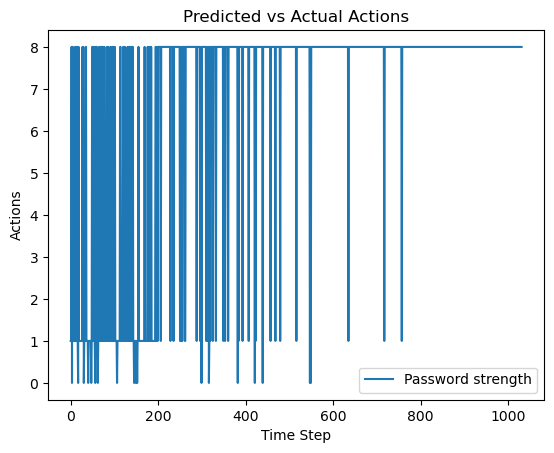

In [240]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(rewards)), rewards, label='Password strength')
plt.xlabel('Time Step')
plt.ylabel('Actions')
plt.title('Predicted vs Actual Actions')
plt.legend()
plt.show()

In the below cell, I demostrate the learning by showing the breakup of 0s, 1s and 2s in every one hundred time intervals. It is evident that as time progresses, learning has taken place.

In [232]:
print("          0 1 2")
print("------------------")
for i in range(10):
    sub = np.array(rewards[i*100:(i+1)*100])
    print(f"{i*100} to {(i+1)*100} {sub.tolist().count([0])},{sub.tolist().count([1])},{sub.tolist().count([8])}")

          0 1 2
------------------
0 to 100 7,66,27
100 to 200 4,76,20
200 to 300 1,12,87
300 to 400 2,11,87
400 to 500 2,5,93
500 to 600 2,1,97
600 to 700 0,1,99
700 to 800 0,2,98
800 to 900 0,0,100
900 to 1000 0,0,100


[[1, 3, 5, 0, 9],
 [4, 0, 9, 0, 13],
 [9, 0, 5, 0, 14],
 [0, 2, 0, 5, 7],
 [5, 4, 6, 0, 15],
 [0, 13, 0, 2, 15],
 [2, 2, 2, 4, 10],
 [0, 0, 4, 8, 12],
 [4, 2, 0, 2, 8],
 [5, 6, 0, 1, 12],
 [4, 5, 5, 1, 15],
 [0, 9, 0, 2, 11],
 [3, 6, 4, 0, 13],
 [5, 8, 0, 0, 13],
 [0, 12, 2, 1, 15],
 [1, 3, 4, 7, 15],
 [1, 1, 7, 4, 13],
 [0, 3, 4, 0, 7],
 [0, 9, 0, 5, 14],
 [0, 1, 2, 9, 12],
 [0, 3, 5, 5, 13],
 [0, 8, 2, 1, 11],
 [0, 1, 8, 1, 10],
 [0, 2, 1, 9, 12],
 [5, 5, 0, 3, 13],
 [8, 0, 2, 2, 12],
 [0, 4, 8, 1, 13],
 [5, 4, 4, 2, 15],
 [7, 2, 0, 0, 9],
 [9, 4, 0, 1, 14],
 [0, 4, 1, 0, 5],
 [6, 1, 3, 3, 13],
 [2, 5, 2, 3, 12],
 [1, 6, 1, 4, 12],
 [6, 1, 2, 0, 9],
 [2, 2, 3, 7, 14],
 [3, 2, 1, 3, 9],
 [1, 6, 1, 4, 12],
 [1, 3, 1, 4, 9],
 [1, 6, 1, 4, 12],
 [2, 1, 0, 3, 6],
 [2, 3, 4, 0, 9],
 [0, 0, 2, 11, 13],
 [4, 3, 4, 2, 13],
 [1, 9, 0, 0, 10],
 [1, 2, 2, 8, 13],
 [2, 6, 1, 2, 11],
 [0, 1, 1, 5, 7],
 [4, 3, 2, 1, 10],
 [6, 5, 2, 1, 14],
 [3, 8, 1, 3, 15],
 [1, 6, 1, 4, 12],
 [1, 7, 1, 3, 12],
 [

In [238]:
import random
import string

def generate_random_string(specs):
    num_upper = specs[0]
    num_digits = specs[1]
    num_lower = specs[2]
    num_special = specs[3]
    total_length = specs[4]
    
    upper_chars = random.choices(string.ascii_uppercase, k=num_upper)
    digit_chars = random.choices(string.digits, k=num_digits)
    lower_chars = random.choices(string.ascii_lowercase, k=num_lower)
    special_chars = random.choices(string.punctuation, k=num_special)
    
    all_chars = upper_chars + digit_chars + lower_chars + special_chars
    random.shuffle(all_chars)
    
    random_string = ''.join(all_chars)
    return random_string

gen = []
for i in range(len(passwords)):
    random_string = generate_random_string(passwords[i])
    gen.append(random_string)



In [242]:
gen

['O7mh86fac',
 'BgaiVbEbTjkoo',
 'PqBdUSKOklAdYU',
 ']|4~>0}',
 '64opxDdt4MKdT9Q',
 '59088>,79405322',
 '8^H[>qG7x,',
 '#&]kp?]]mn.~',
 '?4!ASLR9',
 '4F5I46D.M4E5',
 '1yriU80vB84ExI{',
 "306463'008{",
 'w08c2tK15KjC1',
 'Y0B497M7MU321',
 '4728b13329h(688',
 "4>f?o)]|5M$4fv'",
 '+@yvtx|v`7mlP',
 '97ie4wj',
 '62\\08351"+,~72',
 ']?l/?|"4.#=r',
 'w}34zer#o)+&4',
 '6yu71-07590',
 '6zzc|ecryk',
 '`/*[5f[(-1<}',
 '|5235IA:P0%IO',
 'hB@FZL?IXZcD',
 'xbjs5o=p7bl11',
 '44WL5H7@oWzv?oJ',
 'I1CF8TLQG',
 'DCEAP?F71RVT86',
 '919q6',
 '8&dW_SyItP$GQ',
 '`A8y_7b46D3@',
 'v`1/R{09_483',
 'HsIf0AIZF',
 '-)H(}#hY@n>40g',
 'Q0K)]X7_i',
 'm0(53-/44_G4',
 '1&+Ug%1<5',
 ']57{60}jQ3~5',
 '~NK*;1',
 'ee1k43kFX',
 'u$][_`?{$=<p&',
 'zT>eaY}962CdW',
 '36083M4364',
 '5Y<x1`t*-}\\{[',
 '8`Z,1T0n521',
 '`;<]2`e',
 'U_YKb3v57R',
 'TCkNNiN60)3F58',
 'F4?IT]6y419?647',
 'b?674=84J~_2',
 'Q63m2}<3025@',
 "3^0795z6<W'?",
 '-1;`0j;/?$/8=9',
 '11m0P7817',
 'srZe.W%',
 '`H9q+99281->',
 '3?8054H1{|n4599',
 "[f)u`j)m'`<p>/"